In [1]:
import os
import h5py

import socket
import struct
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import time

from tqdm import tqdm



import numpy as np
import copy

/home/ubuntu/anaconda3/envs/maya1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

client side


In [3]:
# keep the path same, just create a folder named cifar in your drive
root_path = './cifar'

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [5]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

In [6]:

trainset1 = torchvision.datasets.CIFAR10(root=root_path, download=True, transform=transform)


Files already downloaded and verified


In [7]:
len(trainset1)

50000

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [9]:
import matplotlib.pyplot as plt


def show_image(img, label):
    print("Label=", trainset1.classes[label], "(" + str(label)  + ")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label= frog (6)


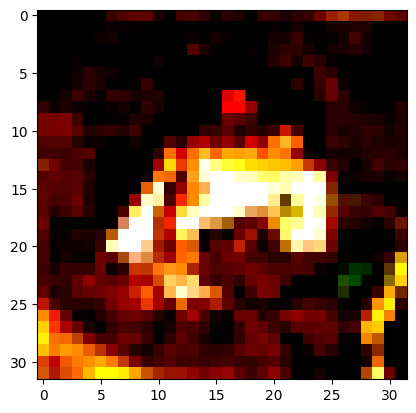

In [10]:
image,label = trainset1[0]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label= truck (9)


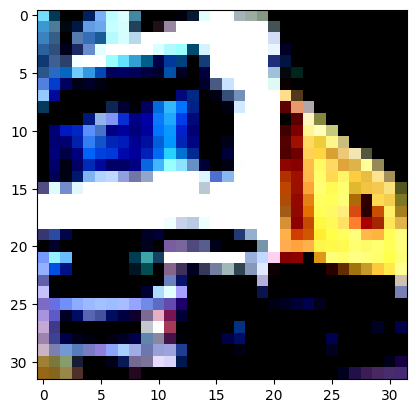

In [11]:
image,label = trainset1[1]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label= truck (9)


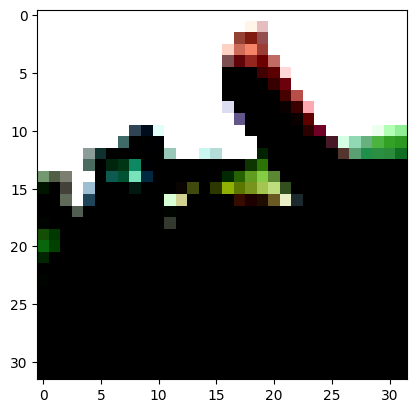

In [12]:
image,label = trainset1[2]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label= truck (9)


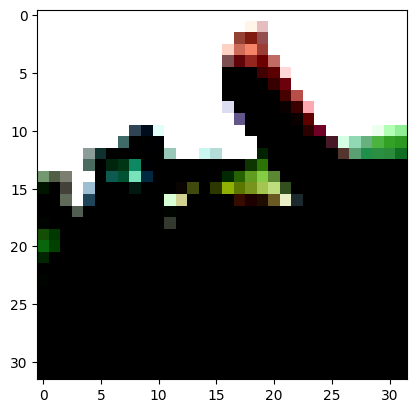

In [13]:
image,label = trainset1[2]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label= deer (4)


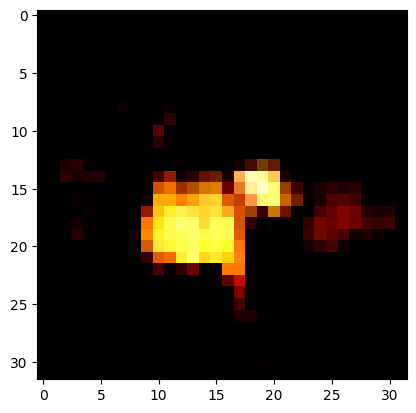

In [14]:
image,label = trainset1[3]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label= automobile (1)


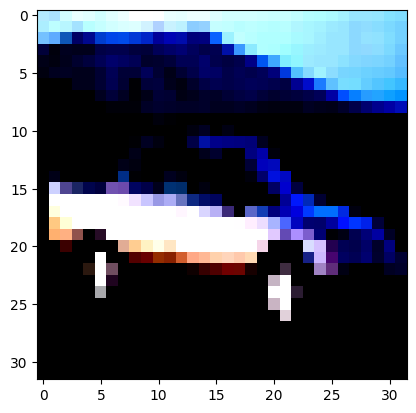

In [15]:
image,label = trainset1[4]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label= automobile (1)


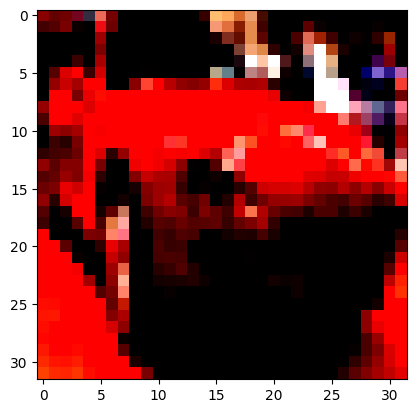

In [16]:
image,label = trainset1[5]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label= bird (2)


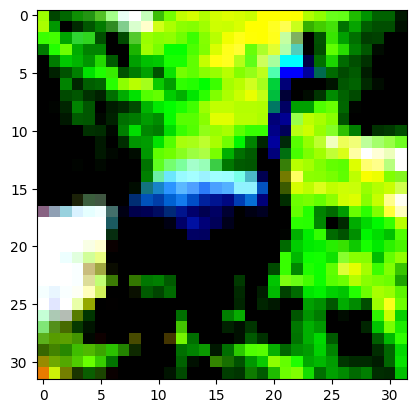

In [17]:
image,label = trainset1[6]
show_image(image, label)

# Define below number of users/clients

In [18]:
users = 5 # clients

In [19]:
trainset1_len = 50000

In [20]:
idxs = np.random.permutation(trainset1_len)
idxs

array([44575, 42931, 17175, ..., 41635, 32759, 16043])

In [21]:
train_indices = idxs
train_indices

array([44575, 42931, 17175, ..., 41635, 32759, 16043])

In [22]:
indices_per_client = int (len(train_indices)/users)

print(indices_per_client)

10000


# trainset2 which has non poisoned data

In [23]:
trainset2 = torchvision.datasets.CIFAR10(root=root_path, download=False, transform=transform)

# TestSet 

In [24]:
testset = torchvision.datasets.CIFAR10 (root=root_path, train=False, download=True, transform=transform)

Files already downloaded and verified


# doing label flipping

In [25]:


# for i in range(len(trainset1)):
#     if (trainset2.targets[i] == 6):
#         trainset2.targets[i] = 8
#     if (trainset2.targets[i] == 2):
#         trainset2.targets[i] = 9

In [26]:
len(testset)

10000

In [27]:
idxs = np.random.permutation(10000)
idxs

array([8068, 5534, 8299, ..., 8345,  703, 1217])

In [28]:
val_indices = idxs
val_indices 

array([8068, 5534, 8299, ..., 8345,  703, 1217])

In [29]:
#experimenting 

users = 5



batch_size = 100

train_loaders2 = [] 

train_trainset2=[]

train_loaders1 = []

train_trainset1 = []


for i in range(users):
  start= indices_per_client*i
  end= indices_per_client * (i+1)
  
  #print((train_indices[start:end]))


  train_trainset1.append(list(train_indices[start:end]))

  train_trainset2.append(list(train_indices[start:end]))

  #print(len(train_dataset))

  train_sampler = SubsetRandomSampler(train_indices[start : end])
  # train_loaders= DataLoader(dataset, batch_size, sampler= train_sampler) 

  #####*********************************************************************################
  ##### IMPORTANT : HERE BELOW CHANGE IF CONDITION TO SELECT NO OF POISONED CLIETNS ########
  #####*********************************************************************################

  if i < 0 :
    print("poisoned: ", i)
    train_loaders1.append(DataLoader(trainset1, batch_size=batch_size,sampler=train_sampler)) # client training on poisoned data
  else:
    train_loaders1.append(DataLoader(trainset2, batch_size=batch_size,sampler=train_sampler)) # rest training on normal data
    print("non-poisoned: ", i)



  train_loaders2.append(DataLoader(trainset2, batch_size=batch_size,sampler=train_sampler))

  





val_sampler = SubsetRandomSampler(val_indices)



test_loader = DataLoader(testset, batch_size=batch_size, sampler=val_sampler) 
# 



non-poisoned:  0
non-poisoned:  1
non-poisoned:  2
non-poisoned:  3
non-poisoned:  4


In [30]:
print(len(train_trainset1))

5


In [31]:
len(train_loaders1)

5

In [32]:
from torch.autograd import Variable
import torch.nn.init as init

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [33]:
net_glob = resnet20()
net_glob.to(device)


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [34]:

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_glob.parameters(), lr=lr, momentum=0.9)


In [35]:
local_epochs = 1

In [36]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [37]:
num_users = 5

frac = 1 # this tells the percentage of clients chosen for each global round. 1=100%(all the clinets are chosen),0.5(only half the clients are chosen)

In [38]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [39]:
# def fgsm_attack(model, loss, images, labels, eps) :
    
#     images = images.to(device)
#     labels = labels.to(device)
#     images.requires_grad = True
           
#     outputs = model(images)
    
#     model.zero_grad()
#     cost = criterion(outputs, labels)
#     cost.backward()
    
#     attack_images = images + eps*images.grad.sign()
#     attack_images = torch.clamp(attack_images, 0, 1)
    
#     return attack_images
def test(net, test_loader, criterion, device, epsilon):
    net.eval()  # set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Generate adversarial examples using FGSM
        data.requires_grad = True
        output = net(data)
        loss = criterion(output, target)
        net.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        with torch.no_grad():
            output = net(perturbed_data)

        # Compute loss and accuracy
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total

    print("Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
        test_loss, correct, total, accuracy))

In [40]:
net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

loss_train_collect = []
acc_train_collect = []
loss_test_collect = []
acc_test_collect = []



for iter in range(200):
    w_locals, loss_locals_train, acc_locals_train, loss_locals_test, acc_locals_test = [], [], [], [], []
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace = False)
    

    global_weights = copy.deepcopy(net_glob.state_dict())
   
    # Training/Testing simulation
    for idx in idxs_users: # each client
        
        net_glob.load_state_dict(global_weights)
        # client training local epochs  
        for local_epoch in range(local_epochs):

          for i, data in enumerate(tqdm(train_loaders1[idx], ncols=100, desc='Round'+str(iter+1)+': User'+str(idx)+'_'+str(local_epoch+1))):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.clone().detach().long().to(device)
            #data.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net_glob(inputs)
            loss = criterion(outputs, labels)
            #net_glob.zero_grad()
            loss.backward()
            #data_grad = data.grad.data
            #perturbed_data = fgsm_attack(inputs, 0.3, data_grad)
            #output = net_glob(perturbed_data)
            optimizer.step()
          
        w = copy.deepcopy(net_glob.state_dict())
        w_locals.append(copy.deepcopy(w))
      
      
    w_glob = FedAvg(w_locals)
    # update global model --- copy weight to net_glob -- distributed the model to all users
    net_glob.load_state_dict(w_glob)

    # train acc
    with torch.no_grad():
        corr_num = 0
        total_num = 0
        train_loss = 0.0
        for idx in idxs_users:
          for j, trn in enumerate(train_loaders2[idx]):
            trn_x, trn_label = trn
            trn_x = trn_x.to(device)
            trn_label = trn_label.clone().detach().long().to(device)

            trn_output = net_glob(trn_x)
            loss = criterion(trn_output, trn_label)
            train_loss += loss.item()
            model_label = trn_output.argmax(dim=1)
            corr = trn_label[trn_label == model_label].size(0)
            corr_num += corr
            total_num += trn_label.size(0)
          print("client:{} train_acc: {:.2f}%, train_loss: {:.4f}".format(idx, corr_num / total_num * 100, train_loss / len(train_loaders2)))

    # Assuming you have already defined your neural network model, test dataset loader, loss criterion, and device
    epsilon = 0.1  # choose a value for epsilon
    test(net=net_glob, test_loader=test_loader, criterion=criterion, device=device, epsilon=epsilon)
#     with torch.no_grad():
#         corr_num = 0
#         total_num = 0
#         val_loss = 0.0
#         for j, val in enumerate(test_loader):
#             val_x, val_label = val
#             val_x = val_x.to(device)
#             data = val_x
            
#             data.requires_grad = True
#             #val_x = fgsm_attack(net_glob, loss, val_x, val_label, 0.3).to(device)
#             val_label = val_label.clone().detach().long().to(device)
#             val_output = net_glob(data)
            
#             loss = criterion(val_output, val_label)
#             net_glob.zero_grad()
#             loss.backward()
#             data_grad = data.grad.data
#             perturbed_data = fgsm_attack(data, 0.3, data_grad)
#             output = net_glob(perturbed_data)
#             val_loss += loss.item()
#             model_label = val_output.argmax(dim=1)
#             corr = val_label[val_label == model_label].size(0)
#             corr_num += corr
#             total_num += val_label.size(0)
#             accuracy = corr_num / total_num * 100
#             test_loss = val_loss / len(test_loader)
#         print("test_acc: {:.2f}%, test_loss: {:.4f}".format( accuracy, test_loss))
    
#     # prepare to count predictions for each class
#     correct_pred = {classname: 0 for classname in classes}
#     total_pred = {classname: 0 for classname in classes}

#     # again no gradients needed
#     with torch.no_grad():
#         for data in test_loader:
#             images, labels = data
#             outputs = net_glob(images)
#             _, predictions = torch.max(outputs, 1)
#             # collect the correct predictions for each class
#             for label, prediction in zip(labels, predictions):
#                 if label == prediction:
#                     correct_pred[classes[label]] += 1
#                 total_pred[classes[label]] += 1


#     # print accuracy for each class
#     for classname, correct_count in correct_pred.items():
#         accuracy = 100 * float(correct_count) / total_pred[classname]
#         print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
#                                                       accuracy))



Round1: User1_1: 100%|████████████████████████████████████████████| 100/100 [00:03<00:00, 29.36it/s]


client:4 train_acc: 29.48%, train_loss: 37.8284
client:2 train_acc: 29.59%, train_loss: 75.6618
client:3 train_acc: 29.47%, train_loss: 113.5981
client:0 train_acc: 29.38%, train_loss: 151.5098
client:1 train_acc: 29.39%, train_loss: 189.3088
Test set: Average loss: 2.7472, Accuracy: 839/10000 (8.39%)


Round2: User3_1: 100%|████████████████████████████████████████████| 100/100 [00:03<00:00, 30.64it/s]


client:0 train_acc: 35.68%, train_loss: 34.4532
client:2 train_acc: 36.25%, train_loss: 68.7965
client:4 train_acc: 36.42%, train_loss: 102.9159
client:1 train_acc: 36.54%, train_loss: 137.0276
client:3 train_acc: 36.52%, train_loss: 171.3378
Test set: Average loss: 3.0963, Accuracy: 964/10000 (9.64%)


Round3: User2_1: 100%|████████████████████████████████████████████| 100/100 [00:03<00:00, 30.22it/s]


client:3 train_acc: 39.72%, train_loss: 32.8378
client:4 train_acc: 39.68%, train_loss: 65.4890
client:1 train_acc: 39.43%, train_loss: 98.2657
client:0 train_acc: 39.43%, train_loss: 131.1658
client:2 train_acc: 39.38%, train_loss: 164.0512
Test set: Average loss: 3.4360, Accuracy: 933/10000 (9.33%)


Round4: User2_1: 100%|████████████████████████████████████████████| 100/100 [00:03<00:00, 29.85it/s]


client:1 train_acc: 41.81%, train_loss: 31.6596
client:3 train_acc: 42.00%, train_loss: 63.4550
client:0 train_acc: 41.68%, train_loss: 95.3748
client:4 train_acc: 41.77%, train_loss: 127.0470
client:2 train_acc: 41.78%, train_loss: 158.8896
Test set: Average loss: 3.2562, Accuracy: 1103/10000 (11.03%)


Round5: User2_1: 100%|████████████████████████████████████████████| 100/100 [00:03<00:00, 30.28it/s]


client:4 train_acc: 44.03%, train_loss: 30.6861
client:3 train_acc: 43.95%, train_loss: 61.2920
client:1 train_acc: 43.89%, train_loss: 91.8583
client:0 train_acc: 43.74%, train_loss: 122.7058
client:2 train_acc: 43.74%, train_loss: 153.5020
Test set: Average loss: 3.1100, Accuracy: 1118/10000 (11.18%)


Round6: User0_1: 100%|████████████████████████████████████████████| 100/100 [00:03<00:00, 29.16it/s]


client:3 train_acc: 45.68%, train_loss: 29.8718
client:2 train_acc: 45.26%, train_loss: 59.9141
client:4 train_acc: 45.13%, train_loss: 89.8526
client:1 train_acc: 45.15%, train_loss: 119.7271
client:0 train_acc: 45.00%, train_loss: 149.8226
Test set: Average loss: 3.1970, Accuracy: 1214/10000 (12.14%)


Round7: User2_1: 100%|████████████████████████████████████████████| 100/100 [00:03<00:00, 29.27it/s]


client:3 train_acc: 46.74%, train_loss: 29.2098
client:0 train_acc: 46.54%, train_loss: 58.5840
client:1 train_acc: 46.58%, train_loss: 87.7703
client:4 train_acc: 46.47%, train_loss: 117.1222
client:2 train_acc: 46.37%, train_loss: 146.5177
Test set: Average loss: 3.1854, Accuracy: 1162/10000 (11.62%)


Round8: User4_1: 100%|████████████████████████████████████████████| 100/100 [00:03<00:00, 28.93it/s]


client:1 train_acc: 48.15%, train_loss: 28.7072
client:2 train_acc: 47.95%, train_loss: 57.6354
client:3 train_acc: 48.01%, train_loss: 86.3517
client:0 train_acc: 47.91%, train_loss: 115.2455
client:4 train_acc: 47.76%, train_loss: 144.1519
Test set: Average loss: 3.0829, Accuracy: 1282/10000 (12.82%)


Round9: User1_1: 100%|████████████████████████████████████████████| 100/100 [00:03<00:00, 30.57it/s]


client:4 train_acc: 48.24%, train_loss: 28.3994
client:2 train_acc: 48.30%, train_loss: 56.8793
client:0 train_acc: 48.38%, train_loss: 85.3124
client:3 train_acc: 48.48%, train_loss: 113.5469
client:1 train_acc: 48.45%, train_loss: 141.8833
Test set: Average loss: 3.1991, Accuracy: 1225/10000 (12.25%)


Round10: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.40it/s]


client:4 train_acc: 48.66%, train_loss: 27.8547
client:1 train_acc: 49.32%, train_loss: 55.5057
client:0 train_acc: 49.37%, train_loss: 83.3743
client:2 train_acc: 49.37%, train_loss: 111.2456
client:3 train_acc: 49.45%, train_loss: 138.9142
Test set: Average loss: 3.0818, Accuracy: 1296/10000 (12.96%)


Round11: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.46it/s]


client:4 train_acc: 50.05%, train_loss: 27.5497
client:0 train_acc: 50.26%, train_loss: 55.0303
client:1 train_acc: 50.21%, train_loss: 82.3986
client:3 train_acc: 50.24%, train_loss: 109.7348
client:2 train_acc: 50.21%, train_loss: 137.3391
Test set: Average loss: 3.1470, Accuracy: 1254/10000 (12.54%)


Round12: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.07it/s]


client:1 train_acc: 51.05%, train_loss: 26.9697
client:2 train_acc: 50.84%, train_loss: 54.1381
client:4 train_acc: 50.61%, train_loss: 81.3442
client:3 train_acc: 50.76%, train_loss: 108.2760
client:0 train_acc: 50.74%, train_loss: 135.4583
Test set: Average loss: 3.1548, Accuracy: 1267/10000 (12.67%)


Round13: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.98it/s]


client:4 train_acc: 50.60%, train_loss: 26.8798
client:1 train_acc: 51.09%, train_loss: 53.4911
client:2 train_acc: 51.19%, train_loss: 80.3082
client:3 train_acc: 51.50%, train_loss: 106.9025
client:0 train_acc: 51.47%, train_loss: 133.7454
Test set: Average loss: 3.2311, Accuracy: 1301/10000 (13.01%)


Round14: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.46it/s]


client:2 train_acc: 51.94%, train_loss: 26.5736
client:0 train_acc: 51.78%, train_loss: 53.1343
client:3 train_acc: 51.99%, train_loss: 79.4358
client:1 train_acc: 52.00%, train_loss: 105.7730
client:4 train_acc: 51.89%, train_loss: 132.3212
Test set: Average loss: 3.1920, Accuracy: 1375/10000 (13.75%)


Round15: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.48it/s]


client:3 train_acc: 53.40%, train_loss: 25.9287
client:2 train_acc: 53.15%, train_loss: 52.1146
client:0 train_acc: 53.07%, train_loss: 78.2747
client:1 train_acc: 53.03%, train_loss: 104.2462
client:4 train_acc: 52.85%, train_loss: 130.4470
Test set: Average loss: 3.3336, Accuracy: 1325/10000 (13.25%)


Round16: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.97it/s]


client:2 train_acc: 53.23%, train_loss: 25.8956
client:0 train_acc: 53.35%, train_loss: 51.7521
client:3 train_acc: 53.64%, train_loss: 77.3837
client:1 train_acc: 53.56%, train_loss: 103.0157
client:4 train_acc: 53.27%, train_loss: 128.9493
Test set: Average loss: 3.2293, Accuracy: 1359/10000 (13.59%)


Round17: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.60it/s]


client:1 train_acc: 54.20%, train_loss: 25.1919
client:0 train_acc: 54.40%, train_loss: 50.5852
client:3 train_acc: 54.59%, train_loss: 75.7888
client:4 train_acc: 54.29%, train_loss: 101.2963
client:2 train_acc: 54.20%, train_loss: 126.7905
Test set: Average loss: 3.1395, Accuracy: 1417/10000 (14.17%)


Round18: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.65it/s]


client:3 train_acc: 55.43%, train_loss: 24.9376
client:0 train_acc: 55.22%, train_loss: 50.0400
client:4 train_acc: 54.92%, train_loss: 75.2567
client:1 train_acc: 54.94%, train_loss: 100.1768
client:2 train_acc: 54.95%, train_loss: 125.3817
Test set: Average loss: 3.2440, Accuracy: 1390/10000 (13.90%)


Round19: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.70it/s]


client:4 train_acc: 54.11%, train_loss: 25.1731
client:3 train_acc: 54.84%, train_loss: 50.0312
client:0 train_acc: 54.86%, train_loss: 75.0891
client:1 train_acc: 54.85%, train_loss: 99.9971
client:2 train_acc: 54.84%, train_loss: 125.1342
Test set: Average loss: 3.2493, Accuracy: 1462/10000 (14.62%)


Round20: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.63it/s]


client:2 train_acc: 55.63%, train_loss: 24.6652
client:1 train_acc: 55.62%, train_loss: 49.0486
client:4 train_acc: 55.48%, train_loss: 73.8051
client:0 train_acc: 55.55%, train_loss: 98.4395
client:3 train_acc: 55.75%, train_loss: 122.8702
Test set: Average loss: 3.2243, Accuracy: 1406/10000 (14.06%)


Round21: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.24it/s]


client:0 train_acc: 56.25%, train_loss: 24.3208
client:4 train_acc: 56.10%, train_loss: 48.8000
client:3 train_acc: 56.32%, train_loss: 72.9604
client:2 train_acc: 56.31%, train_loss: 97.3368
client:1 train_acc: 56.31%, train_loss: 121.4619
Test set: Average loss: 3.1109, Accuracy: 1472/10000 (14.72%)


Round22: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.51it/s]


client:2 train_acc: 55.99%, train_loss: 24.3477
client:1 train_acc: 55.96%, train_loss: 48.4192
client:3 train_acc: 56.13%, train_loss: 72.5777
client:0 train_acc: 56.05%, train_loss: 96.8470
client:4 train_acc: 56.03%, train_loss: 121.3092
Test set: Average loss: 2.9946, Accuracy: 1598/10000 (15.98%)


Round23: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.25it/s]


client:3 train_acc: 57.81%, train_loss: 23.6226
client:0 train_acc: 57.43%, train_loss: 47.4156
client:2 train_acc: 57.34%, train_loss: 71.2555
client:1 train_acc: 57.26%, train_loss: 94.8809
client:4 train_acc: 57.18%, train_loss: 118.8535
Test set: Average loss: 3.1507, Accuracy: 1470/10000 (14.70%)


Round24: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.41it/s]


client:0 train_acc: 56.96%, train_loss: 23.6394
client:4 train_acc: 57.15%, train_loss: 47.4836
client:2 train_acc: 57.23%, train_loss: 71.1895
client:3 train_acc: 57.39%, train_loss: 94.7145
client:1 train_acc: 57.33%, train_loss: 118.2423
Test set: Average loss: 3.1068, Accuracy: 1523/10000 (15.23%)


Round25: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.92it/s]


client:2 train_acc: 57.48%, train_loss: 23.8024
client:4 train_acc: 57.42%, train_loss: 47.7377
client:0 train_acc: 57.43%, train_loss: 71.4320
client:1 train_acc: 57.38%, train_loss: 94.9487
client:3 train_acc: 57.57%, train_loss: 118.5146
Test set: Average loss: 3.2618, Accuracy: 1474/10000 (14.74%)


Round26: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.40it/s]


client:3 train_acc: 59.34%, train_loss: 22.9112
client:2 train_acc: 58.94%, train_loss: 46.0409
client:0 train_acc: 58.88%, train_loss: 69.0238
client:4 train_acc: 58.70%, train_loss: 92.3163
client:1 train_acc: 58.61%, train_loss: 115.1782
Test set: Average loss: 3.0966, Accuracy: 1523/10000 (15.23%)


Round27: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.45it/s]


client:4 train_acc: 58.71%, train_loss: 23.2257
client:1 train_acc: 58.48%, train_loss: 46.0427
client:0 train_acc: 58.52%, train_loss: 69.0080
client:2 train_acc: 58.48%, train_loss: 92.0772
client:3 train_acc: 58.61%, train_loss: 114.9764
Test set: Average loss: 3.0515, Accuracy: 1525/10000 (15.25%)


Round28: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.93it/s]


client:4 train_acc: 58.90%, train_loss: 22.8323
client:0 train_acc: 59.00%, train_loss: 45.3810
client:2 train_acc: 59.12%, train_loss: 68.0563
client:3 train_acc: 59.25%, train_loss: 90.5628
client:1 train_acc: 59.11%, train_loss: 113.0154
Test set: Average loss: 3.1676, Accuracy: 1489/10000 (14.89%)


Round29: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.86it/s]


client:0 train_acc: 59.76%, train_loss: 22.3862
client:3 train_acc: 59.91%, train_loss: 44.6433
client:1 train_acc: 59.73%, train_loss: 66.9600
client:4 train_acc: 59.66%, train_loss: 89.5968
client:2 train_acc: 59.68%, train_loss: 112.0245
Test set: Average loss: 3.1603, Accuracy: 1538/10000 (15.38%)


Round30: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.14it/s]


client:4 train_acc: 60.07%, train_loss: 22.3349
client:2 train_acc: 60.44%, train_loss: 44.4609
client:3 train_acc: 60.58%, train_loss: 66.4354
client:0 train_acc: 60.48%, train_loss: 88.5050
client:1 train_acc: 60.49%, train_loss: 110.4653
Test set: Average loss: 3.1223, Accuracy: 1532/10000 (15.32%)


Round31: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.78it/s]


client:2 train_acc: 60.60%, train_loss: 22.0808
client:4 train_acc: 60.24%, train_loss: 44.3859
client:3 train_acc: 60.35%, train_loss: 66.3077
client:1 train_acc: 60.20%, train_loss: 88.2333
client:0 train_acc: 60.20%, train_loss: 110.2383
Test set: Average loss: 3.1205, Accuracy: 1504/10000 (15.04%)


Round32: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.41it/s]


client:1 train_acc: 60.33%, train_loss: 21.5193
client:2 train_acc: 60.76%, train_loss: 43.2125
client:4 train_acc: 60.75%, train_loss: 65.1869
client:0 train_acc: 60.84%, train_loss: 86.7502
client:3 train_acc: 61.03%, train_loss: 108.3340
Test set: Average loss: 3.1285, Accuracy: 1570/10000 (15.70%)


Round33: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.17it/s]


client:0 train_acc: 61.15%, train_loss: 21.5111
client:4 train_acc: 61.04%, train_loss: 43.3793
client:1 train_acc: 60.77%, train_loss: 64.8605
client:2 train_acc: 60.83%, train_loss: 86.5229
client:3 train_acc: 61.02%, train_loss: 108.0102
Test set: Average loss: 3.0618, Accuracy: 1567/10000 (15.67%)


Round34: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.11it/s]


client:0 train_acc: 61.76%, train_loss: 21.2918
client:3 train_acc: 61.98%, train_loss: 42.4810
client:2 train_acc: 61.93%, train_loss: 63.8760
client:1 train_acc: 61.69%, train_loss: 85.1973
client:4 train_acc: 61.63%, train_loss: 106.8442
Test set: Average loss: 3.1016, Accuracy: 1613/10000 (16.13%)


Round35: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.65it/s]


client:3 train_acc: 62.76%, train_loss: 20.9089
client:0 train_acc: 62.71%, train_loss: 41.8778
client:4 train_acc: 62.45%, train_loss: 63.2047
client:1 train_acc: 62.29%, train_loss: 84.0703
client:2 train_acc: 62.36%, train_loss: 105.1263
Test set: Average loss: 3.0498, Accuracy: 1579/10000 (15.79%)


Round36: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.02it/s]


client:4 train_acc: 62.06%, train_loss: 21.2851
client:2 train_acc: 62.33%, train_loss: 42.3509
client:0 train_acc: 62.39%, train_loss: 63.2804
client:3 train_acc: 62.48%, train_loss: 84.1959
client:1 train_acc: 62.39%, train_loss: 105.0389
Test set: Average loss: 2.9630, Accuracy: 1676/10000 (16.76%)


Round37: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.62it/s]


client:1 train_acc: 62.38%, train_loss: 20.6906
client:0 train_acc: 62.63%, train_loss: 41.4595
client:3 train_acc: 62.72%, train_loss: 62.1966
client:2 train_acc: 62.82%, train_loss: 83.0458
client:4 train_acc: 62.70%, train_loss: 104.1893
Test set: Average loss: 3.0507, Accuracy: 1665/10000 (16.65%)


Round38: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.26it/s]


client:3 train_acc: 63.24%, train_loss: 20.4734
client:1 train_acc: 62.92%, train_loss: 40.8872
client:0 train_acc: 62.86%, train_loss: 61.4125
client:2 train_acc: 62.94%, train_loss: 82.0209
client:4 train_acc: 62.88%, train_loss: 102.8655
Test set: Average loss: 2.9565, Accuracy: 1680/10000 (16.80%)


Round39: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.09it/s]


client:4 train_acc: 62.70%, train_loss: 20.7651
client:1 train_acc: 62.75%, train_loss: 41.0531
client:2 train_acc: 62.92%, train_loss: 61.5705
client:0 train_acc: 63.03%, train_loss: 81.9551
client:3 train_acc: 63.17%, train_loss: 102.3359
Test set: Average loss: 2.9954, Accuracy: 1721/10000 (17.21%)


Round40: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.67it/s]


client:4 train_acc: 63.58%, train_loss: 20.5110
client:3 train_acc: 63.94%, train_loss: 40.5826
client:2 train_acc: 63.97%, train_loss: 60.8424
client:1 train_acc: 63.81%, train_loss: 80.9812
client:0 train_acc: 63.82%, train_loss: 101.1640
Test set: Average loss: 3.1711, Accuracy: 1657/10000 (16.57%)


Round41: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.51it/s]


client:3 train_acc: 64.70%, train_loss: 19.8763
client:2 train_acc: 64.61%, train_loss: 39.9112
client:0 train_acc: 64.53%, train_loss: 59.8236
client:1 train_acc: 64.33%, train_loss: 79.6909
client:4 train_acc: 64.25%, train_loss: 99.9257
Test set: Average loss: 3.1309, Accuracy: 1603/10000 (16.03%)


Round42: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.35it/s]


client:1 train_acc: 64.49%, train_loss: 19.5573
client:2 train_acc: 64.81%, train_loss: 39.3026
client:0 train_acc: 64.83%, train_loss: 58.9960
client:3 train_acc: 64.90%, train_loss: 78.5948
client:4 train_acc: 64.83%, train_loss: 98.6038
Test set: Average loss: 3.0141, Accuracy: 1677/10000 (16.77%)


Round43: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.25it/s]


client:4 train_acc: 64.73%, train_loss: 19.9687
client:0 train_acc: 65.01%, train_loss: 39.6544
client:1 train_acc: 65.01%, train_loss: 59.2966
client:3 train_acc: 65.11%, train_loss: 78.8144
client:2 train_acc: 65.20%, train_loss: 98.5433
Test set: Average loss: 3.0677, Accuracy: 1667/10000 (16.67%)


Round44: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.13it/s]


client:4 train_acc: 64.47%, train_loss: 19.7759
client:2 train_acc: 64.66%, train_loss: 39.4038
client:0 train_acc: 64.86%, train_loss: 58.8590
client:1 train_acc: 64.79%, train_loss: 78.3119
client:3 train_acc: 64.99%, train_loss: 97.7502
Test set: Average loss: 3.0504, Accuracy: 1642/10000 (16.42%)


Round45: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.17it/s]


client:2 train_acc: 65.95%, train_loss: 19.3689
client:3 train_acc: 66.04%, train_loss: 38.5923
client:1 train_acc: 65.84%, train_loss: 57.7627
client:0 train_acc: 65.77%, train_loss: 77.0443
client:4 train_acc: 65.59%, train_loss: 96.6335
Test set: Average loss: 3.0945, Accuracy: 1672/10000 (16.72%)


Round46: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.23it/s]


client:0 train_acc: 65.97%, train_loss: 19.2171
client:2 train_acc: 65.84%, train_loss: 38.5246
client:3 train_acc: 65.88%, train_loss: 57.6706
client:4 train_acc: 65.70%, train_loss: 77.2513
client:1 train_acc: 65.57%, train_loss: 96.5194
Test set: Average loss: 3.1008, Accuracy: 1630/10000 (16.30%)


Round47: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.19it/s]


client:0 train_acc: 66.53%, train_loss: 18.9293
client:3 train_acc: 66.55%, train_loss: 37.7570
client:2 train_acc: 66.51%, train_loss: 56.7951
client:4 train_acc: 66.28%, train_loss: 76.0745
client:1 train_acc: 66.13%, train_loss: 94.9701
Test set: Average loss: 3.1830, Accuracy: 1632/10000 (16.32%)


Round48: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.64it/s]


client:1 train_acc: 64.64%, train_loss: 19.3143
client:4 train_acc: 64.55%, train_loss: 39.1104
client:2 train_acc: 64.58%, train_loss: 58.7635
client:0 train_acc: 64.78%, train_loss: 78.1524
client:3 train_acc: 64.97%, train_loss: 97.6121
Test set: Average loss: 3.1029, Accuracy: 1615/10000 (16.15%)


Round49: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.95it/s]


client:3 train_acc: 67.53%, train_loss: 18.4795
client:1 train_acc: 67.04%, train_loss: 36.9938
client:0 train_acc: 66.96%, train_loss: 55.5812
client:2 train_acc: 66.94%, train_loss: 74.2619
client:4 train_acc: 66.81%, train_loss: 93.1612
Test set: Average loss: 3.0151, Accuracy: 1723/10000 (17.23%)


Round50: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.29it/s]


client:4 train_acc: 66.70%, train_loss: 18.7381
client:0 train_acc: 66.93%, train_loss: 37.1679
client:3 train_acc: 67.19%, train_loss: 55.4958
client:2 train_acc: 67.17%, train_loss: 74.0200
client:1 train_acc: 67.08%, train_loss: 92.3626
Test set: Average loss: 3.1216, Accuracy: 1656/10000 (16.56%)


Round51: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.35it/s]


client:1 train_acc: 66.64%, train_loss: 18.4460
client:3 train_acc: 67.05%, train_loss: 36.8553
client:2 train_acc: 67.19%, train_loss: 55.3670
client:0 train_acc: 67.11%, train_loss: 73.8634
client:4 train_acc: 66.94%, train_loss: 92.7053
Test set: Average loss: 3.1635, Accuracy: 1629/10000 (16.29%)


Round52: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.75it/s]


client:3 train_acc: 68.33%, train_loss: 17.9736
client:4 train_acc: 67.74%, train_loss: 36.3477
client:2 train_acc: 67.96%, train_loss: 54.4901
client:1 train_acc: 67.86%, train_loss: 72.4698
client:0 train_acc: 67.90%, train_loss: 90.5744
Test set: Average loss: 3.0894, Accuracy: 1718/10000 (17.18%)


Round53: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.65it/s]


client:3 train_acc: 68.40%, train_loss: 17.9430
client:1 train_acc: 68.08%, train_loss: 35.9150
client:0 train_acc: 68.15%, train_loss: 53.9095
client:4 train_acc: 67.92%, train_loss: 72.1967
client:2 train_acc: 67.97%, train_loss: 90.3177
Test set: Average loss: 2.9554, Accuracy: 1855/10000 (18.55%)


Round54: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.10it/s]


client:1 train_acc: 68.22%, train_loss: 17.8246
client:3 train_acc: 68.46%, train_loss: 35.6759
client:4 train_acc: 68.14%, train_loss: 53.9119
client:2 train_acc: 68.09%, train_loss: 71.9583
client:0 train_acc: 68.14%, train_loss: 89.8922
Test set: Average loss: 3.1076, Accuracy: 1709/10000 (17.09%)


Round55: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.64it/s]


client:3 train_acc: 68.47%, train_loss: 17.8219
client:2 train_acc: 68.51%, train_loss: 35.7273
client:1 train_acc: 68.33%, train_loss: 53.5007
client:4 train_acc: 68.10%, train_loss: 71.6859
client:0 train_acc: 68.13%, train_loss: 89.5937
Test set: Average loss: 3.0170, Accuracy: 1738/10000 (17.38%)


Round56: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.60it/s]


client:1 train_acc: 68.47%, train_loss: 17.5915
client:2 train_acc: 68.84%, train_loss: 35.2606
client:3 train_acc: 68.97%, train_loss: 52.8116
client:4 train_acc: 68.81%, train_loss: 70.7255
client:0 train_acc: 68.81%, train_loss: 88.3594
Test set: Average loss: 2.9906, Accuracy: 1685/10000 (16.85%)


Round57: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.17it/s]


client:1 train_acc: 68.65%, train_loss: 17.4129
client:3 train_acc: 68.97%, train_loss: 34.8183
client:0 train_acc: 69.06%, train_loss: 52.3102
client:4 train_acc: 68.78%, train_loss: 70.1167
client:2 train_acc: 68.84%, train_loss: 87.6634
Test set: Average loss: 3.1231, Accuracy: 1738/10000 (17.38%)


Round58: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.19it/s]


client:3 train_acc: 69.56%, train_loss: 17.4151
client:0 train_acc: 69.36%, train_loss: 34.9120
client:1 train_acc: 69.12%, train_loss: 52.2907
client:4 train_acc: 68.99%, train_loss: 70.0460
client:2 train_acc: 68.96%, train_loss: 87.6023
Test set: Average loss: 2.9759, Accuracy: 1708/10000 (17.08%)


Round59: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.98it/s]


client:3 train_acc: 69.83%, train_loss: 17.1214
client:1 train_acc: 69.42%, train_loss: 34.2642
client:0 train_acc: 69.55%, train_loss: 51.5172
client:4 train_acc: 69.25%, train_loss: 69.0751
client:2 train_acc: 69.33%, train_loss: 86.4126
Test set: Average loss: 3.0607, Accuracy: 1743/10000 (17.43%)


Round60: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.87it/s]


client:1 train_acc: 69.08%, train_loss: 17.3817
client:2 train_acc: 69.27%, train_loss: 34.7328
client:0 train_acc: 69.12%, train_loss: 52.1662
client:3 train_acc: 69.21%, train_loss: 69.4482
client:4 train_acc: 69.16%, train_loss: 87.0970
Test set: Average loss: 3.1111, Accuracy: 1734/10000 (17.34%)


Round61: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.24it/s]


client:3 train_acc: 69.81%, train_loss: 17.0672
client:0 train_acc: 69.54%, train_loss: 34.2631
client:2 train_acc: 69.75%, train_loss: 51.3980
client:4 train_acc: 69.47%, train_loss: 68.8849
client:1 train_acc: 69.39%, train_loss: 86.0254
Test set: Average loss: 3.1106, Accuracy: 1678/10000 (16.78%)


Round62: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.87it/s]


client:4 train_acc: 69.76%, train_loss: 17.0322
client:3 train_acc: 70.34%, train_loss: 33.7725
client:0 train_acc: 70.31%, train_loss: 50.5888
client:1 train_acc: 70.25%, train_loss: 67.2699
client:2 train_acc: 70.26%, train_loss: 84.0880
Test set: Average loss: 3.1235, Accuracy: 1704/10000 (17.04%)


Round63: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.97it/s]


client:3 train_acc: 70.55%, train_loss: 16.7416
client:0 train_acc: 70.49%, train_loss: 33.5089
client:2 train_acc: 70.51%, train_loss: 50.2598
client:1 train_acc: 70.43%, train_loss: 66.9115
client:4 train_acc: 70.30%, train_loss: 83.9402
Test set: Average loss: 3.1492, Accuracy: 1715/10000 (17.15%)


Round64: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 32.74it/s]


client:2 train_acc: 70.73%, train_loss: 16.6643
client:3 train_acc: 70.84%, train_loss: 33.2749
client:0 train_acc: 70.69%, train_loss: 49.9522
client:4 train_acc: 70.46%, train_loss: 66.9739
client:1 train_acc: 70.44%, train_loss: 83.5510
Test set: Average loss: 2.9647, Accuracy: 1762/10000 (17.62%)


Round65: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 32.24it/s]


client:2 train_acc: 70.70%, train_loss: 16.6423
client:4 train_acc: 70.46%, train_loss: 33.4318
client:3 train_acc: 70.70%, train_loss: 50.0185
client:1 train_acc: 70.64%, train_loss: 66.4899
client:0 train_acc: 70.73%, train_loss: 82.9796
Test set: Average loss: 2.9791, Accuracy: 1864/10000 (18.64%)


Round66: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.34it/s]


client:0 train_acc: 71.35%, train_loss: 16.2278
client:2 train_acc: 71.35%, train_loss: 32.5380
client:1 train_acc: 71.27%, train_loss: 48.6164
client:4 train_acc: 71.15%, train_loss: 65.1079
client:3 train_acc: 71.24%, train_loss: 81.3444
Test set: Average loss: 2.9647, Accuracy: 1827/10000 (18.27%)


Round67: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.06it/s]


client:4 train_acc: 70.99%, train_loss: 16.4165
client:1 train_acc: 71.08%, train_loss: 32.5321
client:3 train_acc: 71.31%, train_loss: 48.7306
client:0 train_acc: 71.31%, train_loss: 64.9353
client:2 train_acc: 71.26%, train_loss: 81.2086
Test set: Average loss: 2.9726, Accuracy: 1859/10000 (18.59%)


Round68: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.72it/s]


client:1 train_acc: 71.04%, train_loss: 16.0764
client:0 train_acc: 71.42%, train_loss: 32.2865
client:3 train_acc: 71.56%, train_loss: 48.5401
client:2 train_acc: 71.55%, train_loss: 64.7960
client:4 train_acc: 71.37%, train_loss: 81.2295
Test set: Average loss: 2.9072, Accuracy: 1948/10000 (19.48%)


Round69: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.85it/s]


client:0 train_acc: 71.98%, train_loss: 15.8206
client:3 train_acc: 72.38%, train_loss: 31.5750
client:2 train_acc: 72.46%, train_loss: 47.4012
client:4 train_acc: 72.20%, train_loss: 63.5159
client:1 train_acc: 72.20%, train_loss: 79.2403
Test set: Average loss: 2.9851, Accuracy: 1911/10000 (19.11%)


Round70: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:02<00:00, 33.39it/s]


client:1 train_acc: 72.16%, train_loss: 15.6678
client:0 train_acc: 72.32%, train_loss: 31.4134
client:2 train_acc: 72.16%, train_loss: 47.2779
client:3 train_acc: 72.26%, train_loss: 63.0756
client:4 train_acc: 72.07%, train_loss: 79.1368
Test set: Average loss: 2.8734, Accuracy: 1936/10000 (19.36%)


Round71: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 32.33it/s]


client:0 train_acc: 72.73%, train_loss: 15.6229
client:1 train_acc: 72.54%, train_loss: 31.1739
client:2 train_acc: 72.59%, train_loss: 46.7866
client:4 train_acc: 72.38%, train_loss: 62.6516
client:3 train_acc: 72.44%, train_loss: 78.2457
Test set: Average loss: 3.0383, Accuracy: 1868/10000 (18.68%)


Round72: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 32.34it/s]


client:0 train_acc: 72.32%, train_loss: 15.7104
client:2 train_acc: 72.45%, train_loss: 31.4256
client:3 train_acc: 72.53%, train_loss: 47.1285
client:1 train_acc: 72.41%, train_loss: 62.7572
client:4 train_acc: 72.26%, train_loss: 78.7759
Test set: Average loss: 2.9620, Accuracy: 1882/10000 (18.82%)


Round73: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.77it/s]


client:0 train_acc: 72.79%, train_loss: 15.4422
client:1 train_acc: 72.56%, train_loss: 30.7778
client:4 train_acc: 72.45%, train_loss: 46.4633
client:3 train_acc: 72.61%, train_loss: 61.8989
client:2 train_acc: 72.66%, train_loss: 77.3628
Test set: Average loss: 3.0252, Accuracy: 1776/10000 (17.76%)


Round74: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.63it/s]


client:3 train_acc: 73.27%, train_loss: 15.3667
client:4 train_acc: 72.67%, train_loss: 31.0213
client:1 train_acc: 72.65%, train_loss: 46.2861
client:0 train_acc: 72.82%, train_loss: 61.6764
client:2 train_acc: 72.80%, train_loss: 77.1358
Test set: Average loss: 2.8912, Accuracy: 1895/10000 (18.95%)


Round75: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 32.22it/s]


client:4 train_acc: 72.77%, train_loss: 15.4595
client:2 train_acc: 73.22%, train_loss: 30.6557
client:3 train_acc: 73.49%, train_loss: 45.8531
client:0 train_acc: 73.42%, train_loss: 61.1175
client:1 train_acc: 73.32%, train_loss: 76.2646
Test set: Average loss: 3.0390, Accuracy: 1787/10000 (17.87%)


Round76: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 32.03it/s]


client:4 train_acc: 72.12%, train_loss: 15.6755
client:0 train_acc: 72.55%, train_loss: 31.1181
client:3 train_acc: 72.84%, train_loss: 46.5331
client:2 train_acc: 72.91%, train_loss: 61.9484
client:1 train_acc: 72.94%, train_loss: 77.1728
Test set: Average loss: 2.9498, Accuracy: 1866/10000 (18.66%)


Round77: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 32.27it/s]


client:4 train_acc: 73.20%, train_loss: 15.2798
client:1 train_acc: 73.35%, train_loss: 30.2099
client:3 train_acc: 73.64%, train_loss: 45.2482
client:2 train_acc: 73.72%, train_loss: 60.2717
client:0 train_acc: 73.76%, train_loss: 75.2847
Test set: Average loss: 2.9481, Accuracy: 1941/10000 (19.41%)


Round78: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 32.06it/s]


client:3 train_acc: 73.96%, train_loss: 15.1204
client:4 train_acc: 73.48%, train_loss: 30.3798
client:0 train_acc: 73.66%, train_loss: 45.3831
client:2 train_acc: 73.59%, train_loss: 60.4940
client:1 train_acc: 73.53%, train_loss: 75.3785
Test set: Average loss: 2.9278, Accuracy: 2011/10000 (20.11%)


Round79: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 32.20it/s]


client:0 train_acc: 74.55%, train_loss: 14.6631
client:2 train_acc: 74.41%, train_loss: 29.3687
client:4 train_acc: 74.11%, train_loss: 44.3141
client:1 train_acc: 74.04%, train_loss: 58.9143
client:3 train_acc: 74.11%, train_loss: 73.6773
Test set: Average loss: 3.0121, Accuracy: 1861/10000 (18.61%)


Round80: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.09it/s]


client:4 train_acc: 73.77%, train_loss: 14.8907
client:2 train_acc: 74.10%, train_loss: 29.5741
client:3 train_acc: 74.16%, train_loss: 44.2893
client:0 train_acc: 74.27%, train_loss: 58.9293
client:1 train_acc: 74.16%, train_loss: 73.4475
Test set: Average loss: 3.0226, Accuracy: 1883/10000 (18.83%)


Round81: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.18it/s]


client:0 train_acc: 75.13%, train_loss: 14.4433
client:2 train_acc: 75.02%, train_loss: 28.8540
client:4 train_acc: 74.77%, train_loss: 43.4605
client:3 train_acc: 74.89%, train_loss: 57.9086
client:1 train_acc: 74.76%, train_loss: 72.2258
Test set: Average loss: 2.9412, Accuracy: 1907/10000 (19.07%)


Round82: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.34it/s]


client:0 train_acc: 75.16%, train_loss: 14.3281
client:1 train_acc: 74.89%, train_loss: 28.5253
client:2 train_acc: 74.97%, train_loss: 42.8517
client:3 train_acc: 75.03%, train_loss: 57.1849
client:4 train_acc: 74.89%, train_loss: 71.7362
Test set: Average loss: 3.0597, Accuracy: 1860/10000 (18.60%)


Round83: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.99it/s]


client:3 train_acc: 75.46%, train_loss: 14.3216
client:2 train_acc: 75.17%, train_loss: 28.6586
client:1 train_acc: 75.04%, train_loss: 42.8516
client:4 train_acc: 74.89%, train_loss: 57.3974
client:0 train_acc: 74.94%, train_loss: 71.7434
Test set: Average loss: 3.0086, Accuracy: 1967/10000 (19.67%)


Round84: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.70it/s]


client:4 train_acc: 74.75%, train_loss: 14.4258
client:2 train_acc: 75.08%, train_loss: 28.6586
client:3 train_acc: 75.32%, train_loss: 42.8698
client:1 train_acc: 75.22%, train_loss: 56.9454
client:0 train_acc: 75.24%, train_loss: 71.1903
Test set: Average loss: 2.9047, Accuracy: 1924/10000 (19.24%)


Round85: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.12it/s]


client:1 train_acc: 74.48%, train_loss: 14.3594
client:3 train_acc: 74.53%, train_loss: 28.7856
client:2 train_acc: 74.82%, train_loss: 43.1648
client:0 train_acc: 74.80%, train_loss: 57.6034
client:4 train_acc: 74.72%, train_loss: 72.2924
Test set: Average loss: 3.0783, Accuracy: 1843/10000 (18.43%)


Round86: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.09it/s]


client:2 train_acc: 76.03%, train_loss: 13.9181
client:3 train_acc: 76.11%, train_loss: 27.8926
client:0 train_acc: 76.00%, train_loss: 41.9046
client:1 train_acc: 75.80%, train_loss: 55.7767
client:4 train_acc: 75.67%, train_loss: 69.9915
Test set: Average loss: 2.9562, Accuracy: 2035/10000 (20.35%)


Round87: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.01it/s]


client:0 train_acc: 75.81%, train_loss: 14.0265
client:2 train_acc: 75.64%, train_loss: 28.0727
client:3 train_acc: 75.74%, train_loss: 42.0901
client:4 train_acc: 75.55%, train_loss: 56.2575
client:1 train_acc: 75.51%, train_loss: 70.1634
Test set: Average loss: 3.0168, Accuracy: 2002/10000 (20.02%)


Round88: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.68it/s]


client:1 train_acc: 75.06%, train_loss: 13.8413
client:3 train_acc: 75.55%, train_loss: 27.7068
client:4 train_acc: 75.27%, train_loss: 41.8635
client:2 train_acc: 75.35%, train_loss: 55.7717
client:0 train_acc: 75.43%, train_loss: 69.7560
Test set: Average loss: 3.0324, Accuracy: 1893/10000 (18.93%)


Round89: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.69it/s]


client:4 train_acc: 75.40%, train_loss: 14.0058
client:1 train_acc: 75.57%, train_loss: 27.6303
client:2 train_acc: 75.86%, train_loss: 41.3373
client:3 train_acc: 76.09%, train_loss: 55.0809
client:0 train_acc: 76.17%, train_loss: 68.8621
Test set: Average loss: 2.9106, Accuracy: 1936/10000 (19.36%)


Round90: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.03it/s]


client:3 train_acc: 76.84%, train_loss: 13.6789
client:0 train_acc: 76.59%, train_loss: 27.4050
client:2 train_acc: 76.46%, train_loss: 41.0990
client:1 train_acc: 76.35%, train_loss: 54.6720
client:4 train_acc: 76.22%, train_loss: 68.6651
Test set: Average loss: 3.0318, Accuracy: 2022/10000 (20.22%)


Round91: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.87it/s]


client:2 train_acc: 76.17%, train_loss: 13.6974
client:0 train_acc: 76.31%, train_loss: 27.4685
client:3 train_acc: 76.24%, train_loss: 41.2398
client:1 train_acc: 76.15%, train_loss: 54.8696
client:4 train_acc: 76.00%, train_loss: 68.8468
Test set: Average loss: 2.9681, Accuracy: 1880/10000 (18.80%)


Round92: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 31.05it/s]


client:4 train_acc: 75.94%, train_loss: 13.8050
client:1 train_acc: 76.02%, train_loss: 27.3178
client:0 train_acc: 76.13%, train_loss: 40.8842
client:2 train_acc: 76.10%, train_loss: 54.5241
client:3 train_acc: 76.20%, train_loss: 68.1790
Test set: Average loss: 3.0218, Accuracy: 1864/10000 (18.64%)


Round93: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.55it/s]


client:3 train_acc: 76.95%, train_loss: 13.3154
client:2 train_acc: 76.99%, train_loss: 26.5563
client:1 train_acc: 76.93%, train_loss: 39.6864
client:4 train_acc: 76.81%, train_loss: 53.1958
client:0 train_acc: 76.90%, train_loss: 66.4880
Test set: Average loss: 2.9115, Accuracy: 2005/10000 (20.05%)


Round94: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.42it/s]


client:1 train_acc: 76.64%, train_loss: 13.1439
client:0 train_acc: 76.82%, train_loss: 26.3757
client:4 train_acc: 76.73%, train_loss: 39.7959
client:2 train_acc: 76.87%, train_loss: 52.9814
client:3 train_acc: 76.97%, train_loss: 66.2520
Test set: Average loss: 3.0984, Accuracy: 1895/10000 (18.95%)


Round95: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.84it/s]


client:2 train_acc: 77.16%, train_loss: 13.1897
client:1 train_acc: 76.94%, train_loss: 26.2876
client:3 train_acc: 77.05%, train_loss: 39.5174
client:4 train_acc: 77.00%, train_loss: 52.8650
client:0 train_acc: 77.03%, train_loss: 66.0474
Test set: Average loss: 3.0794, Accuracy: 1876/10000 (18.76%)


Round96: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.03it/s]


client:0 train_acc: 77.51%, train_loss: 13.0657
client:1 train_acc: 77.31%, train_loss: 26.0287
client:4 train_acc: 77.12%, train_loss: 39.2799
client:3 train_acc: 77.23%, train_loss: 52.3596
client:2 train_acc: 77.22%, train_loss: 65.5256
Test set: Average loss: 3.0154, Accuracy: 1957/10000 (19.57%)


Round97: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 29.58it/s]


client:2 train_acc: 77.75%, train_loss: 12.9507
client:0 train_acc: 77.59%, train_loss: 25.9783
client:1 train_acc: 77.38%, train_loss: 38.9907
client:3 train_acc: 77.53%, train_loss: 52.0428
client:4 train_acc: 77.34%, train_loss: 65.3128
Test set: Average loss: 3.0667, Accuracy: 1906/10000 (19.06%)


Round98: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.64it/s]


client:0 train_acc: 77.21%, train_loss: 13.0444
client:2 train_acc: 77.45%, train_loss: 26.0067
client:3 train_acc: 77.31%, train_loss: 39.0453
client:1 train_acc: 77.25%, train_loss: 51.9953
client:4 train_acc: 77.13%, train_loss: 65.2489
Test set: Average loss: 3.0632, Accuracy: 1993/10000 (19.93%)


Round99: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.41it/s]


client:3 train_acc: 77.77%, train_loss: 12.8805
client:1 train_acc: 77.48%, train_loss: 25.6367
client:2 train_acc: 77.46%, train_loss: 38.5750
client:0 train_acc: 77.58%, train_loss: 51.4469
client:4 train_acc: 77.48%, train_loss: 64.4888
Test set: Average loss: 3.0798, Accuracy: 1928/10000 (19.28%)


Round100: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.23it/s]


client:3 train_acc: 77.95%, train_loss: 12.8504
client:0 train_acc: 77.92%, train_loss: 25.6707
client:1 train_acc: 77.78%, train_loss: 38.5328
client:2 train_acc: 77.85%, train_loss: 51.2970
client:4 train_acc: 77.72%, train_loss: 64.3108
Test set: Average loss: 3.1813, Accuracy: 1968/10000 (19.68%)


Round101: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.81it/s]


client:1 train_acc: 77.84%, train_loss: 12.3820
client:0 train_acc: 78.28%, train_loss: 24.8287
client:2 train_acc: 78.39%, train_loss: 37.2977
client:3 train_acc: 78.48%, train_loss: 49.7814
client:4 train_acc: 78.36%, train_loss: 62.4832
Test set: Average loss: 3.0342, Accuracy: 2062/10000 (20.62%)


Round102: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.36it/s]


client:0 train_acc: 78.77%, train_loss: 12.3889
client:4 train_acc: 78.37%, train_loss: 24.9865
client:1 train_acc: 78.29%, train_loss: 37.2588
client:2 train_acc: 78.33%, train_loss: 49.6962
client:3 train_acc: 78.36%, train_loss: 62.1663
Test set: Average loss: 2.9644, Accuracy: 2029/10000 (20.29%)


Round103: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.77it/s]


client:1 train_acc: 78.31%, train_loss: 12.1893
client:4 train_acc: 78.12%, train_loss: 24.6769
client:0 train_acc: 78.39%, train_loss: 36.9614
client:3 train_acc: 78.47%, train_loss: 49.2688
client:2 train_acc: 78.52%, train_loss: 61.5696
Test set: Average loss: 3.0769, Accuracy: 2019/10000 (20.19%)


Round104: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.50it/s]


client:0 train_acc: 79.03%, train_loss: 12.3085
client:2 train_acc: 78.77%, train_loss: 24.6165
client:4 train_acc: 78.63%, train_loss: 37.1085
client:3 train_acc: 78.67%, train_loss: 49.4449
client:1 train_acc: 78.57%, train_loss: 61.6901
Test set: Average loss: 3.0039, Accuracy: 1981/10000 (19.81%)


Round105: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.31it/s]


client:2 train_acc: 78.49%, train_loss: 12.4470
client:3 train_acc: 78.46%, train_loss: 24.8379
client:1 train_acc: 78.43%, train_loss: 37.1008
client:4 train_acc: 78.42%, train_loss: 49.6459
client:0 train_acc: 78.51%, train_loss: 62.0951
Test set: Average loss: 2.9472, Accuracy: 2053/10000 (20.53%)


Round106: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.93it/s]


client:3 train_acc: 78.87%, train_loss: 12.2575
client:1 train_acc: 78.71%, train_loss: 24.3617
client:2 train_acc: 78.54%, train_loss: 36.6676
client:0 train_acc: 78.61%, train_loss: 48.8183
client:4 train_acc: 78.61%, train_loss: 61.1971
Test set: Average loss: 2.9627, Accuracy: 2036/10000 (20.36%)


Round107: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.38it/s]


client:0 train_acc: 79.27%, train_loss: 12.0436
client:2 train_acc: 79.12%, train_loss: 24.1465
client:1 train_acc: 79.11%, train_loss: 36.1728
client:3 train_acc: 79.16%, train_loss: 48.2344
client:4 train_acc: 79.05%, train_loss: 60.4423
Test set: Average loss: 3.0982, Accuracy: 2013/10000 (20.13%)


Round108: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.77it/s]


client:2 train_acc: 78.92%, train_loss: 12.0979
client:1 train_acc: 78.80%, train_loss: 24.0377
client:0 train_acc: 78.97%, train_loss: 36.0059
client:3 train_acc: 79.07%, train_loss: 48.0435
client:4 train_acc: 79.00%, train_loss: 60.2262
Test set: Average loss: 2.9610, Accuracy: 2070/10000 (20.70%)


Round109: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.01it/s]


client:2 train_acc: 78.92%, train_loss: 12.0123
client:0 train_acc: 78.91%, train_loss: 24.0226
client:3 train_acc: 79.00%, train_loss: 35.9674
client:1 train_acc: 78.91%, train_loss: 47.9344
client:4 train_acc: 78.79%, train_loss: 60.1493
Test set: Average loss: 3.0778, Accuracy: 1947/10000 (19.47%)


Round110: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.03it/s]


client:4 train_acc: 78.54%, train_loss: 12.2732
client:3 train_acc: 78.62%, train_loss: 24.3955
client:2 train_acc: 78.68%, train_loss: 36.4484
client:0 train_acc: 78.79%, train_loss: 48.4301
client:1 train_acc: 78.78%, train_loss: 60.3723
Test set: Average loss: 3.0431, Accuracy: 2049/10000 (20.49%)


Round111: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.68it/s]


client:0 train_acc: 79.91%, train_loss: 11.6101
client:3 train_acc: 80.00%, train_loss: 23.1889
client:2 train_acc: 79.76%, train_loss: 34.8877
client:4 train_acc: 79.66%, train_loss: 46.6145
client:1 train_acc: 79.61%, train_loss: 58.2197
Test set: Average loss: 3.0990, Accuracy: 2063/10000 (20.63%)


Round112: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.83it/s]


client:3 train_acc: 79.63%, train_loss: 11.8455
client:2 train_acc: 79.39%, train_loss: 23.7910
client:1 train_acc: 79.27%, train_loss: 35.5390
client:0 train_acc: 79.22%, train_loss: 47.3937
client:4 train_acc: 79.20%, train_loss: 59.4067
Test set: Average loss: 3.0217, Accuracy: 2005/10000 (20.05%)


Round113: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.64it/s]


client:1 train_acc: 79.71%, train_loss: 11.4117
client:3 train_acc: 79.98%, train_loss: 22.9167
client:4 train_acc: 79.95%, train_loss: 34.5125
client:2 train_acc: 79.91%, train_loss: 46.0550
client:0 train_acc: 79.99%, train_loss: 57.5252
Test set: Average loss: 3.0764, Accuracy: 2069/10000 (20.69%)


Round114: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.55it/s]


client:4 train_acc: 79.56%, train_loss: 11.6691
client:0 train_acc: 79.92%, train_loss: 23.1362
client:1 train_acc: 79.87%, train_loss: 34.5645
client:2 train_acc: 79.82%, train_loss: 46.1643
client:3 train_acc: 79.85%, train_loss: 57.6900
Test set: Average loss: 3.0107, Accuracy: 1997/10000 (19.97%)


Round115: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.92it/s]


client:1 train_acc: 79.52%, train_loss: 11.5136
client:4 train_acc: 79.61%, train_loss: 23.2195
client:2 train_acc: 79.65%, train_loss: 34.8908
client:0 train_acc: 79.74%, train_loss: 46.3968
client:3 train_acc: 79.76%, train_loss: 57.8948
Test set: Average loss: 3.3031, Accuracy: 1988/10000 (19.88%)


Round116: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.54it/s]


client:2 train_acc: 80.86%, train_loss: 11.2784
client:0 train_acc: 80.78%, train_loss: 22.5182
client:3 train_acc: 80.79%, train_loss: 33.7902
client:1 train_acc: 80.67%, train_loss: 45.0470
client:4 train_acc: 80.52%, train_loss: 56.5556
Test set: Average loss: 3.2003, Accuracy: 1936/10000 (19.36%)


Round117: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.62it/s]


client:4 train_acc: 80.43%, train_loss: 11.3505
client:0 train_acc: 80.78%, train_loss: 22.5071
client:3 train_acc: 80.79%, train_loss: 33.6876
client:1 train_acc: 80.67%, train_loss: 44.8420
client:2 train_acc: 80.69%, train_loss: 56.0393
Test set: Average loss: 3.0785, Accuracy: 1980/10000 (19.80%)


Round118: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.04it/s]


client:1 train_acc: 79.98%, train_loss: 11.1120
client:4 train_acc: 80.25%, train_loss: 22.4643
client:0 train_acc: 80.39%, train_loss: 33.6686
client:2 train_acc: 80.35%, train_loss: 44.9747
client:3 train_acc: 80.32%, train_loss: 56.3036
Test set: Average loss: 2.9662, Accuracy: 2072/10000 (20.72%)


Round119: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.40it/s]


client:3 train_acc: 81.19%, train_loss: 10.9331
client:4 train_acc: 81.05%, train_loss: 22.0106
client:1 train_acc: 80.91%, train_loss: 32.8213
client:2 train_acc: 80.83%, train_loss: 43.8439
client:0 train_acc: 80.84%, train_loss: 54.7653
Test set: Average loss: 3.0998, Accuracy: 2098/10000 (20.98%)


Round120: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.54it/s]


client:1 train_acc: 81.17%, train_loss: 10.7647
client:0 train_acc: 81.49%, train_loss: 21.4889
client:4 train_acc: 81.35%, train_loss: 32.3995
client:2 train_acc: 81.36%, train_loss: 43.2020
client:3 train_acc: 81.38%, train_loss: 53.9160
Test set: Average loss: 3.1073, Accuracy: 2074/10000 (20.74%)


Round121: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.99it/s]


client:0 train_acc: 81.38%, train_loss: 10.7293
client:3 train_acc: 81.44%, train_loss: 21.4733
client:4 train_acc: 81.30%, train_loss: 32.4413
client:1 train_acc: 81.26%, train_loss: 43.2152
client:2 train_acc: 81.27%, train_loss: 54.0204
Test set: Average loss: 3.1779, Accuracy: 2043/10000 (20.43%)


Round122: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.63it/s]


client:0 train_acc: 82.23%, train_loss: 10.5708
client:3 train_acc: 82.20%, train_loss: 21.2032
client:2 train_acc: 81.91%, train_loss: 31.8696
client:1 train_acc: 81.83%, train_loss: 42.4021
client:4 train_acc: 81.79%, train_loss: 53.1462
Test set: Average loss: 3.0925, Accuracy: 2162/10000 (21.62%)


Round123: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.25it/s]


client:3 train_acc: 81.32%, train_loss: 10.7801
client:0 train_acc: 81.45%, train_loss: 21.4880
client:2 train_acc: 81.26%, train_loss: 32.2848
client:4 train_acc: 81.30%, train_loss: 43.0771
client:1 train_acc: 81.27%, train_loss: 53.7255
Test set: Average loss: 3.0667, Accuracy: 2149/10000 (21.49%)


Round124: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.69it/s]


client:0 train_acc: 82.02%, train_loss: 10.5135
client:2 train_acc: 81.72%, train_loss: 21.0947
client:3 train_acc: 81.83%, train_loss: 31.6401
client:1 train_acc: 81.77%, train_loss: 42.1273
client:4 train_acc: 81.62%, train_loss: 52.9352
Test set: Average loss: 3.0903, Accuracy: 1976/10000 (19.76%)


Round125: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.36it/s]


client:1 train_acc: 81.87%, train_loss: 10.4271
client:0 train_acc: 82.14%, train_loss: 20.7803
client:4 train_acc: 81.96%, train_loss: 31.3630
client:3 train_acc: 82.04%, train_loss: 41.7137
client:2 train_acc: 82.03%, train_loss: 52.1840
Test set: Average loss: 3.2374, Accuracy: 2075/10000 (20.75%)


Round126: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.67it/s]


client:4 train_acc: 81.42%, train_loss: 10.5749
client:0 train_acc: 81.92%, train_loss: 20.9784
client:2 train_acc: 81.83%, train_loss: 31.4257
client:3 train_acc: 81.86%, train_loss: 41.8236
client:1 train_acc: 81.84%, train_loss: 52.1667
Test set: Average loss: 3.0949, Accuracy: 2032/10000 (20.32%)


Round127: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.19it/s]


client:3 train_acc: 82.51%, train_loss: 10.2080
client:1 train_acc: 82.35%, train_loss: 20.3884
client:4 train_acc: 82.34%, train_loss: 30.7595
client:2 train_acc: 82.30%, train_loss: 41.0139
client:0 train_acc: 82.42%, train_loss: 51.2373
Test set: Average loss: 3.1182, Accuracy: 2086/10000 (20.86%)


Round128: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.11it/s]


client:0 train_acc: 82.44%, train_loss: 10.2535
client:1 train_acc: 82.16%, train_loss: 20.4593
client:2 train_acc: 82.10%, train_loss: 30.8274
client:3 train_acc: 82.17%, train_loss: 41.1590
client:4 train_acc: 82.12%, train_loss: 51.6357
Test set: Average loss: 3.1377, Accuracy: 2158/10000 (21.58%)


Round129: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.62it/s]


client:0 train_acc: 83.15%, train_loss: 9.9982
client:4 train_acc: 82.79%, train_loss: 20.2752
client:1 train_acc: 82.65%, train_loss: 30.3310
client:2 train_acc: 82.60%, train_loss: 40.4637
client:3 train_acc: 82.60%, train_loss: 50.5640
Test set: Average loss: 3.1327, Accuracy: 2055/10000 (20.55%)


Round130: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.81it/s]


client:0 train_acc: 82.79%, train_loss: 10.1505
client:2 train_acc: 82.59%, train_loss: 20.4043
client:1 train_acc: 82.45%, train_loss: 30.5815
client:3 train_acc: 82.38%, train_loss: 40.7641
client:4 train_acc: 82.30%, train_loss: 51.2339
Test set: Average loss: 3.1780, Accuracy: 2022/10000 (20.22%)


Round131: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.59it/s]


client:1 train_acc: 82.81%, train_loss: 9.8942
client:4 train_acc: 82.76%, train_loss: 19.9687
client:2 train_acc: 82.71%, train_loss: 29.9290
client:3 train_acc: 82.83%, train_loss: 39.8578
client:0 train_acc: 82.92%, train_loss: 49.7665
Test set: Average loss: 3.1182, Accuracy: 2119/10000 (21.19%)


Round132: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.92it/s]


client:4 train_acc: 83.04%, train_loss: 10.0541
client:0 train_acc: 83.19%, train_loss: 19.8811
client:1 train_acc: 83.11%, train_loss: 29.6926
client:3 train_acc: 83.13%, train_loss: 39.6050
client:2 train_acc: 83.08%, train_loss: 49.5972
Test set: Average loss: 3.0979, Accuracy: 2124/10000 (21.24%)


Round133: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.62it/s]


client:2 train_acc: 82.62%, train_loss: 10.0331
client:4 train_acc: 82.62%, train_loss: 20.1479
client:1 train_acc: 82.62%, train_loss: 30.0098
client:3 train_acc: 82.68%, train_loss: 39.8426
client:0 train_acc: 82.76%, train_loss: 49.7648
Test set: Average loss: 3.1315, Accuracy: 2098/10000 (20.98%)


Round134: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.28it/s]


client:3 train_acc: 83.48%, train_loss: 9.6238
client:2 train_acc: 83.55%, train_loss: 19.2730
client:4 train_acc: 83.50%, train_loss: 28.9699
client:1 train_acc: 83.49%, train_loss: 38.4783
client:0 train_acc: 83.54%, train_loss: 48.0849
Test set: Average loss: 3.2598, Accuracy: 2101/10000 (21.01%)


Round135: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.42it/s]


client:2 train_acc: 83.32%, train_loss: 9.6768
client:1 train_acc: 83.47%, train_loss: 19.2001
client:3 train_acc: 83.50%, train_loss: 28.8132
client:4 train_acc: 83.41%, train_loss: 38.7061
client:0 train_acc: 83.48%, train_loss: 48.3259
Test set: Average loss: 3.1503, Accuracy: 2056/10000 (20.56%)


Round136: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.37it/s]


client:2 train_acc: 83.57%, train_loss: 9.5625
client:4 train_acc: 83.55%, train_loss: 19.2638
client:0 train_acc: 83.64%, train_loss: 28.7440
client:3 train_acc: 83.67%, train_loss: 38.2168
client:1 train_acc: 83.64%, train_loss: 47.6482
Test set: Average loss: 3.1051, Accuracy: 2128/10000 (21.28%)


Round137: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.68it/s]


client:0 train_acc: 84.34%, train_loss: 9.3050
client:4 train_acc: 84.00%, train_loss: 18.8019
client:2 train_acc: 83.89%, train_loss: 28.1847
client:1 train_acc: 83.81%, train_loss: 37.4891
client:3 train_acc: 83.84%, train_loss: 46.8958
Test set: Average loss: 3.2154, Accuracy: 2052/10000 (20.52%)


Round138: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.20it/s]


client:1 train_acc: 84.03%, train_loss: 9.2599
client:3 train_acc: 84.09%, train_loss: 18.5547
client:2 train_acc: 84.06%, train_loss: 27.8724
client:4 train_acc: 84.01%, train_loss: 37.2545
client:0 train_acc: 84.07%, train_loss: 46.4692
Test set: Average loss: 3.1761, Accuracy: 2148/10000 (21.48%)


Round139: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.65it/s]


client:0 train_acc: 84.74%, train_loss: 9.0600
client:1 train_acc: 84.50%, train_loss: 18.1930
client:2 train_acc: 84.44%, train_loss: 27.3175
client:4 train_acc: 84.34%, train_loss: 36.5962
client:3 train_acc: 84.40%, train_loss: 45.7092
Test set: Average loss: 3.2697, Accuracy: 2053/10000 (20.53%)


Round140: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.72it/s]


client:1 train_acc: 84.40%, train_loss: 8.9846
client:3 train_acc: 84.56%, train_loss: 17.9886
client:2 train_acc: 84.57%, train_loss: 27.0961
client:4 train_acc: 84.45%, train_loss: 36.3491
client:0 train_acc: 84.51%, train_loss: 45.3354
Test set: Average loss: 3.2700, Accuracy: 2073/10000 (20.73%)


Round141: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.83it/s]


client:1 train_acc: 84.15%, train_loss: 9.3374
client:3 train_acc: 84.02%, train_loss: 18.8373
client:2 train_acc: 83.88%, train_loss: 28.3010
client:4 train_acc: 83.79%, train_loss: 37.9285
client:0 train_acc: 83.81%, train_loss: 47.3870
Test set: Average loss: 3.1632, Accuracy: 2104/10000 (21.04%)


Round142: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.76it/s]


client:0 train_acc: 85.18%, train_loss: 8.8248
client:4 train_acc: 84.92%, train_loss: 17.8821
client:2 train_acc: 84.72%, train_loss: 26.8498
client:1 train_acc: 84.69%, train_loss: 35.6873
client:3 train_acc: 84.77%, train_loss: 44.6360
Test set: Average loss: 3.1204, Accuracy: 2094/10000 (20.94%)


Round143: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.30it/s]


client:3 train_acc: 85.07%, train_loss: 8.8921
client:1 train_acc: 84.75%, train_loss: 17.8550
client:2 train_acc: 84.75%, train_loss: 26.9064
client:0 train_acc: 84.81%, train_loss: 35.8585
client:4 train_acc: 84.72%, train_loss: 45.0034
Test set: Average loss: 3.2653, Accuracy: 2130/10000 (21.30%)


Round144: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.87it/s]


client:4 train_acc: 84.73%, train_loss: 8.9721
client:2 train_acc: 84.87%, train_loss: 17.7829
client:0 train_acc: 84.98%, train_loss: 26.5505
client:1 train_acc: 84.92%, train_loss: 35.3422
client:3 train_acc: 84.89%, train_loss: 44.1524
Test set: Average loss: 3.2616, Accuracy: 2134/10000 (21.34%)


Round145: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.06it/s]


client:3 train_acc: 85.32%, train_loss: 8.7212
client:0 train_acc: 85.34%, train_loss: 17.4429
client:2 train_acc: 85.30%, train_loss: 26.2288
client:1 train_acc: 85.23%, train_loss: 34.8699
client:4 train_acc: 85.17%, train_loss: 43.6810
Test set: Average loss: 3.3155, Accuracy: 2178/10000 (21.78%)


Round146: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.46it/s]


client:3 train_acc: 85.75%, train_loss: 8.5642
client:1 train_acc: 85.53%, train_loss: 17.1571
client:4 train_acc: 85.38%, train_loss: 25.9756
client:0 train_acc: 85.44%, train_loss: 34.5549
client:2 train_acc: 85.40%, train_loss: 43.2880
Test set: Average loss: 3.2946, Accuracy: 2092/10000 (20.92%)


Round147: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.06it/s]


client:1 train_acc: 85.47%, train_loss: 8.3750
client:4 train_acc: 85.34%, train_loss: 17.0027
client:2 train_acc: 85.44%, train_loss: 25.4999
client:0 train_acc: 85.58%, train_loss: 33.9024
client:3 train_acc: 85.54%, train_loss: 42.3798
Test set: Average loss: 3.1599, Accuracy: 2203/10000 (22.03%)


Round148: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.00it/s]


client:3 train_acc: 85.75%, train_loss: 8.3272
client:0 train_acc: 85.94%, train_loss: 16.5952
client:4 train_acc: 85.83%, train_loss: 25.0491
client:1 train_acc: 85.79%, train_loss: 33.3412
client:2 train_acc: 85.80%, train_loss: 41.7126
Test set: Average loss: 3.3353, Accuracy: 2103/10000 (21.03%)


Round149: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.80it/s]


client:2 train_acc: 85.55%, train_loss: 8.4527
client:3 train_acc: 85.58%, train_loss: 16.8978
client:0 train_acc: 85.79%, train_loss: 25.2572
client:4 train_acc: 85.68%, train_loss: 33.8892
client:1 train_acc: 85.67%, train_loss: 42.2866
Test set: Average loss: 3.2830, Accuracy: 2068/10000 (20.68%)


Round150: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.57it/s]


client:4 train_acc: 85.42%, train_loss: 8.4212
client:1 train_acc: 85.76%, train_loss: 16.6008
client:0 train_acc: 85.83%, train_loss: 24.8848
client:3 train_acc: 85.84%, train_loss: 33.2273
client:2 train_acc: 85.74%, train_loss: 41.6511
Test set: Average loss: 3.2424, Accuracy: 2180/10000 (21.80%)


Round151: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.37it/s]


client:2 train_acc: 86.09%, train_loss: 8.3259
client:1 train_acc: 86.04%, train_loss: 16.5952
client:4 train_acc: 85.90%, train_loss: 25.0235
client:0 train_acc: 86.00%, train_loss: 33.2984
client:3 train_acc: 85.96%, train_loss: 41.5944
Test set: Average loss: 3.2189, Accuracy: 2162/10000 (21.62%)


Round152: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.28it/s]


client:1 train_acc: 86.10%, train_loss: 8.2015
client:3 train_acc: 86.09%, train_loss: 16.3671
client:4 train_acc: 85.95%, train_loss: 24.7090
client:0 train_acc: 86.12%, train_loss: 32.8364
client:2 train_acc: 86.11%, train_loss: 41.0950
Test set: Average loss: 3.3843, Accuracy: 2067/10000 (20.67%)


Round153: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.82it/s]


client:4 train_acc: 86.02%, train_loss: 8.2579
client:0 train_acc: 86.32%, train_loss: 16.3089
client:1 train_acc: 86.22%, train_loss: 24.4082
client:3 train_acc: 86.17%, train_loss: 32.5388
client:2 train_acc: 86.12%, train_loss: 40.7267
Test set: Average loss: 3.3556, Accuracy: 2104/10000 (21.04%)


Round154: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.47it/s]


client:3 train_acc: 86.02%, train_loss: 8.3953
client:0 train_acc: 85.98%, train_loss: 16.7398
client:2 train_acc: 85.79%, train_loss: 25.1652
client:4 train_acc: 85.77%, train_loss: 33.5757
client:1 train_acc: 85.73%, train_loss: 41.9397
Test set: Average loss: 3.0426, Accuracy: 2179/10000 (21.79%)


Round155: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:02<00:00, 35.02it/s]


client:4 train_acc: 86.40%, train_loss: 8.1621
client:1 train_acc: 86.28%, train_loss: 16.1882
client:0 train_acc: 86.41%, train_loss: 24.1536
client:3 train_acc: 86.38%, train_loss: 32.0930
client:2 train_acc: 86.31%, train_loss: 40.2054
Test set: Average loss: 3.3176, Accuracy: 2148/10000 (21.48%)


Round156: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.46it/s]


client:3 train_acc: 86.80%, train_loss: 7.9133
client:2 train_acc: 86.87%, train_loss: 15.7868
client:0 train_acc: 86.97%, train_loss: 23.5652
client:1 train_acc: 86.91%, train_loss: 31.3048
client:4 train_acc: 86.85%, train_loss: 39.3000
Test set: Average loss: 3.2665, Accuracy: 2119/10000 (21.19%)


Round157: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 32.30it/s]


client:2 train_acc: 86.47%, train_loss: 7.9061
client:1 train_acc: 86.55%, train_loss: 15.7738
client:0 train_acc: 86.72%, train_loss: 23.5848
client:4 train_acc: 86.64%, train_loss: 31.6369
client:3 train_acc: 86.60%, train_loss: 39.5545
Test set: Average loss: 3.4251, Accuracy: 2095/10000 (20.95%)


Round158: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.65it/s]


client:2 train_acc: 87.17%, train_loss: 7.6600
client:0 train_acc: 87.36%, train_loss: 15.2695
client:4 train_acc: 87.21%, train_loss: 23.0055
client:3 train_acc: 87.27%, train_loss: 30.5540
client:1 train_acc: 87.26%, train_loss: 38.1907
Test set: Average loss: 3.2146, Accuracy: 2246/10000 (22.46%)


Round159: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.23it/s]


client:0 train_acc: 86.29%, train_loss: 8.0014
client:1 train_acc: 86.01%, train_loss: 16.0791
client:3 train_acc: 85.98%, train_loss: 24.1565
client:2 train_acc: 85.97%, train_loss: 32.2418
client:4 train_acc: 85.93%, train_loss: 40.5799
Test set: Average loss: 3.3865, Accuracy: 2010/10000 (20.10%)


Round160: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.22it/s]


client:4 train_acc: 86.72%, train_loss: 7.8525
client:2 train_acc: 86.95%, train_loss: 15.5001
client:3 train_acc: 86.99%, train_loss: 23.2026
client:0 train_acc: 87.10%, train_loss: 30.8757
client:1 train_acc: 87.06%, train_loss: 38.5636
Test set: Average loss: 3.3011, Accuracy: 2107/10000 (21.07%)


Round161: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.10it/s]


client:0 train_acc: 87.78%, train_loss: 7.4503
client:1 train_acc: 87.58%, train_loss: 14.9536
client:4 train_acc: 87.44%, train_loss: 22.6282
client:3 train_acc: 87.40%, train_loss: 30.1687
client:2 train_acc: 87.33%, train_loss: 37.8467
Test set: Average loss: 3.3230, Accuracy: 2151/10000 (21.51%)


Round162: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.63it/s]


client:2 train_acc: 87.72%, train_loss: 7.4073
client:0 train_acc: 87.83%, train_loss: 14.7794
client:1 train_acc: 87.71%, train_loss: 22.2246
client:4 train_acc: 87.62%, train_loss: 29.7771
client:3 train_acc: 87.61%, train_loss: 37.1441
Test set: Average loss: 3.3907, Accuracy: 2139/10000 (21.39%)


Round163: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.10it/s]


client:3 train_acc: 87.59%, train_loss: 7.4436
client:1 train_acc: 87.47%, train_loss: 14.8939
client:4 train_acc: 87.47%, train_loss: 22.5262
client:0 train_acc: 87.58%, train_loss: 29.9686
client:2 train_acc: 87.62%, train_loss: 37.4083
Test set: Average loss: 3.3430, Accuracy: 2107/10000 (21.07%)


Round164: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.10it/s]


client:4 train_acc: 87.94%, train_loss: 7.3095
client:1 train_acc: 87.91%, train_loss: 14.5353
client:0 train_acc: 88.01%, train_loss: 21.7535
client:3 train_acc: 88.01%, train_loss: 28.9497
client:2 train_acc: 88.06%, train_loss: 36.1445
Test set: Average loss: 3.4404, Accuracy: 2146/10000 (21.46%)


Round165: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.73it/s]


client:4 train_acc: 88.08%, train_loss: 7.1168
client:2 train_acc: 88.28%, train_loss: 14.1255
client:3 train_acc: 88.34%, train_loss: 21.1306
client:0 train_acc: 88.45%, train_loss: 28.0844
client:1 train_acc: 88.45%, train_loss: 35.0756
Test set: Average loss: 3.2763, Accuracy: 2219/10000 (22.19%)


Round166: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.63it/s]


client:0 train_acc: 87.82%, train_loss: 7.3474
client:1 train_acc: 87.77%, train_loss: 14.7315
client:3 train_acc: 87.63%, train_loss: 22.1203
client:4 train_acc: 87.64%, train_loss: 29.5677
client:2 train_acc: 87.59%, train_loss: 36.9880
Test set: Average loss: 3.4327, Accuracy: 2076/10000 (20.76%)


Round167: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.83it/s]


client:1 train_acc: 88.80%, train_loss: 6.8178
client:0 train_acc: 88.91%, train_loss: 13.6953
client:2 train_acc: 88.90%, train_loss: 20.5184
client:3 train_acc: 88.76%, train_loss: 27.4505
client:4 train_acc: 88.70%, train_loss: 34.4348
Test set: Average loss: 3.3925, Accuracy: 2215/10000 (22.15%)


Round168: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.80it/s]


client:1 train_acc: 88.54%, train_loss: 6.7724
client:0 train_acc: 88.75%, train_loss: 13.5942
client:4 train_acc: 88.62%, train_loss: 20.5067
client:3 train_acc: 88.53%, train_loss: 27.3461
client:2 train_acc: 88.58%, train_loss: 34.1780
Test set: Average loss: 3.3505, Accuracy: 2220/10000 (22.20%)


Round169: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.51it/s]


client:4 train_acc: 88.69%, train_loss: 6.7975
client:2 train_acc: 88.67%, train_loss: 13.6373
client:1 train_acc: 88.80%, train_loss: 20.3369
client:0 train_acc: 88.80%, train_loss: 27.1019
client:3 train_acc: 88.79%, train_loss: 33.8735
Test set: Average loss: 3.5067, Accuracy: 2183/10000 (21.83%)


Round170: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.38it/s]


client:3 train_acc: 88.28%, train_loss: 6.9139
client:0 train_acc: 88.87%, train_loss: 13.5145
client:4 train_acc: 88.68%, train_loss: 20.4149
client:2 train_acc: 88.67%, train_loss: 27.3256
client:1 train_acc: 88.65%, train_loss: 34.1121
Test set: Average loss: 3.5583, Accuracy: 2165/10000 (21.65%)


Round171: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.28it/s]


client:0 train_acc: 89.41%, train_loss: 6.5777
client:1 train_acc: 89.18%, train_loss: 13.2449
client:4 train_acc: 89.01%, train_loss: 20.0016
client:2 train_acc: 89.02%, train_loss: 26.6230
client:3 train_acc: 88.97%, train_loss: 33.2555
Test set: Average loss: 3.4820, Accuracy: 2129/10000 (21.29%)


Round172: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.23it/s]


client:3 train_acc: 89.28%, train_loss: 6.5509
client:0 train_acc: 89.47%, train_loss: 13.1118
client:4 train_acc: 89.35%, train_loss: 19.8150
client:1 train_acc: 89.39%, train_loss: 26.3209
client:2 train_acc: 89.39%, train_loss: 32.9869
Test set: Average loss: 3.4558, Accuracy: 2152/10000 (21.52%)


Round173: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.30it/s]


client:1 train_acc: 88.48%, train_loss: 6.7741
client:0 train_acc: 88.48%, train_loss: 13.5760
client:2 train_acc: 88.52%, train_loss: 20.4002
client:3 train_acc: 88.60%, train_loss: 26.9919
client:4 train_acc: 88.53%, train_loss: 33.9298
Test set: Average loss: 3.4626, Accuracy: 2182/10000 (21.82%)


Round174: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.78it/s]


client:4 train_acc: 89.36%, train_loss: 6.4406
client:0 train_acc: 89.58%, train_loss: 12.7285
client:2 train_acc: 89.53%, train_loss: 19.1190
client:1 train_acc: 89.44%, train_loss: 25.5502
client:3 train_acc: 89.41%, train_loss: 31.9187
Test set: Average loss: 3.6790, Accuracy: 2141/10000 (21.41%)


Round175: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.37it/s]


client:4 train_acc: 89.55%, train_loss: 6.4358
client:1 train_acc: 89.62%, train_loss: 12.7709
client:3 train_acc: 89.67%, train_loss: 19.0623
client:2 train_acc: 89.70%, train_loss: 25.3923
client:0 train_acc: 89.80%, train_loss: 31.6004
Test set: Average loss: 3.6510, Accuracy: 2101/10000 (21.01%)


Round176: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.29it/s]


client:1 train_acc: 88.94%, train_loss: 6.5166
client:2 train_acc: 89.05%, train_loss: 13.0343
client:0 train_acc: 89.16%, train_loss: 19.4418
client:3 train_acc: 89.17%, train_loss: 25.8386
client:4 train_acc: 89.17%, train_loss: 32.3924
Test set: Average loss: 3.4417, Accuracy: 2208/10000 (22.08%)


Round177: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.48it/s]


client:3 train_acc: 88.21%, train_loss: 6.8868
client:4 train_acc: 88.11%, train_loss: 13.7646
client:1 train_acc: 88.35%, train_loss: 20.5380
client:0 train_acc: 88.50%, train_loss: 27.1967
client:2 train_acc: 88.50%, train_loss: 34.0225
Test set: Average loss: 3.5217, Accuracy: 2077/10000 (20.77%)


Round178: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.77it/s]


client:1 train_acc: 90.07%, train_loss: 6.0903
client:4 train_acc: 89.88%, train_loss: 12.3575
client:3 train_acc: 89.82%, train_loss: 18.4857
client:0 train_acc: 89.92%, train_loss: 24.5450
client:2 train_acc: 89.90%, train_loss: 30.6948
Test set: Average loss: 3.4312, Accuracy: 2216/10000 (22.16%)


Round179: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.50it/s]


client:4 train_acc: 89.96%, train_loss: 6.0967
client:2 train_acc: 90.28%, train_loss: 11.9850
client:1 train_acc: 90.30%, train_loss: 17.9316
client:3 train_acc: 90.33%, train_loss: 23.7590
client:0 train_acc: 90.40%, train_loss: 29.6908
Test set: Average loss: 3.5389, Accuracy: 2207/10000 (22.07%)


Round180: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.34it/s]


client:3 train_acc: 89.42%, train_loss: 6.2848
client:4 train_acc: 89.44%, train_loss: 12.6883
client:1 train_acc: 89.67%, train_loss: 18.8129
client:0 train_acc: 89.79%, train_loss: 25.0174
client:2 train_acc: 89.80%, train_loss: 31.3078
Test set: Average loss: 3.6216, Accuracy: 2125/10000 (21.25%)


Round181: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.44it/s]


client:3 train_acc: 90.47%, train_loss: 5.8525
client:0 train_acc: 90.59%, train_loss: 11.7430
client:2 train_acc: 90.54%, train_loss: 17.6743
client:4 train_acc: 90.41%, train_loss: 23.6790
client:1 train_acc: 90.40%, train_loss: 29.6242
Test set: Average loss: 3.5096, Accuracy: 2247/10000 (22.47%)


Round182: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.53it/s]


client:3 train_acc: 90.21%, train_loss: 5.8768
client:4 train_acc: 90.25%, train_loss: 11.8851
client:2 train_acc: 90.41%, train_loss: 17.7248
client:0 train_acc: 90.44%, train_loss: 23.6031
client:1 train_acc: 90.45%, train_loss: 29.4976
Test set: Average loss: 3.5845, Accuracy: 2143/10000 (21.43%)


Round183: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.27it/s]


client:1 train_acc: 91.28%, train_loss: 5.4971
client:4 train_acc: 91.14%, train_loss: 11.1585
client:3 train_acc: 91.03%, train_loss: 16.6502
client:2 train_acc: 91.11%, train_loss: 22.1903
client:0 train_acc: 91.20%, train_loss: 27.6495
Test set: Average loss: 3.6248, Accuracy: 2206/10000 (22.06%)


Round184: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.49it/s]


client:2 train_acc: 90.55%, train_loss: 5.8428
client:3 train_acc: 90.59%, train_loss: 11.5886
client:0 train_acc: 90.65%, train_loss: 17.4310
client:1 train_acc: 90.59%, train_loss: 23.2999
client:4 train_acc: 90.49%, train_loss: 29.3297
Test set: Average loss: 3.5977, Accuracy: 2186/10000 (21.86%)


Round185: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.60it/s]


client:4 train_acc: 90.48%, train_loss: 5.7294
client:3 train_acc: 90.62%, train_loss: 11.3481
client:0 train_acc: 90.81%, train_loss: 16.9101
client:1 train_acc: 90.85%, train_loss: 22.4980
client:2 train_acc: 90.81%, train_loss: 28.1322
Test set: Average loss: 3.6551, Accuracy: 2187/10000 (21.87%)


Round186: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.66it/s]


client:4 train_acc: 90.72%, train_loss: 5.7241
client:0 train_acc: 91.07%, train_loss: 11.2286
client:2 train_acc: 91.17%, train_loss: 16.6945
client:1 train_acc: 91.25%, train_loss: 22.1712
client:3 train_acc: 91.25%, train_loss: 27.6852
Test set: Average loss: 3.6519, Accuracy: 2174/10000 (21.74%)


Round187: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.54it/s]


client:0 train_acc: 91.68%, train_loss: 5.3458
client:2 train_acc: 91.45%, train_loss: 10.8282
client:4 train_acc: 91.42%, train_loss: 16.2946
client:3 train_acc: 91.36%, train_loss: 21.7295
client:1 train_acc: 91.36%, train_loss: 27.1672
Test set: Average loss: 3.7445, Accuracy: 2158/10000 (21.58%)


Round188: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.29it/s]


client:1 train_acc: 91.82%, train_loss: 5.3520
client:2 train_acc: 91.66%, train_loss: 10.8158
client:0 train_acc: 91.62%, train_loss: 16.3007
client:3 train_acc: 91.48%, train_loss: 21.7720
client:4 train_acc: 91.46%, train_loss: 27.3394
Test set: Average loss: 3.5475, Accuracy: 2206/10000 (22.06%)


Round189: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.21it/s]


client:1 train_acc: 91.13%, train_loss: 5.4377
client:2 train_acc: 91.12%, train_loss: 10.8850
client:4 train_acc: 90.97%, train_loss: 16.4900
client:0 train_acc: 91.03%, train_loss: 21.9620
client:3 train_acc: 90.99%, train_loss: 27.4322
Test set: Average loss: 3.6727, Accuracy: 2304/10000 (23.04%)


Round190: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.72it/s]


client:0 train_acc: 91.64%, train_loss: 5.3371
client:1 train_acc: 91.56%, train_loss: 10.7439
client:3 train_acc: 91.43%, train_loss: 16.1206
client:4 train_acc: 91.47%, train_loss: 21.3964
client:2 train_acc: 91.50%, train_loss: 26.7119
Test set: Average loss: 3.6619, Accuracy: 2176/10000 (21.76%)


Round191: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.27it/s]


client:4 train_acc: 90.88%, train_loss: 5.5158
client:1 train_acc: 91.10%, train_loss: 10.8366
client:2 train_acc: 91.28%, train_loss: 16.0367
client:3 train_acc: 91.31%, train_loss: 21.3046
client:0 train_acc: 91.40%, train_loss: 26.5753
Test set: Average loss: 3.8104, Accuracy: 2152/10000 (21.52%)


Round192: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.53it/s]


client:2 train_acc: 92.11%, train_loss: 4.9924
client:1 train_acc: 92.07%, train_loss: 9.9680
client:4 train_acc: 92.01%, train_loss: 15.1341
client:0 train_acc: 92.09%, train_loss: 20.1613
client:3 train_acc: 92.08%, train_loss: 25.1285
Test set: Average loss: 3.7097, Accuracy: 2259/10000 (22.59%)


Round193: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.84it/s]


client:2 train_acc: 91.76%, train_loss: 5.0845
client:1 train_acc: 91.98%, train_loss: 10.0256
client:3 train_acc: 91.94%, train_loss: 15.1146
client:4 train_acc: 91.92%, train_loss: 20.2129
client:0 train_acc: 91.95%, train_loss: 25.2661
Test set: Average loss: 3.7045, Accuracy: 2170/10000 (21.70%)


Round194: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.88it/s]


client:2 train_acc: 92.13%, train_loss: 4.8998
client:4 train_acc: 92.07%, train_loss: 9.9465
client:3 train_acc: 92.18%, train_loss: 14.7439
client:1 train_acc: 92.25%, train_loss: 19.6766
client:0 train_acc: 92.39%, train_loss: 24.4990
Test set: Average loss: 3.8526, Accuracy: 2144/10000 (21.44%)


Round195: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.52it/s]


client:2 train_acc: 91.39%, train_loss: 5.2025
client:4 train_acc: 91.27%, train_loss: 10.4746
client:3 train_acc: 91.31%, train_loss: 15.6787
client:0 train_acc: 91.47%, train_loss: 20.7402
client:1 train_acc: 91.49%, train_loss: 25.8728
Test set: Average loss: 3.6730, Accuracy: 2187/10000 (21.87%)


Round196: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.94it/s]


client:2 train_acc: 91.95%, train_loss: 5.0042
client:0 train_acc: 91.97%, train_loss: 9.9714
client:1 train_acc: 92.03%, train_loss: 14.8783
client:4 train_acc: 92.02%, train_loss: 19.9050
client:3 train_acc: 91.95%, train_loss: 24.9208
Test set: Average loss: 3.6340, Accuracy: 2257/10000 (22.57%)


Round197: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.28it/s]


client:4 train_acc: 91.97%, train_loss: 5.0648
client:0 train_acc: 92.09%, train_loss: 10.0899
client:3 train_acc: 92.06%, train_loss: 15.0219
client:1 train_acc: 92.18%, train_loss: 19.9286
client:2 train_acc: 92.27%, train_loss: 24.7632
Test set: Average loss: 3.7555, Accuracy: 2138/10000 (21.38%)


Round198: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.15it/s]


client:0 train_acc: 92.86%, train_loss: 4.6526
client:2 train_acc: 92.81%, train_loss: 9.2217
client:4 train_acc: 92.80%, train_loss: 13.9436
client:1 train_acc: 92.79%, train_loss: 18.5731
client:3 train_acc: 92.74%, train_loss: 23.1934
Test set: Average loss: 3.7250, Accuracy: 2209/10000 (22.09%)


Round199: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.56it/s]


client:2 train_acc: 92.58%, train_loss: 4.6640
client:1 train_acc: 92.81%, train_loss: 9.3168
client:3 train_acc: 92.91%, train_loss: 13.8566
client:4 train_acc: 92.79%, train_loss: 18.6924
client:0 train_acc: 92.79%, train_loss: 23.3343
Test set: Average loss: 3.6386, Accuracy: 2166/10000 (21.66%)


Round200: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.23it/s]


client:1 train_acc: 93.77%, train_loss: 4.3474
client:0 train_acc: 93.60%, train_loss: 8.7627
client:2 train_acc: 93.42%, train_loss: 13.2021
client:3 train_acc: 93.28%, train_loss: 17.7325
client:4 train_acc: 93.17%, train_loss: 22.3141
Test set: Average loss: 3.7604, Accuracy: 2249/10000 (22.49%)


Round201: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.09it/s]


client:0 train_acc: 92.92%, train_loss: 4.5440
client:3 train_acc: 92.77%, train_loss: 9.1170
client:1 train_acc: 92.88%, train_loss: 13.5648
client:4 train_acc: 92.89%, train_loss: 18.1479
client:2 train_acc: 92.86%, train_loss: 22.7744
Test set: Average loss: 3.8891, Accuracy: 2107/10000 (21.07%)


Round202: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.75it/s]


client:0 train_acc: 93.14%, train_loss: 4.3799
client:1 train_acc: 93.08%, train_loss: 8.7365
client:4 train_acc: 93.02%, train_loss: 13.2205
client:2 train_acc: 92.97%, train_loss: 17.6789
client:3 train_acc: 93.00%, train_loss: 22.0475
Test set: Average loss: 3.9061, Accuracy: 2139/10000 (21.39%)


Round203: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.71it/s]


client:4 train_acc: 92.62%, train_loss: 4.5157
client:2 train_acc: 92.70%, train_loss: 8.8785
client:3 train_acc: 92.71%, train_loss: 13.3008
client:0 train_acc: 92.77%, train_loss: 17.6563
client:1 train_acc: 92.74%, train_loss: 22.0448
Test set: Average loss: 4.0204, Accuracy: 2135/10000 (21.35%)


Round204: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.09it/s]


client:3 train_acc: 93.27%, train_loss: 4.1580
client:2 train_acc: 93.62%, train_loss: 8.2197
client:0 train_acc: 93.70%, train_loss: 12.3434
client:4 train_acc: 93.56%, train_loss: 16.7370
client:1 train_acc: 93.56%, train_loss: 20.9182
Test set: Average loss: 3.8495, Accuracy: 2227/10000 (22.27%)


Round205: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.53it/s]


client:2 train_acc: 93.62%, train_loss: 4.1593
client:4 train_acc: 93.34%, train_loss: 8.5035
client:0 train_acc: 93.35%, train_loss: 12.7898
client:1 train_acc: 93.45%, train_loss: 16.9686
client:3 train_acc: 93.43%, train_loss: 21.1497
Test set: Average loss: 3.9216, Accuracy: 2272/10000 (22.72%)


Round206: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.12it/s]


client:2 train_acc: 94.14%, train_loss: 3.8527
client:1 train_acc: 93.95%, train_loss: 7.8648
client:0 train_acc: 93.95%, train_loss: 11.8284
client:4 train_acc: 93.86%, train_loss: 15.9432
client:3 train_acc: 93.92%, train_loss: 19.8007
Test set: Average loss: 3.8569, Accuracy: 2258/10000 (22.58%)


Round207: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.66it/s]


client:1 train_acc: 93.98%, train_loss: 3.9391
client:3 train_acc: 93.69%, train_loss: 8.0651
client:2 train_acc: 93.85%, train_loss: 12.0009
client:4 train_acc: 93.80%, train_loss: 16.0253
client:0 train_acc: 93.84%, train_loss: 20.0208
Test set: Average loss: 3.9873, Accuracy: 2173/10000 (21.73%)


Round208: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.05it/s]


client:3 train_acc: 93.22%, train_loss: 4.0931
client:4 train_acc: 93.25%, train_loss: 8.2117
client:2 train_acc: 93.27%, train_loss: 12.3614
client:1 train_acc: 93.39%, train_loss: 16.3751
client:0 train_acc: 93.43%, train_loss: 20.4586
Test set: Average loss: 3.9306, Accuracy: 2269/10000 (22.69%)


Round209: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.09it/s]


client:2 train_acc: 93.71%, train_loss: 4.0009
client:3 train_acc: 93.41%, train_loss: 8.2068
client:0 train_acc: 93.53%, train_loss: 12.2507
client:1 train_acc: 93.67%, train_loss: 16.1796
client:4 train_acc: 93.62%, train_loss: 20.4086
Test set: Average loss: 3.8815, Accuracy: 2288/10000 (22.88%)


Round210: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.87it/s]


client:0 train_acc: 94.25%, train_loss: 3.7452
client:3 train_acc: 94.20%, train_loss: 7.5149
client:2 train_acc: 94.13%, train_loss: 11.3268
client:4 train_acc: 94.14%, train_loss: 15.1279
client:1 train_acc: 94.26%, train_loss: 18.8268
Test set: Average loss: 3.9292, Accuracy: 2264/10000 (22.64%)


Round211: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.86it/s]


client:0 train_acc: 94.40%, train_loss: 3.7642
client:1 train_acc: 94.48%, train_loss: 7.4536
client:3 train_acc: 94.25%, train_loss: 11.3558
client:2 train_acc: 94.27%, train_loss: 15.1815
client:4 train_acc: 94.21%, train_loss: 19.0757
Test set: Average loss: 3.8568, Accuracy: 2281/10000 (22.81%)


Round212: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.53it/s]


client:0 train_acc: 94.41%, train_loss: 3.6770
client:1 train_acc: 94.48%, train_loss: 7.3644
client:2 train_acc: 94.39%, train_loss: 11.0982
client:3 train_acc: 94.48%, train_loss: 14.5915
client:4 train_acc: 94.39%, train_loss: 18.4180
Test set: Average loss: 3.9609, Accuracy: 2253/10000 (22.53%)


Round213: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.40it/s]


client:2 train_acc: 94.49%, train_loss: 3.4774
client:4 train_acc: 94.41%, train_loss: 7.0516
client:3 train_acc: 94.39%, train_loss: 10.6185
client:1 train_acc: 94.46%, train_loss: 14.0950
client:0 train_acc: 94.53%, train_loss: 17.5655
Test set: Average loss: 4.0671, Accuracy: 2243/10000 (22.43%)


Round214: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.10it/s]


client:4 train_acc: 94.70%, train_loss: 3.5576
client:0 train_acc: 94.80%, train_loss: 7.0452
client:1 train_acc: 94.96%, train_loss: 10.4558
client:3 train_acc: 94.88%, train_loss: 13.9158
client:2 train_acc: 94.90%, train_loss: 17.3452
Test set: Average loss: 3.9870, Accuracy: 2185/10000 (21.85%)


Round215: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.75it/s]


client:2 train_acc: 94.81%, train_loss: 3.5173
client:0 train_acc: 94.75%, train_loss: 7.0854
client:4 train_acc: 94.52%, train_loss: 10.8698
client:3 train_acc: 94.58%, train_loss: 14.3623
client:1 train_acc: 94.53%, train_loss: 18.0874
Test set: Average loss: 4.0634, Accuracy: 2177/10000 (21.77%)


Round216: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.93it/s]


client:4 train_acc: 94.53%, train_loss: 3.5103
client:0 train_acc: 94.86%, train_loss: 6.8218
client:2 train_acc: 94.99%, train_loss: 10.0760
client:1 train_acc: 95.03%, train_loss: 13.4247
client:3 train_acc: 95.03%, train_loss: 16.7313
Test set: Average loss: 4.0446, Accuracy: 2254/10000 (22.54%)


Round217: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.91it/s]


client:2 train_acc: 95.45%, train_loss: 3.3403
client:1 train_acc: 95.29%, train_loss: 6.7607
client:4 train_acc: 95.23%, train_loss: 10.1339
client:0 train_acc: 95.25%, train_loss: 13.5229
client:3 train_acc: 95.19%, train_loss: 16.9546
Test set: Average loss: 3.9578, Accuracy: 2283/10000 (22.83%)


Round218: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.95it/s]


client:4 train_acc: 94.94%, train_loss: 3.3746
client:1 train_acc: 95.23%, train_loss: 6.5823
client:3 train_acc: 95.25%, train_loss: 9.7624
client:2 train_acc: 95.30%, train_loss: 12.8884
client:0 train_acc: 95.28%, train_loss: 16.0698
Test set: Average loss: 4.0085, Accuracy: 2328/10000 (23.28%)


Round219: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.26it/s]


client:1 train_acc: 95.48%, train_loss: 3.0525
client:3 train_acc: 95.39%, train_loss: 6.1272
client:0 train_acc: 95.31%, train_loss: 9.2204
client:4 train_acc: 95.18%, train_loss: 12.5216
client:2 train_acc: 95.21%, train_loss: 15.5804
Test set: Average loss: 4.0938, Accuracy: 2335/10000 (23.35%)


Round220: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.25it/s]


client:0 train_acc: 95.14%, train_loss: 3.2138
client:1 train_acc: 95.39%, train_loss: 6.4337
client:4 train_acc: 95.32%, train_loss: 9.6985
client:3 train_acc: 95.32%, train_loss: 12.8893
client:2 train_acc: 95.42%, train_loss: 15.9190
Test set: Average loss: 4.2034, Accuracy: 2208/10000 (22.08%)


Round221: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.95it/s]


client:0 train_acc: 95.03%, train_loss: 3.1554
client:4 train_acc: 95.08%, train_loss: 6.3452
client:3 train_acc: 95.12%, train_loss: 9.5134
client:1 train_acc: 95.21%, train_loss: 12.6659
client:2 train_acc: 95.28%, train_loss: 15.7240
Test set: Average loss: 4.2225, Accuracy: 2180/10000 (21.80%)


Round222: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.81it/s]


client:1 train_acc: 96.02%, train_loss: 3.0901
client:0 train_acc: 95.95%, train_loss: 6.0699
client:3 train_acc: 95.77%, train_loss: 9.1995
client:4 train_acc: 95.76%, train_loss: 12.2525
client:2 train_acc: 95.78%, train_loss: 15.2970
Test set: Average loss: 3.9832, Accuracy: 2228/10000 (22.28%)


Round223: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.83it/s]


client:2 train_acc: 95.54%, train_loss: 3.0367
client:3 train_acc: 95.52%, train_loss: 6.0384
client:1 train_acc: 95.42%, train_loss: 9.1280
client:4 train_acc: 95.27%, train_loss: 12.3138
client:0 train_acc: 95.25%, train_loss: 15.4507
Test set: Average loss: 4.2024, Accuracy: 2284/10000 (22.84%)


Round224: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.95it/s]


client:0 train_acc: 95.61%, train_loss: 3.0309
client:1 train_acc: 95.67%, train_loss: 6.0893
client:2 train_acc: 95.65%, train_loss: 9.1549
client:4 train_acc: 95.61%, train_loss: 12.2084
client:3 train_acc: 95.51%, train_loss: 15.3727
Test set: Average loss: 4.1025, Accuracy: 2238/10000 (22.38%)


Round225: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.05it/s]


client:1 train_acc: 96.46%, train_loss: 2.6972
client:2 train_acc: 96.31%, train_loss: 5.4603
client:0 train_acc: 96.31%, train_loss: 8.1925
client:4 train_acc: 96.24%, train_loss: 10.9603
client:3 train_acc: 96.19%, train_loss: 13.7432
Test set: Average loss: 4.2155, Accuracy: 2232/10000 (22.32%)


Round226: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.66it/s]


client:0 train_acc: 96.34%, train_loss: 2.7220
client:2 train_acc: 96.42%, train_loss: 5.3822
client:4 train_acc: 96.27%, train_loss: 8.1658
client:3 train_acc: 96.19%, train_loss: 10.8720
client:1 train_acc: 96.23%, train_loss: 13.6250
Test set: Average loss: 4.1727, Accuracy: 2245/10000 (22.45%)


Round227: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.41it/s]


client:4 train_acc: 95.92%, train_loss: 2.8121
client:1 train_acc: 95.92%, train_loss: 5.5785
client:0 train_acc: 95.81%, train_loss: 8.4579
client:2 train_acc: 95.88%, train_loss: 11.1737
client:3 train_acc: 95.88%, train_loss: 13.9562
Test set: Average loss: 4.1202, Accuracy: 2289/10000 (22.89%)


Round228: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.79it/s]


client:1 train_acc: 95.77%, train_loss: 2.8856
client:4 train_acc: 95.78%, train_loss: 5.6940
client:3 train_acc: 95.80%, train_loss: 8.4176
client:2 train_acc: 95.94%, train_loss: 11.0920
client:0 train_acc: 95.97%, train_loss: 13.8856
Test set: Average loss: 4.3865, Accuracy: 2157/10000 (21.57%)


Round229: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.25it/s]


client:2 train_acc: 95.87%, train_loss: 2.7873
client:3 train_acc: 95.89%, train_loss: 5.4677
client:1 train_acc: 96.14%, train_loss: 8.1130
client:0 train_acc: 96.12%, train_loss: 10.8614
client:4 train_acc: 96.05%, train_loss: 13.7539
Test set: Average loss: 4.3564, Accuracy: 2217/10000 (22.17%)


Round230: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.77it/s]


client:3 train_acc: 96.27%, train_loss: 2.5520
client:2 train_acc: 96.17%, train_loss: 5.1751
client:0 train_acc: 96.15%, train_loss: 7.7757
client:1 train_acc: 96.15%, train_loss: 10.4295
client:4 train_acc: 96.10%, train_loss: 13.0254
Test set: Average loss: 4.2569, Accuracy: 2314/10000 (23.14%)


Round231: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.84it/s]


client:0 train_acc: 96.52%, train_loss: 2.4946
client:4 train_acc: 96.47%, train_loss: 5.0435
client:3 train_acc: 96.58%, train_loss: 7.3752
client:2 train_acc: 96.75%, train_loss: 9.7268
client:1 train_acc: 96.79%, train_loss: 12.1803
Test set: Average loss: 4.2599, Accuracy: 2181/10000 (21.81%)


Round232: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.63it/s]


client:3 train_acc: 96.94%, train_loss: 2.2625
client:1 train_acc: 96.75%, train_loss: 4.6904
client:0 train_acc: 96.74%, train_loss: 7.0753
client:4 train_acc: 96.62%, train_loss: 9.6213
client:2 train_acc: 96.69%, train_loss: 11.9035
Test set: Average loss: 4.4119, Accuracy: 2296/10000 (22.96%)


Round233: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.99it/s]


client:4 train_acc: 96.33%, train_loss: 2.5516
client:0 train_acc: 96.33%, train_loss: 5.1298
client:2 train_acc: 96.32%, train_loss: 7.7080
client:3 train_acc: 96.39%, train_loss: 10.2273
client:1 train_acc: 96.38%, train_loss: 12.8082
Test set: Average loss: 4.4609, Accuracy: 2294/10000 (22.94%)


Round234: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.26it/s]


client:2 train_acc: 97.06%, train_loss: 2.2878
client:1 train_acc: 96.95%, train_loss: 4.7182
client:3 train_acc: 96.89%, train_loss: 7.0205
client:0 train_acc: 96.83%, train_loss: 9.4849
client:4 train_acc: 96.80%, train_loss: 11.9147
Test set: Average loss: 4.3644, Accuracy: 2263/10000 (22.63%)


Round235: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.61it/s]


client:2 train_acc: 97.39%, train_loss: 2.1105
client:1 train_acc: 97.32%, train_loss: 4.3425
client:3 train_acc: 97.19%, train_loss: 6.5685
client:0 train_acc: 97.11%, train_loss: 8.8196
client:4 train_acc: 97.04%, train_loss: 11.0732
Test set: Average loss: 4.4579, Accuracy: 2281/10000 (22.81%)


Round236: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.41it/s]


client:2 train_acc: 96.96%, train_loss: 2.2539
client:3 train_acc: 96.95%, train_loss: 4.4480
client:1 train_acc: 96.93%, train_loss: 6.7736
client:0 train_acc: 97.00%, train_loss: 8.8764
client:4 train_acc: 97.03%, train_loss: 11.0443
Test set: Average loss: 4.3667, Accuracy: 2242/10000 (22.42%)


Round237: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.10it/s]


client:1 train_acc: 97.22%, train_loss: 2.1901
client:0 train_acc: 96.98%, train_loss: 4.5069
client:4 train_acc: 96.82%, train_loss: 6.9176
client:3 train_acc: 96.80%, train_loss: 9.2138
client:2 train_acc: 96.83%, train_loss: 11.4632
Test set: Average loss: 4.3556, Accuracy: 2284/10000 (22.84%)


Round238: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.90it/s]


client:3 train_acc: 97.64%, train_loss: 1.8809
client:2 train_acc: 97.73%, train_loss: 3.7595
client:0 train_acc: 97.60%, train_loss: 5.7996
client:4 train_acc: 97.58%, train_loss: 7.7527
client:1 train_acc: 97.57%, train_loss: 9.7833
Test set: Average loss: 4.6327, Accuracy: 2171/10000 (21.71%)


Round239: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.63it/s]


client:4 train_acc: 97.37%, train_loss: 2.0620
client:3 train_acc: 97.34%, train_loss: 4.0619
client:1 train_acc: 97.40%, train_loss: 6.0810
client:2 train_acc: 97.47%, train_loss: 8.0150
client:0 train_acc: 97.49%, train_loss: 9.9798
Test set: Average loss: 4.7674, Accuracy: 2164/10000 (21.64%)


Round240: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.40it/s]


client:2 train_acc: 96.33%, train_loss: 2.3027
client:4 train_acc: 96.53%, train_loss: 4.4945
client:1 train_acc: 96.53%, train_loss: 6.8372
client:3 train_acc: 96.54%, train_loss: 9.0509
client:0 train_acc: 96.51%, train_loss: 11.4197
Test set: Average loss: 4.6409, Accuracy: 2258/10000 (22.58%)


Round241: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.46it/s]


client:4 train_acc: 97.59%, train_loss: 1.9267
client:0 train_acc: 97.65%, train_loss: 3.7726
client:3 train_acc: 97.64%, train_loss: 5.6405
client:1 train_acc: 97.65%, train_loss: 7.6308
client:2 train_acc: 97.72%, train_loss: 9.4887
Test set: Average loss: 4.6059, Accuracy: 2247/10000 (22.47%)


Round242: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.60it/s]


client:0 train_acc: 96.73%, train_loss: 2.3031
client:4 train_acc: 96.75%, train_loss: 4.5262
client:3 train_acc: 96.82%, train_loss: 6.7945
client:2 train_acc: 96.88%, train_loss: 8.9281
client:1 train_acc: 96.87%, train_loss: 11.2403
Test set: Average loss: 4.6012, Accuracy: 2223/10000 (22.23%)


Round243: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.66it/s]


client:0 train_acc: 97.51%, train_loss: 1.8886
client:1 train_acc: 97.61%, train_loss: 3.7986
client:4 train_acc: 97.56%, train_loss: 5.7439
client:2 train_acc: 97.72%, train_loss: 7.4526
client:3 train_acc: 97.72%, train_loss: 9.2848
Test set: Average loss: 4.7817, Accuracy: 2160/10000 (21.60%)


Round244: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.17it/s]


client:3 train_acc: 97.64%, train_loss: 1.8616
client:4 train_acc: 97.56%, train_loss: 3.7317
client:1 train_acc: 97.64%, train_loss: 5.5954
client:2 train_acc: 97.76%, train_loss: 7.3071
client:0 train_acc: 97.72%, train_loss: 9.1567
Test set: Average loss: 4.5177, Accuracy: 2224/10000 (22.24%)


Round245: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.10it/s]


client:2 train_acc: 97.63%, train_loss: 1.8784
client:3 train_acc: 97.34%, train_loss: 3.8387
client:4 train_acc: 97.37%, train_loss: 5.7215
client:1 train_acc: 97.42%, train_loss: 7.5668
client:0 train_acc: 97.42%, train_loss: 9.4922
Test set: Average loss: 4.6244, Accuracy: 2355/10000 (23.55%)


Round246: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.21it/s]


client:4 train_acc: 97.76%, train_loss: 1.7998
client:0 train_acc: 97.70%, train_loss: 3.5470
client:2 train_acc: 97.86%, train_loss: 5.2536
client:1 train_acc: 97.81%, train_loss: 7.0495
client:3 train_acc: 97.79%, train_loss: 8.8384
Test set: Average loss: 4.6147, Accuracy: 2201/10000 (22.01%)


Round247: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.53it/s]


client:3 train_acc: 97.60%, train_loss: 1.9141
client:1 train_acc: 97.52%, train_loss: 3.9383
client:2 train_acc: 97.62%, train_loss: 5.8601
client:4 train_acc: 97.54%, train_loss: 7.8771
client:0 train_acc: 97.51%, train_loss: 9.8954
Test set: Average loss: 4.4972, Accuracy: 2263/10000 (22.63%)


Round248: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.53it/s]


client:2 train_acc: 98.12%, train_loss: 1.6506
client:4 train_acc: 97.83%, train_loss: 3.4879
client:1 train_acc: 97.90%, train_loss: 5.1626
client:0 train_acc: 97.88%, train_loss: 6.8662
client:3 train_acc: 97.92%, train_loss: 8.5272
Test set: Average loss: 4.5094, Accuracy: 2370/10000 (23.70%)


Round249: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.19it/s]


client:0 train_acc: 97.56%, train_loss: 1.8393
client:4 train_acc: 97.48%, train_loss: 3.7651
client:3 train_acc: 97.56%, train_loss: 5.5582
client:2 train_acc: 97.62%, train_loss: 7.2790
client:1 train_acc: 97.60%, train_loss: 9.1809
Test set: Average loss: 4.5652, Accuracy: 2325/10000 (23.25%)


Round250: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.65it/s]


client:0 train_acc: 98.18%, train_loss: 1.5773
client:2 train_acc: 98.45%, train_loss: 3.0137
client:4 train_acc: 98.36%, train_loss: 4.5995
client:1 train_acc: 98.28%, train_loss: 6.2740
client:3 train_acc: 98.28%, train_loss: 7.7913
Test set: Average loss: 4.6329, Accuracy: 2251/10000 (22.51%)


Round251: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.42it/s]


client:3 train_acc: 98.64%, train_loss: 1.2501
client:1 train_acc: 98.68%, train_loss: 2.5406
client:4 train_acc: 98.54%, train_loss: 3.9426
client:0 train_acc: 98.56%, train_loss: 5.2117
client:2 train_acc: 98.60%, train_loss: 6.4880
Test set: Average loss: 5.1748, Accuracy: 2253/10000 (22.53%)


Round252: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.01it/s]


client:4 train_acc: 97.90%, train_loss: 1.6288
client:3 train_acc: 98.01%, train_loss: 3.1293
client:0 train_acc: 98.06%, train_loss: 4.6838
client:1 train_acc: 98.08%, train_loss: 6.2748
client:2 train_acc: 98.19%, train_loss: 7.6784
Test set: Average loss: 5.0750, Accuracy: 2280/10000 (22.80%)


Round253: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.45it/s]


client:4 train_acc: 97.84%, train_loss: 1.6450
client:2 train_acc: 98.20%, train_loss: 3.0576
client:1 train_acc: 98.19%, train_loss: 4.6143
client:3 train_acc: 98.19%, train_loss: 6.1330
client:0 train_acc: 98.18%, train_loss: 7.6864
Test set: Average loss: 4.8653, Accuracy: 2188/10000 (21.88%)


Round254: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.71it/s]


client:1 train_acc: 97.70%, train_loss: 1.7208
client:2 train_acc: 97.67%, train_loss: 3.3847
client:4 train_acc: 97.60%, train_loss: 5.1031
client:0 train_acc: 97.56%, train_loss: 6.8972
client:3 train_acc: 97.57%, train_loss: 8.5617
Test set: Average loss: 4.6777, Accuracy: 2304/10000 (23.04%)


Round255: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.08it/s]


client:0 train_acc: 98.72%, train_loss: 1.3097
client:4 train_acc: 98.45%, train_loss: 2.8073
client:1 train_acc: 98.46%, train_loss: 4.1797
client:2 train_acc: 98.53%, train_loss: 5.4655
client:3 train_acc: 98.55%, train_loss: 6.7682
Test set: Average loss: 4.8986, Accuracy: 2308/10000 (23.08%)


Round256: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.66it/s]


client:0 train_acc: 98.85%, train_loss: 1.1493
client:4 train_acc: 98.70%, train_loss: 2.3761
client:3 train_acc: 98.73%, train_loss: 3.5668
client:1 train_acc: 98.77%, train_loss: 4.7231
client:2 train_acc: 98.86%, train_loss: 5.7515
Test set: Average loss: 4.8338, Accuracy: 2299/10000 (22.99%)


Round257: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.90it/s]


client:1 train_acc: 98.03%, train_loss: 1.5900
client:3 train_acc: 98.16%, train_loss: 3.0866
client:0 train_acc: 98.17%, train_loss: 4.6696
client:4 train_acc: 98.16%, train_loss: 6.2462
client:2 train_acc: 98.28%, train_loss: 7.6404
Test set: Average loss: 4.6869, Accuracy: 2370/10000 (23.70%)


Round258: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.80it/s]


client:3 train_acc: 98.65%, train_loss: 1.2231
client:2 train_acc: 98.89%, train_loss: 2.3026
client:4 train_acc: 98.76%, train_loss: 3.6165
client:0 train_acc: 98.74%, train_loss: 4.8770
client:1 train_acc: 98.67%, train_loss: 6.1800
Test set: Average loss: 5.1572, Accuracy: 2271/10000 (22.71%)


Round259: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.90it/s]


client:4 train_acc: 97.73%, train_loss: 1.6556
client:0 train_acc: 97.96%, train_loss: 3.1594
client:3 train_acc: 97.86%, train_loss: 4.8523
client:1 train_acc: 97.94%, train_loss: 6.3637
client:2 train_acc: 97.89%, train_loss: 8.0128
Test set: Average loss: 4.9833, Accuracy: 2320/10000 (23.20%)


Round260: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.11it/s]


client:2 train_acc: 99.17%, train_loss: 1.0320
client:0 train_acc: 98.88%, train_loss: 2.2521
client:1 train_acc: 98.81%, train_loss: 3.4616
client:4 train_acc: 98.82%, train_loss: 4.5586
client:3 train_acc: 98.71%, train_loss: 5.9230
Test set: Average loss: 5.0960, Accuracy: 2319/10000 (23.19%)


Round261: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.75it/s]


client:4 train_acc: 98.74%, train_loss: 1.1860
client:2 train_acc: 98.95%, train_loss: 2.2889
client:0 train_acc: 98.93%, train_loss: 3.4357
client:1 train_acc: 98.88%, train_loss: 4.6754
client:3 train_acc: 98.86%, train_loss: 5.8693
Test set: Average loss: 5.0398, Accuracy: 2177/10000 (21.77%)


Round262: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.09it/s]


client:3 train_acc: 98.04%, train_loss: 1.5575
client:0 train_acc: 97.95%, train_loss: 3.1271
client:2 train_acc: 98.04%, train_loss: 4.5906
client:4 train_acc: 97.98%, train_loss: 6.2444
client:1 train_acc: 97.94%, train_loss: 7.9085
Test set: Average loss: 4.7443, Accuracy: 2256/10000 (22.56%)


Round263: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.32it/s]


client:3 train_acc: 98.82%, train_loss: 1.0845
client:2 train_acc: 98.98%, train_loss: 2.0849
client:4 train_acc: 98.95%, train_loss: 3.1404
client:1 train_acc: 98.90%, train_loss: 4.2439
client:0 train_acc: 98.90%, train_loss: 5.2831
Test set: Average loss: 5.0785, Accuracy: 2273/10000 (22.73%)


Round264: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.10it/s]


client:2 train_acc: 99.07%, train_loss: 0.9813
client:3 train_acc: 99.03%, train_loss: 2.0025
client:0 train_acc: 99.09%, train_loss: 2.9658
client:4 train_acc: 99.00%, train_loss: 4.0311
client:1 train_acc: 98.97%, train_loss: 5.1048
Test set: Average loss: 5.4234, Accuracy: 2163/10000 (21.63%)


Round265: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.24it/s]


client:2 train_acc: 99.13%, train_loss: 1.0557
client:4 train_acc: 98.91%, train_loss: 2.2646
client:3 train_acc: 98.88%, train_loss: 3.4395
client:0 train_acc: 98.86%, train_loss: 4.6222
client:1 train_acc: 98.88%, train_loss: 5.7677
Test set: Average loss: 4.9162, Accuracy: 2297/10000 (22.97%)


Round266: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.81it/s]


client:2 train_acc: 98.97%, train_loss: 1.0865
client:3 train_acc: 98.72%, train_loss: 2.3637
client:0 train_acc: 98.66%, train_loss: 3.5934
client:1 train_acc: 98.67%, train_loss: 4.8024
client:4 train_acc: 98.65%, train_loss: 6.0360
Test set: Average loss: 5.2456, Accuracy: 2155/10000 (21.55%)


Round267: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.66it/s]


client:3 train_acc: 99.27%, train_loss: 0.9525
client:4 train_acc: 99.20%, train_loss: 1.9884
client:0 train_acc: 99.25%, train_loss: 2.9305
client:1 train_acc: 99.24%, train_loss: 3.9289
client:2 train_acc: 99.25%, train_loss: 4.8839
Test set: Average loss: 4.9615, Accuracy: 2283/10000 (22.83%)


Round268: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.75it/s]


client:1 train_acc: 98.48%, train_loss: 1.2341
client:3 train_acc: 98.69%, train_loss: 2.3752
client:0 train_acc: 98.68%, train_loss: 3.5931
client:2 train_acc: 98.73%, train_loss: 4.7092
client:4 train_acc: 98.68%, train_loss: 5.9681
Test set: Average loss: 4.8962, Accuracy: 2283/10000 (22.83%)


Round269: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.15it/s]


client:1 train_acc: 98.85%, train_loss: 1.0610
client:2 train_acc: 99.00%, train_loss: 2.0286
client:3 train_acc: 98.93%, train_loss: 3.1004
client:4 train_acc: 98.95%, train_loss: 4.0463
client:0 train_acc: 98.95%, train_loss: 5.0364
Test set: Average loss: 5.3406, Accuracy: 2303/10000 (23.03%)


Round270: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.70it/s]


client:2 train_acc: 98.96%, train_loss: 1.0131
client:4 train_acc: 98.87%, train_loss: 2.1071
client:0 train_acc: 98.87%, train_loss: 3.1483
client:1 train_acc: 98.95%, train_loss: 4.1132
client:3 train_acc: 98.90%, train_loss: 5.1722
Test set: Average loss: 5.0876, Accuracy: 2357/10000 (23.57%)


Round271: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.10it/s]


client:1 train_acc: 99.06%, train_loss: 1.0170
client:2 train_acc: 99.13%, train_loss: 1.9209
client:0 train_acc: 99.12%, train_loss: 2.8845
client:4 train_acc: 99.08%, train_loss: 3.8831
client:3 train_acc: 99.12%, train_loss: 4.8134
Test set: Average loss: 5.1286, Accuracy: 2281/10000 (22.81%)


Round272: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.98it/s]


client:3 train_acc: 99.44%, train_loss: 0.7332
client:0 train_acc: 99.42%, train_loss: 1.4489
client:2 train_acc: 99.45%, train_loss: 2.1751
client:1 train_acc: 99.42%, train_loss: 2.9517
client:4 train_acc: 99.39%, train_loss: 3.7650
Test set: Average loss: 5.2387, Accuracy: 2265/10000 (22.65%)


Round273: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.72it/s]


client:3 train_acc: 98.85%, train_loss: 1.2268
client:1 train_acc: 98.79%, train_loss: 2.4701
client:4 train_acc: 98.77%, train_loss: 3.7381
client:2 train_acc: 98.78%, train_loss: 4.9592
client:0 train_acc: 98.81%, train_loss: 6.1300
Test set: Average loss: 4.6795, Accuracy: 2286/10000 (22.86%)


Round274: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.21it/s]


client:3 train_acc: 99.01%, train_loss: 0.9283
client:0 train_acc: 98.88%, train_loss: 1.9824
client:4 train_acc: 98.86%, train_loss: 2.9444
client:2 train_acc: 98.95%, train_loss: 3.7640
client:1 train_acc: 98.98%, train_loss: 4.7107
Test set: Average loss: 5.3345, Accuracy: 2326/10000 (23.26%)


Round275: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.39it/s]


client:2 train_acc: 98.94%, train_loss: 1.0100
client:1 train_acc: 98.78%, train_loss: 2.1118
client:3 train_acc: 98.69%, train_loss: 3.2383
client:4 train_acc: 98.71%, train_loss: 4.3052
client:0 train_acc: 98.74%, train_loss: 5.2827
Test set: Average loss: 5.4080, Accuracy: 2281/10000 (22.81%)


Round276: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.35it/s]


client:2 train_acc: 99.55%, train_loss: 0.7110
client:1 train_acc: 99.50%, train_loss: 1.4483
client:0 train_acc: 99.40%, train_loss: 2.2529
client:4 train_acc: 99.34%, train_loss: 3.0849
client:3 train_acc: 99.30%, train_loss: 3.9373
Test set: Average loss: 5.4026, Accuracy: 2288/10000 (22.88%)


Round277: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.62it/s]


client:4 train_acc: 99.36%, train_loss: 0.7155
client:3 train_acc: 99.33%, train_loss: 1.4848
client:2 train_acc: 99.43%, train_loss: 2.1067
client:1 train_acc: 99.39%, train_loss: 2.8487
client:0 train_acc: 99.43%, train_loss: 3.5137
Test set: Average loss: 5.3275, Accuracy: 2319/10000 (23.19%)


Round278: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.43it/s]


client:2 train_acc: 99.11%, train_loss: 0.9730
client:3 train_acc: 99.04%, train_loss: 2.0181
client:4 train_acc: 99.07%, train_loss: 2.9862
client:1 train_acc: 99.03%, train_loss: 4.0985
client:0 train_acc: 99.03%, train_loss: 5.1225
Test set: Average loss: 5.1220, Accuracy: 2284/10000 (22.84%)


Round279: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.40it/s]


client:2 train_acc: 99.62%, train_loss: 0.5741
client:3 train_acc: 99.54%, train_loss: 1.2076
client:0 train_acc: 99.59%, train_loss: 1.7348
client:4 train_acc: 99.58%, train_loss: 2.2903
client:1 train_acc: 99.57%, train_loss: 2.8639
Test set: Average loss: 5.5346, Accuracy: 2336/10000 (23.36%)


Round280: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.19it/s]


client:1 train_acc: 98.82%, train_loss: 1.0626
client:2 train_acc: 98.95%, train_loss: 2.0261
client:4 train_acc: 98.94%, train_loss: 3.0297
client:0 train_acc: 98.95%, train_loss: 4.0186
client:3 train_acc: 98.90%, train_loss: 5.1331
Test set: Average loss: 5.0511, Accuracy: 2358/10000 (23.58%)


Round281: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.92it/s]


client:0 train_acc: 99.38%, train_loss: 0.7205
client:4 train_acc: 99.39%, train_loss: 1.4472
client:2 train_acc: 99.36%, train_loss: 2.2360
client:3 train_acc: 99.33%, train_loss: 3.0364
client:1 train_acc: 99.34%, train_loss: 3.8303
Test set: Average loss: 5.3144, Accuracy: 2401/10000 (24.01%)


Round282: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.25it/s]


client:1 train_acc: 98.15%, train_loss: 1.3896
client:0 train_acc: 98.17%, train_loss: 2.7341
client:4 train_acc: 98.13%, train_loss: 4.1747
client:2 train_acc: 98.31%, train_loss: 5.3245
client:3 train_acc: 98.29%, train_loss: 6.6567
Test set: Average loss: 5.0736, Accuracy: 2288/10000 (22.88%)


Round283: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.97it/s]


client:3 train_acc: 99.61%, train_loss: 0.5427
client:0 train_acc: 99.59%, train_loss: 1.0861
client:4 train_acc: 99.61%, train_loss: 1.5837
client:1 train_acc: 99.60%, train_loss: 2.1506
client:2 train_acc: 99.62%, train_loss: 2.6582
Test set: Average loss: 5.6094, Accuracy: 2361/10000 (23.61%)


Round284: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.06it/s]


client:1 train_acc: 99.37%, train_loss: 0.8280
client:2 train_acc: 99.48%, train_loss: 1.4973
client:3 train_acc: 99.39%, train_loss: 2.3957
client:4 train_acc: 99.38%, train_loss: 3.2202
client:0 train_acc: 99.33%, train_loss: 4.1039
Test set: Average loss: 5.2363, Accuracy: 2305/10000 (23.05%)


Round285: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.62it/s]


client:3 train_acc: 99.61%, train_loss: 0.5445
client:1 train_acc: 99.61%, train_loss: 1.1242
client:4 train_acc: 99.61%, train_loss: 1.7067
client:2 train_acc: 99.61%, train_loss: 2.2589
client:0 train_acc: 99.63%, train_loss: 2.8149
Test set: Average loss: 5.4710, Accuracy: 2327/10000 (23.27%)


Round286: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.25it/s]


client:4 train_acc: 99.41%, train_loss: 0.6682
client:2 train_acc: 99.44%, train_loss: 1.3619
client:3 train_acc: 99.42%, train_loss: 2.0852
client:1 train_acc: 99.36%, train_loss: 2.8938
client:0 train_acc: 99.34%, train_loss: 3.6597
Test set: Average loss: 5.5755, Accuracy: 2270/10000 (22.70%)


Round287: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.52it/s]


client:3 train_acc: 99.51%, train_loss: 0.5758
client:2 train_acc: 99.52%, train_loss: 1.1030
client:4 train_acc: 99.47%, train_loss: 1.7309
client:0 train_acc: 99.43%, train_loss: 2.3739
client:1 train_acc: 99.41%, train_loss: 3.0145
Test set: Average loss: 5.5100, Accuracy: 2401/10000 (24.01%)


Round288: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.79it/s]


client:1 train_acc: 99.29%, train_loss: 0.8317
client:3 train_acc: 99.21%, train_loss: 1.6236
client:2 train_acc: 99.27%, train_loss: 2.3747
client:4 train_acc: 99.28%, train_loss: 3.1471
client:0 train_acc: 99.31%, train_loss: 3.8413
Test set: Average loss: 5.2608, Accuracy: 2340/10000 (23.40%)


Round289: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.84it/s]


client:4 train_acc: 99.81%, train_loss: 0.3695
client:0 train_acc: 99.80%, train_loss: 0.7683
client:1 train_acc: 99.82%, train_loss: 1.1269
client:2 train_acc: 99.85%, train_loss: 1.4474
client:3 train_acc: 99.84%, train_loss: 1.8443
Test set: Average loss: 5.7191, Accuracy: 2392/10000 (23.92%)


Round290: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.05it/s]


client:1 train_acc: 99.48%, train_loss: 0.6709
client:4 train_acc: 99.45%, train_loss: 1.3733
client:3 train_acc: 99.44%, train_loss: 2.1037
client:2 train_acc: 99.45%, train_loss: 2.7772
client:0 train_acc: 99.45%, train_loss: 3.4470
Test set: Average loss: 5.1916, Accuracy: 2299/10000 (22.99%)


Round291: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.71it/s]


client:4 train_acc: 99.72%, train_loss: 0.4053
client:3 train_acc: 99.74%, train_loss: 0.8088
client:0 train_acc: 99.74%, train_loss: 1.2218
client:2 train_acc: 99.75%, train_loss: 1.6032
client:1 train_acc: 99.74%, train_loss: 2.0315
Test set: Average loss: 5.9281, Accuracy: 2369/10000 (23.69%)


Round292: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.37it/s]


client:2 train_acc: 99.92%, train_loss: 0.2925
client:1 train_acc: 99.86%, train_loss: 0.6071
client:4 train_acc: 99.86%, train_loss: 0.8987
client:0 train_acc: 99.86%, train_loss: 1.1996
client:3 train_acc: 99.85%, train_loss: 1.4990
Test set: Average loss: 6.1848, Accuracy: 2306/10000 (23.06%)


Round293: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.70it/s]


client:3 train_acc: 99.66%, train_loss: 0.5586
client:0 train_acc: 99.59%, train_loss: 1.0803
client:4 train_acc: 99.62%, train_loss: 1.5925
client:1 train_acc: 99.64%, train_loss: 2.0780
client:2 train_acc: 99.63%, train_loss: 2.5915
Test set: Average loss: 5.4923, Accuracy: 2289/10000 (22.89%)


Round294: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.03it/s]


client:0 train_acc: 99.50%, train_loss: 0.6423
client:4 train_acc: 99.38%, train_loss: 1.3493
client:1 train_acc: 99.45%, train_loss: 1.9305
client:2 train_acc: 99.49%, train_loss: 2.5498
client:3 train_acc: 99.50%, train_loss: 3.1655
Test set: Average loss: 5.6931, Accuracy: 2253/10000 (22.53%)


Round295: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.85it/s]


client:4 train_acc: 99.44%, train_loss: 0.6311
client:3 train_acc: 99.46%, train_loss: 1.2584
client:1 train_acc: 99.43%, train_loss: 1.9245
client:2 train_acc: 99.45%, train_loss: 2.5266
client:0 train_acc: 99.45%, train_loss: 3.1888
Test set: Average loss: 5.4595, Accuracy: 2326/10000 (23.26%)


Round296: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.36it/s]


client:2 train_acc: 99.83%, train_loss: 0.4563
client:4 train_acc: 99.64%, train_loss: 1.0606
client:0 train_acc: 99.66%, train_loss: 1.5992
client:1 train_acc: 99.65%, train_loss: 2.1227
client:3 train_acc: 99.66%, train_loss: 2.6152
Test set: Average loss: 5.6212, Accuracy: 2324/10000 (23.24%)


Round297: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.34it/s]


client:0 train_acc: 99.86%, train_loss: 0.2506
client:4 train_acc: 99.87%, train_loss: 0.5193
client:1 train_acc: 99.88%, train_loss: 0.7432
client:2 train_acc: 99.90%, train_loss: 0.9780
client:3 train_acc: 99.89%, train_loss: 1.2506
Test set: Average loss: 6.1278, Accuracy: 2401/10000 (24.01%)


Round298: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.16it/s]


client:0 train_acc: 99.94%, train_loss: 0.1930
client:2 train_acc: 99.97%, train_loss: 0.3554
client:3 train_acc: 99.96%, train_loss: 0.5336
client:1 train_acc: 99.96%, train_loss: 0.7121
client:4 train_acc: 99.96%, train_loss: 0.9044
Test set: Average loss: 6.4495, Accuracy: 2386/10000 (23.86%)


Round299: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.38it/s]


client:0 train_acc: 100.00%, train_loss: 0.1580
client:3 train_acc: 99.99%, train_loss: 0.3087
client:2 train_acc: 99.99%, train_loss: 0.4545
client:4 train_acc: 99.97%, train_loss: 0.6337
client:1 train_acc: 99.97%, train_loss: 0.7912
Test set: Average loss: 6.6885, Accuracy: 2423/10000 (24.23%)


Round300: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.93it/s]


client:4 train_acc: 99.95%, train_loss: 0.1488
client:1 train_acc: 99.97%, train_loss: 0.2661
client:0 train_acc: 99.98%, train_loss: 0.3859
client:3 train_acc: 99.98%, train_loss: 0.5142
client:2 train_acc: 99.98%, train_loss: 0.6276
Test set: Average loss: 6.9647, Accuracy: 2443/10000 (24.43%)


Round301: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.64it/s]


client:1 train_acc: 99.97%, train_loss: 0.1261
client:4 train_acc: 99.98%, train_loss: 0.2458
client:3 train_acc: 99.98%, train_loss: 0.3615
client:2 train_acc: 99.98%, train_loss: 0.4711
client:0 train_acc: 99.99%, train_loss: 0.5910
Test set: Average loss: 6.9916, Accuracy: 2468/10000 (24.68%)


Round302: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.60it/s]


client:0 train_acc: 99.99%, train_loss: 0.1053
client:4 train_acc: 99.98%, train_loss: 0.2264
client:1 train_acc: 99.99%, train_loss: 0.3283
client:2 train_acc: 99.99%, train_loss: 0.4216
client:3 train_acc: 99.99%, train_loss: 0.5276
Test set: Average loss: 7.1974, Accuracy: 2451/10000 (24.51%)


Round303: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.01it/s]


client:3 train_acc: 100.00%, train_loss: 0.0890
client:2 train_acc: 100.00%, train_loss: 0.1731
client:1 train_acc: 100.00%, train_loss: 0.2585
client:0 train_acc: 100.00%, train_loss: 0.3546
client:4 train_acc: 99.99%, train_loss: 0.4654
Test set: Average loss: 7.3765, Accuracy: 2444/10000 (24.44%)


Round304: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.25it/s]


client:0 train_acc: 98.73%, train_loss: 1.3039
client:3 train_acc: 98.87%, train_loss: 2.5059
client:4 train_acc: 98.74%, train_loss: 3.8468
client:2 train_acc: 98.88%, train_loss: 4.9317
client:1 train_acc: 98.87%, train_loss: 6.1767
Test set: Average loss: 4.6457, Accuracy: 2256/10000 (22.56%)


Round305: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.20it/s]


client:0 train_acc: 99.85%, train_loss: 0.3525
client:4 train_acc: 99.83%, train_loss: 0.7129
client:2 train_acc: 99.84%, train_loss: 1.0678
client:1 train_acc: 99.85%, train_loss: 1.3904
client:3 train_acc: 99.85%, train_loss: 1.7444
Test set: Average loss: 5.6592, Accuracy: 2354/10000 (23.54%)


Round306: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.44it/s]


client:1 train_acc: 99.93%, train_loss: 0.1950
client:2 train_acc: 99.95%, train_loss: 0.3793
client:0 train_acc: 99.96%, train_loss: 0.5636
client:4 train_acc: 99.95%, train_loss: 0.7610
client:3 train_acc: 99.95%, train_loss: 0.9376
Test set: Average loss: 6.2888, Accuracy: 2421/10000 (24.21%)


Round307: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.62it/s]


client:0 train_acc: 99.99%, train_loss: 0.1330
client:3 train_acc: 100.00%, train_loss: 0.2629
client:2 train_acc: 100.00%, train_loss: 0.3924
client:1 train_acc: 99.99%, train_loss: 0.5293
client:4 train_acc: 99.99%, train_loss: 0.6929
Test set: Average loss: 6.6687, Accuracy: 2394/10000 (23.94%)


Round308: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.95it/s]


client:4 train_acc: 99.98%, train_loss: 0.1314
client:3 train_acc: 99.99%, train_loss: 0.2472
client:1 train_acc: 99.99%, train_loss: 0.3590
client:0 train_acc: 99.99%, train_loss: 0.4701
client:2 train_acc: 99.99%, train_loss: 0.5813
Test set: Average loss: 6.8486, Accuracy: 2458/10000 (24.58%)


Round309: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.80it/s]


client:2 train_acc: 99.99%, train_loss: 0.0904
client:4 train_acc: 99.99%, train_loss: 0.2045
client:1 train_acc: 99.99%, train_loss: 0.2992
client:0 train_acc: 99.99%, train_loss: 0.3936
client:3 train_acc: 99.99%, train_loss: 0.4935
Test set: Average loss: 7.0282, Accuracy: 2458/10000 (24.58%)


Round310: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.00it/s]


client:2 train_acc: 100.00%, train_loss: 0.0786
client:1 train_acc: 100.00%, train_loss: 0.1601
client:0 train_acc: 100.00%, train_loss: 0.2468
client:4 train_acc: 100.00%, train_loss: 0.3523
client:3 train_acc: 100.00%, train_loss: 0.4453
Test set: Average loss: 7.1578, Accuracy: 2440/10000 (24.40%)


Round311: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 32.69it/s]


client:2 train_acc: 100.00%, train_loss: 0.0732
client:3 train_acc: 100.00%, train_loss: 0.1535
client:4 train_acc: 100.00%, train_loss: 0.2478
client:0 train_acc: 100.00%, train_loss: 0.3266
client:1 train_acc: 100.00%, train_loss: 0.4083
Test set: Average loss: 7.2816, Accuracy: 2477/10000 (24.77%)


Round312: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.12it/s]


client:2 train_acc: 100.00%, train_loss: 0.0671
client:0 train_acc: 100.00%, train_loss: 0.1377
client:4 train_acc: 99.99%, train_loss: 0.2208
client:3 train_acc: 100.00%, train_loss: 0.2965
client:1 train_acc: 100.00%, train_loss: 0.3689
Test set: Average loss: 7.4084, Accuracy: 2470/10000 (24.70%)


Round313: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.13it/s]


client:3 train_acc: 100.00%, train_loss: 0.0732
client:2 train_acc: 100.00%, train_loss: 0.1378
client:4 train_acc: 100.00%, train_loss: 0.2174
client:1 train_acc: 100.00%, train_loss: 0.2904
client:0 train_acc: 100.00%, train_loss: 0.3548
Test set: Average loss: 7.5589, Accuracy: 2461/10000 (24.61%)


Round314: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.42it/s]


client:0 train_acc: 100.00%, train_loss: 0.0600
client:4 train_acc: 100.00%, train_loss: 0.1354
client:2 train_acc: 100.00%, train_loss: 0.1928
client:1 train_acc: 100.00%, train_loss: 0.2556
client:3 train_acc: 100.00%, train_loss: 0.3220
Test set: Average loss: 7.6635, Accuracy: 2465/10000 (24.65%)


Round315: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.64it/s]


client:3 train_acc: 100.00%, train_loss: 0.0630
client:1 train_acc: 100.00%, train_loss: 0.1216
client:4 train_acc: 100.00%, train_loss: 0.1888
client:2 train_acc: 100.00%, train_loss: 0.2435
client:0 train_acc: 100.00%, train_loss: 0.2993
Test set: Average loss: 7.6898, Accuracy: 2518/10000 (25.18%)


Round316: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.60it/s]


client:2 train_acc: 100.00%, train_loss: 0.0486
client:1 train_acc: 100.00%, train_loss: 0.1034
client:0 train_acc: 100.00%, train_loss: 0.1583
client:3 train_acc: 100.00%, train_loss: 0.2165
client:4 train_acc: 100.00%, train_loss: 0.2825
Test set: Average loss: 7.7570, Accuracy: 2509/10000 (25.09%)


Round317: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.16it/s]


client:1 train_acc: 100.00%, train_loss: 0.0527
client:0 train_acc: 100.00%, train_loss: 0.1045
client:2 train_acc: 100.00%, train_loss: 0.1522
client:3 train_acc: 100.00%, train_loss: 0.2085
client:4 train_acc: 100.00%, train_loss: 0.2676
Test set: Average loss: 7.8610, Accuracy: 2440/10000 (24.40%)


Round318: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.86it/s]


client:1 train_acc: 100.00%, train_loss: 0.0498
client:4 train_acc: 100.00%, train_loss: 0.1068
client:3 train_acc: 100.00%, train_loss: 0.1622
client:2 train_acc: 100.00%, train_loss: 0.2073
client:0 train_acc: 100.00%, train_loss: 0.2550
Test set: Average loss: 7.9752, Accuracy: 2452/10000 (24.52%)


Round319: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.32it/s]


client:3 train_acc: 100.00%, train_loss: 0.0496
client:1 train_acc: 100.00%, train_loss: 0.0957
client:0 train_acc: 100.00%, train_loss: 0.1427
client:2 train_acc: 100.00%, train_loss: 0.1857
client:4 train_acc: 100.00%, train_loss: 0.2399
Test set: Average loss: 7.9946, Accuracy: 2482/10000 (24.82%)


Round320: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.83it/s]


client:3 train_acc: 100.00%, train_loss: 0.0469
client:4 train_acc: 100.00%, train_loss: 0.0966
client:0 train_acc: 100.00%, train_loss: 0.1401
client:2 train_acc: 100.00%, train_loss: 0.1804
client:1 train_acc: 100.00%, train_loss: 0.2257
Test set: Average loss: 8.1374, Accuracy: 2475/10000 (24.75%)


Round321: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.45it/s]


client:3 train_acc: 100.00%, train_loss: 0.0454
client:2 train_acc: 100.00%, train_loss: 0.0849
client:0 train_acc: 100.00%, train_loss: 0.1259
client:4 train_acc: 100.00%, train_loss: 0.1767
client:1 train_acc: 100.00%, train_loss: 0.2171
Test set: Average loss: 8.1550, Accuracy: 2494/10000 (24.94%)


Round322: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.31it/s]


client:4 train_acc: 100.00%, train_loss: 0.0447
client:2 train_acc: 100.00%, train_loss: 0.0826
client:1 train_acc: 100.00%, train_loss: 0.1230
client:0 train_acc: 100.00%, train_loss: 0.1627
client:3 train_acc: 100.00%, train_loss: 0.2050
Test set: Average loss: 8.2297, Accuracy: 2466/10000 (24.66%)


Round323: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.90it/s]


client:3 train_acc: 100.00%, train_loss: 0.0403
client:4 train_acc: 100.00%, train_loss: 0.0856
client:1 train_acc: 100.00%, train_loss: 0.1238
client:2 train_acc: 100.00%, train_loss: 0.1581
client:0 train_acc: 100.00%, train_loss: 0.1953
Test set: Average loss: 8.3176, Accuracy: 2494/10000 (24.94%)


Round324: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.52it/s]


client:2 train_acc: 100.00%, train_loss: 0.0333
client:3 train_acc: 100.00%, train_loss: 0.0728
client:0 train_acc: 100.00%, train_loss: 0.1083
client:1 train_acc: 100.00%, train_loss: 0.1444
client:4 train_acc: 100.00%, train_loss: 0.1878
Test set: Average loss: 8.3643, Accuracy: 2532/10000 (25.32%)


Round325: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.52it/s]


client:3 train_acc: 100.00%, train_loss: 0.0379
client:2 train_acc: 100.00%, train_loss: 0.0695
client:4 train_acc: 100.00%, train_loss: 0.1106
client:0 train_acc: 100.00%, train_loss: 0.1460
client:1 train_acc: 100.00%, train_loss: 0.1819
Test set: Average loss: 8.4041, Accuracy: 2489/10000 (24.89%)


Round326: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.70it/s]


client:4 train_acc: 100.00%, train_loss: 0.0388
client:2 train_acc: 100.00%, train_loss: 0.0704
client:0 train_acc: 100.00%, train_loss: 0.1036
client:3 train_acc: 100.00%, train_loss: 0.1409
client:1 train_acc: 100.00%, train_loss: 0.1744
Test set: Average loss: 8.4558, Accuracy: 2486/10000 (24.86%)


Round327: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.51it/s]


client:0 train_acc: 100.00%, train_loss: 0.0327
client:1 train_acc: 100.00%, train_loss: 0.0662
client:4 train_acc: 100.00%, train_loss: 0.1034
client:3 train_acc: 100.00%, train_loss: 0.1388
client:2 train_acc: 100.00%, train_loss: 0.1687
Test set: Average loss: 8.4843, Accuracy: 2487/10000 (24.87%)


Round328: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.20it/s]


client:1 train_acc: 100.00%, train_loss: 0.0311
client:0 train_acc: 100.00%, train_loss: 0.0615
client:3 train_acc: 100.00%, train_loss: 0.0956
client:4 train_acc: 100.00%, train_loss: 0.1322
client:2 train_acc: 100.00%, train_loss: 0.1616
Test set: Average loss: 8.5911, Accuracy: 2505/10000 (25.05%)


Round329: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.99it/s]


client:0 train_acc: 100.00%, train_loss: 0.0304
client:2 train_acc: 100.00%, train_loss: 0.0584
client:3 train_acc: 100.00%, train_loss: 0.0912
client:1 train_acc: 100.00%, train_loss: 0.1204
client:4 train_acc: 100.00%, train_loss: 0.1568
Test set: Average loss: 8.6028, Accuracy: 2502/10000 (25.02%)


Round330: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.51it/s]


client:1 train_acc: 100.00%, train_loss: 0.0287
client:4 train_acc: 100.00%, train_loss: 0.0631
client:2 train_acc: 100.00%, train_loss: 0.0898
client:3 train_acc: 100.00%, train_loss: 0.1210
client:0 train_acc: 100.00%, train_loss: 0.1503
Test set: Average loss: 8.6428, Accuracy: 2511/10000 (25.11%)


Round331: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.63it/s]


client:3 train_acc: 100.00%, train_loss: 0.0299
client:0 train_acc: 100.00%, train_loss: 0.0587
client:4 train_acc: 100.00%, train_loss: 0.0924
client:1 train_acc: 100.00%, train_loss: 0.1202
client:2 train_acc: 100.00%, train_loss: 0.1475
Test set: Average loss: 8.6959, Accuracy: 2503/10000 (25.03%)


Round332: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.13it/s]


client:1 train_acc: 100.00%, train_loss: 0.0270
client:0 train_acc: 100.00%, train_loss: 0.0543
client:3 train_acc: 100.00%, train_loss: 0.0838
client:2 train_acc: 100.00%, train_loss: 0.1092
client:4 train_acc: 100.00%, train_loss: 0.1422
Test set: Average loss: 8.7314, Accuracy: 2514/10000 (25.14%)


Round333: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.62it/s]


client:4 train_acc: 100.00%, train_loss: 0.0314
client:3 train_acc: 100.00%, train_loss: 0.0601
client:2 train_acc: 100.00%, train_loss: 0.0842
client:0 train_acc: 100.00%, train_loss: 0.1103
client:1 train_acc: 100.00%, train_loss: 0.1362
Test set: Average loss: 8.8300, Accuracy: 2484/10000 (24.84%)


Round334: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.72it/s]


client:0 train_acc: 100.00%, train_loss: 0.0251
client:4 train_acc: 100.00%, train_loss: 0.0551
client:2 train_acc: 100.00%, train_loss: 0.0786
client:1 train_acc: 100.00%, train_loss: 0.1043
client:3 train_acc: 100.00%, train_loss: 0.1315
Test set: Average loss: 8.8338, Accuracy: 2540/10000 (25.40%)


Round335: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.82it/s]


client:4 train_acc: 100.00%, train_loss: 0.0285
client:2 train_acc: 100.00%, train_loss: 0.0514
client:3 train_acc: 100.00%, train_loss: 0.0781
client:0 train_acc: 100.00%, train_loss: 0.1025
client:1 train_acc: 100.00%, train_loss: 0.1273
Test set: Average loss: 8.8773, Accuracy: 2536/10000 (25.36%)


Round336: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.28it/s]


client:3 train_acc: 100.00%, train_loss: 0.0261
client:1 train_acc: 100.00%, train_loss: 0.0503
client:4 train_acc: 100.00%, train_loss: 0.0792
client:0 train_acc: 100.00%, train_loss: 0.1028
client:2 train_acc: 100.00%, train_loss: 0.1249
Test set: Average loss: 8.9305, Accuracy: 2525/10000 (25.25%)


Round337: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.98it/s]


client:0 train_acc: 100.00%, train_loss: 0.0226
client:1 train_acc: 100.00%, train_loss: 0.0464
client:3 train_acc: 100.00%, train_loss: 0.0719
client:4 train_acc: 100.00%, train_loss: 0.0993
client:2 train_acc: 100.00%, train_loss: 0.1210
Test set: Average loss: 8.9886, Accuracy: 2536/10000 (25.36%)


Round338: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.67it/s]


client:2 train_acc: 100.00%, train_loss: 0.0206
client:4 train_acc: 100.00%, train_loss: 0.0472
client:1 train_acc: 100.00%, train_loss: 0.0697
client:3 train_acc: 100.00%, train_loss: 0.0946
client:0 train_acc: 100.00%, train_loss: 0.1169
Test set: Average loss: 9.0142, Accuracy: 2535/10000 (25.35%)


Round339: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.40it/s]


client:1 train_acc: 100.00%, train_loss: 0.0223
client:2 train_acc: 100.00%, train_loss: 0.0425
client:0 train_acc: 100.00%, train_loss: 0.0639
client:3 train_acc: 100.00%, train_loss: 0.0872
client:4 train_acc: 100.00%, train_loss: 0.1138
Test set: Average loss: 9.0887, Accuracy: 2528/10000 (25.28%)


Round340: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.66it/s]


client:0 train_acc: 100.00%, train_loss: 0.0209
client:3 train_acc: 100.00%, train_loss: 0.0441
client:1 train_acc: 100.00%, train_loss: 0.0660
client:4 train_acc: 100.00%, train_loss: 0.0915
client:2 train_acc: 100.00%, train_loss: 0.1114
Test set: Average loss: 9.1298, Accuracy: 2510/10000 (25.10%)


Round341: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.72it/s]


client:1 train_acc: 100.00%, train_loss: 0.0212
client:0 train_acc: 100.00%, train_loss: 0.0423
client:3 train_acc: 100.00%, train_loss: 0.0650
client:4 train_acc: 100.00%, train_loss: 0.0901
client:2 train_acc: 100.00%, train_loss: 0.1096
Test set: Average loss: 9.0805, Accuracy: 2516/10000 (25.16%)


Round342: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.52it/s]


client:2 train_acc: 100.00%, train_loss: 0.0194
client:4 train_acc: 100.00%, train_loss: 0.0435
client:0 train_acc: 100.00%, train_loss: 0.0640
client:1 train_acc: 100.00%, train_loss: 0.0840
client:3 train_acc: 100.00%, train_loss: 0.1067
Test set: Average loss: 9.1377, Accuracy: 2540/10000 (25.40%)


Round343: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.90it/s]


client:1 train_acc: 100.00%, train_loss: 0.0200
client:3 train_acc: 100.00%, train_loss: 0.0420
client:0 train_acc: 100.00%, train_loss: 0.0620
client:2 train_acc: 100.00%, train_loss: 0.0803
client:4 train_acc: 100.00%, train_loss: 0.1040
Test set: Average loss: 9.2135, Accuracy: 2518/10000 (25.18%)


Round344: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.38it/s]


client:4 train_acc: 100.00%, train_loss: 0.0224
client:0 train_acc: 100.00%, train_loss: 0.0414
client:3 train_acc: 100.00%, train_loss: 0.0627
client:2 train_acc: 100.00%, train_loss: 0.0806
client:1 train_acc: 100.00%, train_loss: 0.1003
Test set: Average loss: 9.2282, Accuracy: 2506/10000 (25.06%)


Round345: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.80it/s]


client:3 train_acc: 100.00%, train_loss: 0.0203
client:1 train_acc: 100.00%, train_loss: 0.0389
client:2 train_acc: 100.00%, train_loss: 0.0565
client:4 train_acc: 100.00%, train_loss: 0.0792
client:0 train_acc: 100.00%, train_loss: 0.0982
Test set: Average loss: 9.2806, Accuracy: 2539/10000 (25.39%)


Round346: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.14it/s]


client:3 train_acc: 100.00%, train_loss: 0.0201
client:1 train_acc: 100.00%, train_loss: 0.0383
client:2 train_acc: 100.00%, train_loss: 0.0556
client:0 train_acc: 100.00%, train_loss: 0.0739
client:4 train_acc: 100.00%, train_loss: 0.0961
Test set: Average loss: 9.2681, Accuracy: 2536/10000 (25.36%)


Round347: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.35it/s]


client:4 train_acc: 100.00%, train_loss: 0.0217
client:0 train_acc: 100.00%, train_loss: 0.0395
client:1 train_acc: 100.00%, train_loss: 0.0575
client:3 train_acc: 100.00%, train_loss: 0.0767
client:2 train_acc: 100.00%, train_loss: 0.0935
Test set: Average loss: 9.3238, Accuracy: 2511/10000 (25.11%)


Round348: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.93it/s]


client:1 train_acc: 100.00%, train_loss: 0.0176
client:0 train_acc: 100.00%, train_loss: 0.0353
client:3 train_acc: 100.00%, train_loss: 0.0545
client:2 train_acc: 100.00%, train_loss: 0.0707
client:4 train_acc: 100.00%, train_loss: 0.0917
Test set: Average loss: 9.3522, Accuracy: 2508/10000 (25.08%)


Round349: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.59it/s]


client:2 train_acc: 100.00%, train_loss: 0.0159
client:3 train_acc: 100.00%, train_loss: 0.0348
client:4 train_acc: 100.00%, train_loss: 0.0558
client:0 train_acc: 100.00%, train_loss: 0.0723
client:1 train_acc: 100.00%, train_loss: 0.0899
Test set: Average loss: 9.4267, Accuracy: 2506/10000 (25.06%)


Round350: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.34it/s]


client:1 train_acc: 100.00%, train_loss: 0.0167
client:4 train_acc: 100.00%, train_loss: 0.0368
client:2 train_acc: 100.00%, train_loss: 0.0523
client:3 train_acc: 100.00%, train_loss: 0.0709
client:0 train_acc: 100.00%, train_loss: 0.0883
Test set: Average loss: 9.3972, Accuracy: 2535/10000 (25.35%)


Round351: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.96it/s]


client:2 train_acc: 100.00%, train_loss: 0.0154
client:4 train_acc: 100.00%, train_loss: 0.0348
client:0 train_acc: 100.00%, train_loss: 0.0509
client:1 train_acc: 100.00%, train_loss: 0.0674
client:3 train_acc: 100.00%, train_loss: 0.0856
Test set: Average loss: 9.4430, Accuracy: 2514/10000 (25.14%)


Round352: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.22it/s]


client:1 train_acc: 100.00%, train_loss: 0.0159
client:0 train_acc: 100.00%, train_loss: 0.0317
client:3 train_acc: 100.00%, train_loss: 0.0495
client:2 train_acc: 100.00%, train_loss: 0.0645
client:4 train_acc: 100.00%, train_loss: 0.0840
Test set: Average loss: 9.4818, Accuracy: 2519/10000 (25.19%)


Round353: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.77it/s]


client:1 train_acc: 100.00%, train_loss: 0.0155
client:0 train_acc: 100.00%, train_loss: 0.0310
client:2 train_acc: 100.00%, train_loss: 0.0455
client:4 train_acc: 100.00%, train_loss: 0.0644
client:3 train_acc: 100.00%, train_loss: 0.0819
Test set: Average loss: 9.4789, Accuracy: 2534/10000 (25.34%)


Round354: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.07it/s]


client:1 train_acc: 100.00%, train_loss: 0.0151
client:4 train_acc: 100.00%, train_loss: 0.0334
client:0 train_acc: 100.00%, train_loss: 0.0491
client:2 train_acc: 100.00%, train_loss: 0.0637
client:3 train_acc: 100.00%, train_loss: 0.0807
Test set: Average loss: 9.4679, Accuracy: 2578/10000 (25.78%)


Round355: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.69it/s]


client:4 train_acc: 100.00%, train_loss: 0.0177
client:1 train_acc: 100.00%, train_loss: 0.0331
client:3 train_acc: 100.00%, train_loss: 0.0501
client:2 train_acc: 100.00%, train_loss: 0.0642
client:0 train_acc: 100.00%, train_loss: 0.0790
Test set: Average loss: 9.5530, Accuracy: 2534/10000 (25.34%)


Round356: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.75it/s]


client:4 train_acc: 100.00%, train_loss: 0.0177
client:2 train_acc: 100.00%, train_loss: 0.0314
client:3 train_acc: 100.00%, train_loss: 0.0476
client:0 train_acc: 100.00%, train_loss: 0.0623
client:1 train_acc: 100.00%, train_loss: 0.0771
Test set: Average loss: 9.5809, Accuracy: 2551/10000 (25.51%)


Round357: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.81it/s]


client:4 train_acc: 100.00%, train_loss: 0.0171
client:1 train_acc: 100.00%, train_loss: 0.0316
client:0 train_acc: 100.00%, train_loss: 0.0459
client:3 train_acc: 100.00%, train_loss: 0.0619
client:2 train_acc: 100.00%, train_loss: 0.0754
Test set: Average loss: 9.5961, Accuracy: 2552/10000 (25.52%)


Round358: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.27it/s]


client:4 train_acc: 100.00%, train_loss: 0.0170
client:3 train_acc: 100.00%, train_loss: 0.0326
client:2 train_acc: 100.00%, train_loss: 0.0458
client:1 train_acc: 100.00%, train_loss: 0.0600
client:0 train_acc: 100.00%, train_loss: 0.0740
Test set: Average loss: 9.6105, Accuracy: 2552/10000 (25.52%)


Round359: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.20it/s]


client:1 train_acc: 100.00%, train_loss: 0.0142
client:4 train_acc: 100.00%, train_loss: 0.0307
client:2 train_acc: 100.00%, train_loss: 0.0433
client:0 train_acc: 100.00%, train_loss: 0.0573
client:3 train_acc: 100.00%, train_loss: 0.0727
Test set: Average loss: 9.6563, Accuracy: 2531/10000 (25.31%)


Round360: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.86it/s]


client:4 train_acc: 100.00%, train_loss: 0.0164
client:2 train_acc: 100.00%, train_loss: 0.0292
client:3 train_acc: 100.00%, train_loss: 0.0444
client:1 train_acc: 100.00%, train_loss: 0.0584
client:0 train_acc: 100.00%, train_loss: 0.0715
Test set: Average loss: 9.7144, Accuracy: 2550/10000 (25.50%)


Round361: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.52it/s]


client:4 train_acc: 100.00%, train_loss: 0.0160
client:2 train_acc: 100.00%, train_loss: 0.0284
client:0 train_acc: 100.00%, train_loss: 0.0416
client:1 train_acc: 100.00%, train_loss: 0.0549
client:3 train_acc: 100.00%, train_loss: 0.0697
Test set: Average loss: 9.6999, Accuracy: 2533/10000 (25.33%)


Round362: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.55it/s]


client:1 train_acc: 100.00%, train_loss: 0.0135
client:2 train_acc: 100.00%, train_loss: 0.0256
client:3 train_acc: 100.00%, train_loss: 0.0399
client:4 train_acc: 100.00%, train_loss: 0.0555
client:0 train_acc: 100.00%, train_loss: 0.0687
Test set: Average loss: 9.7536, Accuracy: 2567/10000 (25.67%)


Round363: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.48it/s]


client:2 train_acc: 100.00%, train_loss: 0.0119
client:0 train_acc: 100.00%, train_loss: 0.0246
client:4 train_acc: 100.00%, train_loss: 0.0403
client:3 train_acc: 100.00%, train_loss: 0.0544
client:1 train_acc: 100.00%, train_loss: 0.0680
Test set: Average loss: 9.7893, Accuracy: 2539/10000 (25.39%)


Round364: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.01it/s]


client:2 train_acc: 100.00%, train_loss: 0.0117
client:4 train_acc: 100.00%, train_loss: 0.0270
client:3 train_acc: 100.00%, train_loss: 0.0410
client:1 train_acc: 100.00%, train_loss: 0.0536
client:0 train_acc: 100.00%, train_loss: 0.0662
Test set: Average loss: 9.8072, Accuracy: 2528/10000 (25.28%)


Round365: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.47it/s]


client:1 train_acc: 100.00%, train_loss: 0.0123
client:3 train_acc: 100.00%, train_loss: 0.0263
client:2 train_acc: 100.00%, train_loss: 0.0379
client:4 train_acc: 100.00%, train_loss: 0.0529
client:0 train_acc: 100.00%, train_loss: 0.0652
Test set: Average loss: 9.8161, Accuracy: 2530/10000 (25.30%)


Round366: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.28it/s]


client:3 train_acc: 100.00%, train_loss: 0.0138
client:2 train_acc: 100.00%, train_loss: 0.0251
client:0 train_acc: 100.00%, train_loss: 0.0370
client:1 train_acc: 100.00%, train_loss: 0.0491
client:4 train_acc: 100.00%, train_loss: 0.0639
Test set: Average loss: 9.8303, Accuracy: 2560/10000 (25.60%)


Round367: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.73it/s]


client:2 train_acc: 100.00%, train_loss: 0.0111
client:4 train_acc: 100.00%, train_loss: 0.0254
client:1 train_acc: 100.00%, train_loss: 0.0374
client:0 train_acc: 100.00%, train_loss: 0.0493
client:3 train_acc: 100.00%, train_loss: 0.0629
Test set: Average loss: 9.8629, Accuracy: 2559/10000 (25.59%)


Round368: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.89it/s]


client:0 train_acc: 100.00%, train_loss: 0.0115
client:2 train_acc: 100.00%, train_loss: 0.0226
client:3 train_acc: 100.00%, train_loss: 0.0360
client:1 train_acc: 100.00%, train_loss: 0.0477
client:4 train_acc: 100.00%, train_loss: 0.0618
Test set: Average loss: 9.8724, Accuracy: 2536/10000 (25.36%)


Round369: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.71it/s]


client:1 train_acc: 100.00%, train_loss: 0.0119
client:3 train_acc: 100.00%, train_loss: 0.0247
client:4 train_acc: 100.00%, train_loss: 0.0385
client:0 train_acc: 100.00%, train_loss: 0.0499
client:2 train_acc: 100.00%, train_loss: 0.0607
Test set: Average loss: 9.9028, Accuracy: 2570/10000 (25.70%)


Round370: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.82it/s]


client:4 train_acc: 100.00%, train_loss: 0.0137
client:3 train_acc: 100.00%, train_loss: 0.0264
client:2 train_acc: 100.00%, train_loss: 0.0371
client:1 train_acc: 100.00%, train_loss: 0.0487
client:0 train_acc: 100.00%, train_loss: 0.0598
Test set: Average loss: 9.9408, Accuracy: 2539/10000 (25.39%)


Round371: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.45it/s]


client:1 train_acc: 100.00%, train_loss: 0.0116
client:3 train_acc: 100.00%, train_loss: 0.0239
client:0 train_acc: 100.00%, train_loss: 0.0353
client:4 train_acc: 100.00%, train_loss: 0.0487
client:2 train_acc: 100.00%, train_loss: 0.0591
Test set: Average loss: 9.9527, Accuracy: 2522/10000 (25.22%)


Round372: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.47it/s]


client:1 train_acc: 100.00%, train_loss: 0.0112
client:2 train_acc: 100.00%, train_loss: 0.0214
client:4 train_acc: 100.00%, train_loss: 0.0346
client:3 train_acc: 100.00%, train_loss: 0.0469
client:0 train_acc: 100.00%, train_loss: 0.0580
Test set: Average loss: 9.9586, Accuracy: 2567/10000 (25.67%)


Round373: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.71it/s]


client:0 train_acc: 100.00%, train_loss: 0.0105
client:2 train_acc: 100.00%, train_loss: 0.0207
client:1 train_acc: 100.00%, train_loss: 0.0316
client:4 train_acc: 100.00%, train_loss: 0.0449
client:3 train_acc: 100.00%, train_loss: 0.0569
Test set: Average loss: 9.9638, Accuracy: 2566/10000 (25.66%)


Round374: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.80it/s]


client:0 train_acc: 100.00%, train_loss: 0.0108
client:3 train_acc: 100.00%, train_loss: 0.0226
client:2 train_acc: 100.00%, train_loss: 0.0325
client:1 train_acc: 100.00%, train_loss: 0.0433
client:4 train_acc: 100.00%, train_loss: 0.0560
Test set: Average loss: 9.9965, Accuracy: 2570/10000 (25.70%)


Round375: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.68it/s]


client:4 train_acc: 100.00%, train_loss: 0.0126
client:0 train_acc: 100.00%, train_loss: 0.0231
client:2 train_acc: 100.00%, train_loss: 0.0329
client:1 train_acc: 100.00%, train_loss: 0.0436
client:3 train_acc: 100.00%, train_loss: 0.0552
Test set: Average loss: 10.0285, Accuracy: 2564/10000 (25.64%)


Round376: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.67it/s]


client:0 train_acc: 100.00%, train_loss: 0.0103
client:1 train_acc: 100.00%, train_loss: 0.0205
client:3 train_acc: 100.00%, train_loss: 0.0320
client:4 train_acc: 100.00%, train_loss: 0.0445
client:2 train_acc: 100.00%, train_loss: 0.0544
Test set: Average loss: 10.0347, Accuracy: 2536/10000 (25.36%)


Round377: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.39it/s]


client:3 train_acc: 100.00%, train_loss: 0.0115
client:1 train_acc: 100.00%, train_loss: 0.0216
client:4 train_acc: 100.00%, train_loss: 0.0338
client:0 train_acc: 100.00%, train_loss: 0.0440
client:2 train_acc: 100.00%, train_loss: 0.0535
Test set: Average loss: 10.0694, Accuracy: 2554/10000 (25.54%)


Round378: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.20it/s]


client:0 train_acc: 100.00%, train_loss: 0.0099
client:1 train_acc: 100.00%, train_loss: 0.0202
client:2 train_acc: 100.00%, train_loss: 0.0296
client:4 train_acc: 100.00%, train_loss: 0.0415
client:3 train_acc: 100.00%, train_loss: 0.0528
Test set: Average loss: 10.1088, Accuracy: 2548/10000 (25.48%)


Round379: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.07it/s]


client:0 train_acc: 100.00%, train_loss: 0.0101
client:3 train_acc: 100.00%, train_loss: 0.0214
client:1 train_acc: 100.00%, train_loss: 0.0316
client:2 train_acc: 100.00%, train_loss: 0.0407
client:4 train_acc: 100.00%, train_loss: 0.0523
Test set: Average loss: 10.1079, Accuracy: 2577/10000 (25.77%)


Round380: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.10it/s]


client:2 train_acc: 100.00%, train_loss: 0.0091
client:3 train_acc: 100.00%, train_loss: 0.0200
client:1 train_acc: 100.00%, train_loss: 0.0297
client:4 train_acc: 100.00%, train_loss: 0.0412
client:0 train_acc: 100.00%, train_loss: 0.0510
Test set: Average loss: 10.1232, Accuracy: 2571/10000 (25.71%)


Round381: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.74it/s]


client:4 train_acc: 100.00%, train_loss: 0.0115
client:2 train_acc: 100.00%, train_loss: 0.0205
client:1 train_acc: 100.00%, train_loss: 0.0303
client:0 train_acc: 100.00%, train_loss: 0.0400
client:3 train_acc: 100.00%, train_loss: 0.0505
Test set: Average loss: 10.1578, Accuracy: 2554/10000 (25.54%)


Round382: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.09it/s]


client:4 train_acc: 100.00%, train_loss: 0.0111
client:3 train_acc: 100.00%, train_loss: 0.0215
client:0 train_acc: 100.00%, train_loss: 0.0309
client:1 train_acc: 100.00%, train_loss: 0.0405
client:2 train_acc: 100.00%, train_loss: 0.0495
Test set: Average loss: 10.1924, Accuracy: 2550/10000 (25.50%)


Round383: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.19it/s]


client:0 train_acc: 100.00%, train_loss: 0.0091
client:4 train_acc: 100.00%, train_loss: 0.0202
client:3 train_acc: 100.00%, train_loss: 0.0306
client:1 train_acc: 100.00%, train_loss: 0.0402
client:2 train_acc: 100.00%, train_loss: 0.0489
Test set: Average loss: 10.1965, Accuracy: 2573/10000 (25.73%)


Round384: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.45it/s]


client:2 train_acc: 100.00%, train_loss: 0.0086
client:3 train_acc: 100.00%, train_loss: 0.0188
client:0 train_acc: 100.00%, train_loss: 0.0278
client:4 train_acc: 100.00%, train_loss: 0.0387
client:1 train_acc: 100.00%, train_loss: 0.0481
Test set: Average loss: 10.2392, Accuracy: 2556/10000 (25.56%)


Round385: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.86it/s]


client:2 train_acc: 100.00%, train_loss: 0.0085
client:4 train_acc: 100.00%, train_loss: 0.0194
client:3 train_acc: 100.00%, train_loss: 0.0293
client:0 train_acc: 100.00%, train_loss: 0.0383
client:1 train_acc: 100.00%, train_loss: 0.0475
Test set: Average loss: 10.2532, Accuracy: 2564/10000 (25.64%)


Round386: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.70it/s]


client:0 train_acc: 100.00%, train_loss: 0.0088
client:4 train_acc: 100.00%, train_loss: 0.0193
client:2 train_acc: 100.00%, train_loss: 0.0277
client:1 train_acc: 100.00%, train_loss: 0.0367
client:3 train_acc: 100.00%, train_loss: 0.0469
Test set: Average loss: 10.2849, Accuracy: 2546/10000 (25.46%)


Round387: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.12it/s]


client:2 train_acc: 100.00%, train_loss: 0.0083
client:3 train_acc: 100.00%, train_loss: 0.0178
client:1 train_acc: 100.00%, train_loss: 0.0267
client:0 train_acc: 100.00%, train_loss: 0.0355
client:4 train_acc: 100.00%, train_loss: 0.0463
Test set: Average loss: 10.2667, Accuracy: 2538/10000 (25.38%)


Round388: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.55it/s]


client:4 train_acc: 100.00%, train_loss: 0.0102
client:3 train_acc: 100.00%, train_loss: 0.0199
client:0 train_acc: 100.00%, train_loss: 0.0285
client:2 train_acc: 100.00%, train_loss: 0.0365
client:1 train_acc: 100.00%, train_loss: 0.0455
Test set: Average loss: 10.3134, Accuracy: 2558/10000 (25.58%)


Round389: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.06it/s]


client:1 train_acc: 100.00%, train_loss: 0.0087
client:3 train_acc: 100.00%, train_loss: 0.0182
client:2 train_acc: 100.00%, train_loss: 0.0263
client:4 train_acc: 100.00%, train_loss: 0.0364
client:0 train_acc: 100.00%, train_loss: 0.0450
Test set: Average loss: 10.3042, Accuracy: 2545/10000 (25.45%)


Round390: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.02it/s]


client:3 train_acc: 100.00%, train_loss: 0.0094
client:4 train_acc: 100.00%, train_loss: 0.0196
client:0 train_acc: 100.00%, train_loss: 0.0279
client:1 train_acc: 100.00%, train_loss: 0.0364
client:2 train_acc: 100.00%, train_loss: 0.0443
Test set: Average loss: 10.3334, Accuracy: 2559/10000 (25.59%)


Round391: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.04it/s]


client:1 train_acc: 100.00%, train_loss: 0.0085
client:0 train_acc: 100.00%, train_loss: 0.0169
client:2 train_acc: 100.00%, train_loss: 0.0248
client:4 train_acc: 100.00%, train_loss: 0.0347
client:3 train_acc: 100.00%, train_loss: 0.0440
Test set: Average loss: 10.3603, Accuracy: 2548/10000 (25.48%)


Round392: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.65it/s]


client:2 train_acc: 100.00%, train_loss: 0.0077
client:1 train_acc: 100.00%, train_loss: 0.0160
client:0 train_acc: 100.00%, train_loss: 0.0241
client:4 train_acc: 100.00%, train_loss: 0.0340
client:3 train_acc: 100.00%, train_loss: 0.0432
Test set: Average loss: 10.3737, Accuracy: 2549/10000 (25.49%)


Round393: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.15it/s]


client:3 train_acc: 100.00%, train_loss: 0.0091
client:4 train_acc: 100.00%, train_loss: 0.0187
client:2 train_acc: 100.00%, train_loss: 0.0262
client:1 train_acc: 100.00%, train_loss: 0.0347
client:0 train_acc: 100.00%, train_loss: 0.0428
Test set: Average loss: 10.4140, Accuracy: 2543/10000 (25.43%)


Round394: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.87it/s]


client:4 train_acc: 100.00%, train_loss: 0.0096
client:0 train_acc: 100.00%, train_loss: 0.0175
client:1 train_acc: 100.00%, train_loss: 0.0258
client:2 train_acc: 100.00%, train_loss: 0.0333
client:3 train_acc: 100.00%, train_loss: 0.0422
Test set: Average loss: 10.4159, Accuracy: 2553/10000 (25.53%)


Round395: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.62it/s]


client:4 train_acc: 100.00%, train_loss: 0.0094
client:2 train_acc: 100.00%, train_loss: 0.0168
client:1 train_acc: 100.00%, train_loss: 0.0249
client:0 train_acc: 100.00%, train_loss: 0.0327
client:3 train_acc: 100.00%, train_loss: 0.0416
Test set: Average loss: 10.4285, Accuracy: 2570/10000 (25.70%)


Round396: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.20it/s]


client:0 train_acc: 100.00%, train_loss: 0.0076
client:4 train_acc: 100.00%, train_loss: 0.0169
client:1 train_acc: 100.00%, train_loss: 0.0250
client:2 train_acc: 100.00%, train_loss: 0.0323
client:3 train_acc: 100.00%, train_loss: 0.0411
Test set: Average loss: 10.4443, Accuracy: 2555/10000 (25.55%)


Round397: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.06it/s]


client:1 train_acc: 100.00%, train_loss: 0.0078
client:3 train_acc: 100.00%, train_loss: 0.0164
client:2 train_acc: 100.00%, train_loss: 0.0236
client:0 train_acc: 100.00%, train_loss: 0.0312
client:4 train_acc: 100.00%, train_loss: 0.0405
Test set: Average loss: 10.4596, Accuracy: 2544/10000 (25.44%)


Round398: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.71it/s]


client:3 train_acc: 100.00%, train_loss: 0.0085
client:0 train_acc: 100.00%, train_loss: 0.0161
client:1 train_acc: 100.00%, train_loss: 0.0239
client:4 train_acc: 100.00%, train_loss: 0.0328
client:2 train_acc: 100.00%, train_loss: 0.0400
Test set: Average loss: 10.4688, Accuracy: 2561/10000 (25.61%)


Round399: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.01it/s]


client:3 train_acc: 100.00%, train_loss: 0.0083
client:4 train_acc: 100.00%, train_loss: 0.0172
client:0 train_acc: 100.00%, train_loss: 0.0247
client:1 train_acc: 100.00%, train_loss: 0.0325
client:2 train_acc: 100.00%, train_loss: 0.0396
Test set: Average loss: 10.5089, Accuracy: 2560/10000 (25.60%)


Round400: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.38it/s]


client:0 train_acc: 100.00%, train_loss: 0.0074
client:3 train_acc: 100.00%, train_loss: 0.0156
client:1 train_acc: 100.00%, train_loss: 0.0233
client:4 train_acc: 100.00%, train_loss: 0.0321
client:2 train_acc: 100.00%, train_loss: 0.0391
Test set: Average loss: 10.4801, Accuracy: 2570/10000 (25.70%)


Round401: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.79it/s]


client:4 train_acc: 100.00%, train_loss: 0.0088
client:0 train_acc: 100.00%, train_loss: 0.0161
client:3 train_acc: 100.00%, train_loss: 0.0242
client:2 train_acc: 100.00%, train_loss: 0.0311
client:1 train_acc: 100.00%, train_loss: 0.0386
Test set: Average loss: 10.5030, Accuracy: 2562/10000 (25.62%)


Round402: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.96it/s]


client:0 train_acc: 100.00%, train_loss: 0.0073
client:2 train_acc: 100.00%, train_loss: 0.0141
client:4 train_acc: 100.00%, train_loss: 0.0227
client:1 train_acc: 100.00%, train_loss: 0.0300
client:3 train_acc: 100.00%, train_loss: 0.0381
Test set: Average loss: 10.5378, Accuracy: 2548/10000 (25.48%)


Round403: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.40it/s]


client:4 train_acc: 100.00%, train_loss: 0.0085
client:3 train_acc: 100.00%, train_loss: 0.0165
client:0 train_acc: 100.00%, train_loss: 0.0236
client:1 train_acc: 100.00%, train_loss: 0.0309
client:2 train_acc: 100.00%, train_loss: 0.0377
Test set: Average loss: 10.5426, Accuracy: 2566/10000 (25.66%)


Round404: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.62it/s]


client:4 train_acc: 100.00%, train_loss: 0.0085
client:2 train_acc: 100.00%, train_loss: 0.0151
client:3 train_acc: 100.00%, train_loss: 0.0230
client:1 train_acc: 100.00%, train_loss: 0.0302
client:0 train_acc: 100.00%, train_loss: 0.0373
Test set: Average loss: 10.5569, Accuracy: 2555/10000 (25.55%)


Round405: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.91it/s]


client:2 train_acc: 100.00%, train_loss: 0.0066
client:4 train_acc: 100.00%, train_loss: 0.0148
client:0 train_acc: 100.00%, train_loss: 0.0218
client:1 train_acc: 100.00%, train_loss: 0.0289
client:3 train_acc: 100.00%, train_loss: 0.0368
Test set: Average loss: 10.5801, Accuracy: 2576/10000 (25.76%)


Round406: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.51it/s]


client:0 train_acc: 100.00%, train_loss: 0.0068
client:1 train_acc: 100.00%, train_loss: 0.0139
client:2 train_acc: 100.00%, train_loss: 0.0203
client:3 train_acc: 100.00%, train_loss: 0.0280
client:4 train_acc: 100.00%, train_loss: 0.0364
Test set: Average loss: 10.6050, Accuracy: 2561/10000 (25.61%)


Round407: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.56it/s]


client:4 train_acc: 100.00%, train_loss: 0.0082
client:0 train_acc: 100.00%, train_loss: 0.0148
client:3 train_acc: 100.00%, train_loss: 0.0226
client:2 train_acc: 100.00%, train_loss: 0.0291
client:1 train_acc: 100.00%, train_loss: 0.0361
Test set: Average loss: 10.5979, Accuracy: 2553/10000 (25.53%)


Round408: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.30it/s]


client:2 train_acc: 100.00%, train_loss: 0.0063
client:0 train_acc: 100.00%, train_loss: 0.0132
client:3 train_acc: 100.00%, train_loss: 0.0208
client:4 train_acc: 100.00%, train_loss: 0.0287
client:1 train_acc: 100.00%, train_loss: 0.0357
Test set: Average loss: 10.6354, Accuracy: 2580/10000 (25.80%)


Round409: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.53it/s]


client:2 train_acc: 100.00%, train_loss: 0.0063
client:1 train_acc: 100.00%, train_loss: 0.0130
client:0 train_acc: 100.00%, train_loss: 0.0196
client:3 train_acc: 100.00%, train_loss: 0.0271
client:4 train_acc: 100.00%, train_loss: 0.0351
Test set: Average loss: 10.6140, Accuracy: 2554/10000 (25.54%)


Round410: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.96it/s]


client:4 train_acc: 100.00%, train_loss: 0.0079
client:1 train_acc: 100.00%, train_loss: 0.0146
client:2 train_acc: 100.00%, train_loss: 0.0209
client:0 train_acc: 100.00%, train_loss: 0.0276
client:3 train_acc: 100.00%, train_loss: 0.0350
Test set: Average loss: 10.6618, Accuracy: 2563/10000 (25.63%)


Round411: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.81it/s]


client:2 train_acc: 100.00%, train_loss: 0.0061
client:0 train_acc: 100.00%, train_loss: 0.0126
client:4 train_acc: 100.00%, train_loss: 0.0203
client:3 train_acc: 100.00%, train_loss: 0.0276
client:1 train_acc: 100.00%, train_loss: 0.0344
Test set: Average loss: 10.6732, Accuracy: 2565/10000 (25.65%)


Round412: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.30it/s]


client:3 train_acc: 100.00%, train_loss: 0.0072
client:1 train_acc: 100.00%, train_loss: 0.0136
client:0 train_acc: 100.00%, train_loss: 0.0201
client:2 train_acc: 100.00%, train_loss: 0.0262
client:4 train_acc: 100.00%, train_loss: 0.0340
Test set: Average loss: 10.6684, Accuracy: 2547/10000 (25.47%)


Round413: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.25it/s]


client:2 train_acc: 100.00%, train_loss: 0.0061
client:1 train_acc: 100.00%, train_loss: 0.0126
client:0 train_acc: 100.00%, train_loss: 0.0189
client:3 train_acc: 100.00%, train_loss: 0.0260
client:4 train_acc: 100.00%, train_loss: 0.0336
Test set: Average loss: 10.7010, Accuracy: 2561/10000 (25.61%)


Round414: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.27it/s]


client:4 train_acc: 100.00%, train_loss: 0.0074
client:0 train_acc: 100.00%, train_loss: 0.0137
client:3 train_acc: 100.00%, train_loss: 0.0208
client:2 train_acc: 100.00%, train_loss: 0.0268
client:1 train_acc: 100.00%, train_loss: 0.0334
Test set: Average loss: 10.7080, Accuracy: 2570/10000 (25.70%)


Round415: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.75it/s]


client:1 train_acc: 100.00%, train_loss: 0.0063
client:4 train_acc: 100.00%, train_loss: 0.0139
client:0 train_acc: 100.00%, train_loss: 0.0200
client:2 train_acc: 100.00%, train_loss: 0.0259
client:3 train_acc: 100.00%, train_loss: 0.0330
Test set: Average loss: 10.7434, Accuracy: 2572/10000 (25.72%)


Round416: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.84it/s]


client:1 train_acc: 100.00%, train_loss: 0.0063
client:0 train_acc: 100.00%, train_loss: 0.0126
client:3 train_acc: 100.00%, train_loss: 0.0194
client:4 train_acc: 100.00%, train_loss: 0.0269
client:2 train_acc: 100.00%, train_loss: 0.0327
Test set: Average loss: 10.7418, Accuracy: 2565/10000 (25.65%)


Round417: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.32it/s]


client:2 train_acc: 100.00%, train_loss: 0.0058
client:1 train_acc: 100.00%, train_loss: 0.0119
client:0 train_acc: 100.00%, train_loss: 0.0180
client:3 train_acc: 100.00%, train_loss: 0.0249
client:4 train_acc: 100.00%, train_loss: 0.0323
Test set: Average loss: 10.7619, Accuracy: 2583/10000 (25.83%)


Round418: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.65it/s]


client:0 train_acc: 100.00%, train_loss: 0.0062
client:2 train_acc: 100.00%, train_loss: 0.0119
client:1 train_acc: 100.00%, train_loss: 0.0180
client:3 train_acc: 100.00%, train_loss: 0.0248
client:4 train_acc: 100.00%, train_loss: 0.0319
Test set: Average loss: 10.7668, Accuracy: 2565/10000 (25.65%)


Round419: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.00it/s]


client:1 train_acc: 100.00%, train_loss: 0.0061
client:3 train_acc: 100.00%, train_loss: 0.0127
client:4 train_acc: 100.00%, train_loss: 0.0198
client:0 train_acc: 100.00%, train_loss: 0.0259
client:2 train_acc: 100.00%, train_loss: 0.0316
Test set: Average loss: 10.7742, Accuracy: 2557/10000 (25.57%)


Round420: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.61it/s]


client:3 train_acc: 100.00%, train_loss: 0.0066
client:2 train_acc: 100.00%, train_loss: 0.0122
client:4 train_acc: 100.00%, train_loss: 0.0192
client:1 train_acc: 100.00%, train_loss: 0.0253
client:0 train_acc: 100.00%, train_loss: 0.0312
Test set: Average loss: 10.8026, Accuracy: 2567/10000 (25.67%)


Round421: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.62it/s]


client:0 train_acc: 100.00%, train_loss: 0.0058
client:4 train_acc: 100.00%, train_loss: 0.0127
client:2 train_acc: 100.00%, train_loss: 0.0182
client:3 train_acc: 100.00%, train_loss: 0.0248
client:1 train_acc: 100.00%, train_loss: 0.0309
Test set: Average loss: 10.7945, Accuracy: 2576/10000 (25.76%)


Round422: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.34it/s]


client:3 train_acc: 100.00%, train_loss: 0.0064
client:0 train_acc: 100.00%, train_loss: 0.0123
client:2 train_acc: 100.00%, train_loss: 0.0177
client:1 train_acc: 100.00%, train_loss: 0.0236
client:4 train_acc: 100.00%, train_loss: 0.0306
Test set: Average loss: 10.8159, Accuracy: 2562/10000 (25.62%)


Round423: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.28it/s]


client:3 train_acc: 100.00%, train_loss: 0.0063
client:1 train_acc: 100.00%, train_loss: 0.0121
client:0 train_acc: 100.00%, train_loss: 0.0180
client:2 train_acc: 100.00%, train_loss: 0.0234
client:4 train_acc: 100.00%, train_loss: 0.0303
Test set: Average loss: 10.8378, Accuracy: 2566/10000 (25.66%)


Round424: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.20it/s]


client:1 train_acc: 100.00%, train_loss: 0.0058
client:2 train_acc: 100.00%, train_loss: 0.0112
client:0 train_acc: 100.00%, train_loss: 0.0169
client:3 train_acc: 100.00%, train_loss: 0.0232
client:4 train_acc: 100.00%, train_loss: 0.0300
Test set: Average loss: 10.8770, Accuracy: 2532/10000 (25.32%)


Round425: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.51it/s]


client:2 train_acc: 100.00%, train_loss: 0.0053
client:0 train_acc: 100.00%, train_loss: 0.0110
client:3 train_acc: 100.00%, train_loss: 0.0173
client:4 train_acc: 100.00%, train_loss: 0.0239
client:1 train_acc: 100.00%, train_loss: 0.0297
Test set: Average loss: 10.8663, Accuracy: 2548/10000 (25.48%)


Round426: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.15it/s]


client:2 train_acc: 100.00%, train_loss: 0.0053
client:4 train_acc: 100.00%, train_loss: 0.0118
client:3 train_acc: 100.00%, train_loss: 0.0180
client:1 train_acc: 100.00%, train_loss: 0.0237
client:0 train_acc: 100.00%, train_loss: 0.0293
Test set: Average loss: 10.8715, Accuracy: 2562/10000 (25.62%)


Round427: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.96it/s]


client:1 train_acc: 100.00%, train_loss: 0.0058
client:4 train_acc: 100.00%, train_loss: 0.0123
client:2 train_acc: 100.00%, train_loss: 0.0175
client:3 train_acc: 100.00%, train_loss: 0.0236
client:0 train_acc: 100.00%, train_loss: 0.0292
Test set: Average loss: 10.9196, Accuracy: 2541/10000 (25.41%)


Round428: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 32.57it/s]


client:4 train_acc: 100.00%, train_loss: 0.0065
client:1 train_acc: 100.00%, train_loss: 0.0120
client:2 train_acc: 100.00%, train_loss: 0.0173
client:3 train_acc: 100.00%, train_loss: 0.0234
client:0 train_acc: 100.00%, train_loss: 0.0289
Test set: Average loss: 10.9050, Accuracy: 2565/10000 (25.65%)


Round429: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 32.17it/s]


client:1 train_acc: 100.00%, train_loss: 0.0055
client:0 train_acc: 100.00%, train_loss: 0.0109
client:3 train_acc: 100.00%, train_loss: 0.0170
client:2 train_acc: 100.00%, train_loss: 0.0221
client:4 train_acc: 100.00%, train_loss: 0.0285
Test set: Average loss: 10.9200, Accuracy: 2570/10000 (25.70%)


Round430: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.23it/s]


client:3 train_acc: 100.00%, train_loss: 0.0060
client:0 train_acc: 100.00%, train_loss: 0.0115
client:2 train_acc: 100.00%, train_loss: 0.0165
client:1 train_acc: 100.00%, train_loss: 0.0220
client:4 train_acc: 100.00%, train_loss: 0.0283
Test set: Average loss: 10.9348, Accuracy: 2560/10000 (25.60%)


Round431: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.69it/s]


client:4 train_acc: 100.00%, train_loss: 0.0062
client:3 train_acc: 100.00%, train_loss: 0.0122
client:1 train_acc: 100.00%, train_loss: 0.0177
client:0 train_acc: 100.00%, train_loss: 0.0229
client:2 train_acc: 100.00%, train_loss: 0.0279
Test set: Average loss: 10.9706, Accuracy: 2547/10000 (25.47%)


Round432: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.41it/s]


client:1 train_acc: 100.00%, train_loss: 0.0054
client:2 train_acc: 100.00%, train_loss: 0.0104
client:3 train_acc: 100.00%, train_loss: 0.0163
client:0 train_acc: 100.00%, train_loss: 0.0215
client:4 train_acc: 100.00%, train_loss: 0.0277
Test set: Average loss: 10.9614, Accuracy: 2560/10000 (25.60%)


Round433: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.97it/s]


client:0 train_acc: 100.00%, train_loss: 0.0052
client:1 train_acc: 100.00%, train_loss: 0.0106
client:2 train_acc: 100.00%, train_loss: 0.0155
client:4 train_acc: 100.00%, train_loss: 0.0216
client:3 train_acc: 100.00%, train_loss: 0.0275
Test set: Average loss: 10.9843, Accuracy: 2558/10000 (25.58%)


Round434: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.94it/s]


client:4 train_acc: 100.00%, train_loss: 0.0061
client:2 train_acc: 100.00%, train_loss: 0.0110
client:1 train_acc: 100.00%, train_loss: 0.0162
client:3 train_acc: 100.00%, train_loss: 0.0220
client:0 train_acc: 100.00%, train_loss: 0.0272
Test set: Average loss: 11.0054, Accuracy: 2566/10000 (25.66%)


Round435: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.30it/s]


client:3 train_acc: 100.00%, train_loss: 0.0056
client:2 train_acc: 100.00%, train_loss: 0.0105
client:1 train_acc: 100.00%, train_loss: 0.0157
client:0 train_acc: 100.00%, train_loss: 0.0209
client:4 train_acc: 100.00%, train_loss: 0.0269
Test set: Average loss: 10.9919, Accuracy: 2563/10000 (25.63%)


Round436: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.14it/s]


client:3 train_acc: 100.00%, train_loss: 0.0056
client:0 train_acc: 100.00%, train_loss: 0.0107
client:1 train_acc: 100.00%, train_loss: 0.0158
client:2 train_acc: 100.00%, train_loss: 0.0206
client:4 train_acc: 100.00%, train_loss: 0.0267
Test set: Average loss: 11.0130, Accuracy: 2587/10000 (25.87%)


Round437: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.97it/s]


client:2 train_acc: 100.00%, train_loss: 0.0047
client:3 train_acc: 100.00%, train_loss: 0.0103
client:1 train_acc: 100.00%, train_loss: 0.0154
client:0 train_acc: 100.00%, train_loss: 0.0205
client:4 train_acc: 100.00%, train_loss: 0.0264
Test set: Average loss: 11.0216, Accuracy: 2576/10000 (25.76%)


Round438: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.99it/s]


client:0 train_acc: 100.00%, train_loss: 0.0050
client:3 train_acc: 100.00%, train_loss: 0.0106
client:2 train_acc: 100.00%, train_loss: 0.0153
client:4 train_acc: 100.00%, train_loss: 0.0211
client:1 train_acc: 100.00%, train_loss: 0.0262
Test set: Average loss: 11.0299, Accuracy: 2576/10000 (25.76%)


Round439: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.39it/s]


client:4 train_acc: 100.00%, train_loss: 0.0058
client:0 train_acc: 100.00%, train_loss: 0.0107
client:3 train_acc: 100.00%, train_loss: 0.0163
client:1 train_acc: 100.00%, train_loss: 0.0213
client:2 train_acc: 100.00%, train_loss: 0.0260
Test set: Average loss: 11.0506, Accuracy: 2563/10000 (25.63%)


Round440: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.47it/s]


client:3 train_acc: 100.00%, train_loss: 0.0055
client:0 train_acc: 100.00%, train_loss: 0.0104
client:4 train_acc: 100.00%, train_loss: 0.0162
client:1 train_acc: 100.00%, train_loss: 0.0211
client:2 train_acc: 100.00%, train_loss: 0.0257
Test set: Average loss: 11.0317, Accuracy: 2541/10000 (25.41%)


Round441: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.91it/s]


client:1 train_acc: 100.00%, train_loss: 0.0049
client:2 train_acc: 100.00%, train_loss: 0.0095
client:3 train_acc: 100.00%, train_loss: 0.0149
client:0 train_acc: 100.00%, train_loss: 0.0197
client:4 train_acc: 100.00%, train_loss: 0.0255
Test set: Average loss: 11.0719, Accuracy: 2572/10000 (25.72%)


Round442: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.28it/s]


client:0 train_acc: 100.00%, train_loss: 0.0048
client:2 train_acc: 100.00%, train_loss: 0.0093
client:1 train_acc: 100.00%, train_loss: 0.0142
client:4 train_acc: 100.00%, train_loss: 0.0198
client:3 train_acc: 100.00%, train_loss: 0.0252
Test set: Average loss: 11.0655, Accuracy: 2571/10000 (25.71%)


Round443: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.25it/s]


client:0 train_acc: 100.00%, train_loss: 0.0049
client:3 train_acc: 100.00%, train_loss: 0.0101
client:2 train_acc: 100.00%, train_loss: 0.0146
client:1 train_acc: 100.00%, train_loss: 0.0195
client:4 train_acc: 100.00%, train_loss: 0.0251
Test set: Average loss: 11.0634, Accuracy: 2579/10000 (25.79%)


Round444: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.65it/s]


client:3 train_acc: 100.00%, train_loss: 0.0053
client:0 train_acc: 100.00%, train_loss: 0.0100
client:2 train_acc: 100.00%, train_loss: 0.0144
client:4 train_acc: 100.00%, train_loss: 0.0199
client:1 train_acc: 100.00%, train_loss: 0.0249
Test set: Average loss: 11.1156, Accuracy: 2556/10000 (25.56%)


Round445: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.67it/s]


client:4 train_acc: 100.00%, train_loss: 0.0055
client:0 train_acc: 100.00%, train_loss: 0.0101
client:3 train_acc: 100.00%, train_loss: 0.0153
client:2 train_acc: 100.00%, train_loss: 0.0197
client:1 train_acc: 100.00%, train_loss: 0.0246
Test set: Average loss: 11.1177, Accuracy: 2573/10000 (25.73%)


Round446: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.39it/s]


client:2 train_acc: 100.00%, train_loss: 0.0044
client:3 train_acc: 100.00%, train_loss: 0.0095
client:1 train_acc: 100.00%, train_loss: 0.0143
client:4 train_acc: 100.00%, train_loss: 0.0197
client:0 train_acc: 100.00%, train_loss: 0.0244
Test set: Average loss: 11.1020, Accuracy: 2567/10000 (25.67%)


Round447: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.62it/s]


client:4 train_acc: 100.00%, train_loss: 0.0056
client:3 train_acc: 100.00%, train_loss: 0.0107
client:2 train_acc: 100.00%, train_loss: 0.0151
client:1 train_acc: 100.00%, train_loss: 0.0197
client:0 train_acc: 100.00%, train_loss: 0.0243
Test set: Average loss: 11.1131, Accuracy: 2567/10000 (25.67%)


Round448: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.93it/s]


client:1 train_acc: 100.00%, train_loss: 0.0047
client:3 train_acc: 100.00%, train_loss: 0.0097
client:4 train_acc: 100.00%, train_loss: 0.0150
client:0 train_acc: 100.00%, train_loss: 0.0196
client:2 train_acc: 100.00%, train_loss: 0.0240
Test set: Average loss: 11.1371, Accuracy: 2583/10000 (25.83%)


Round449: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.27it/s]


client:1 train_acc: 100.00%, train_loss: 0.0046
client:2 train_acc: 100.00%, train_loss: 0.0089
client:3 train_acc: 100.00%, train_loss: 0.0139
client:4 train_acc: 100.00%, train_loss: 0.0192
client:0 train_acc: 100.00%, train_loss: 0.0238
Test set: Average loss: 11.1307, Accuracy: 2592/10000 (25.92%)


Round450: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.12it/s]


client:1 train_acc: 100.00%, train_loss: 0.0046
client:4 train_acc: 100.00%, train_loss: 0.0099
client:3 train_acc: 100.00%, train_loss: 0.0148
client:2 train_acc: 100.00%, train_loss: 0.0191
client:0 train_acc: 100.00%, train_loss: 0.0236
Test set: Average loss: 11.1452, Accuracy: 2583/10000 (25.83%)


Round451: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.80it/s]


client:0 train_acc: 100.00%, train_loss: 0.0044
client:4 train_acc: 100.00%, train_loss: 0.0096
client:2 train_acc: 100.00%, train_loss: 0.0138
client:1 train_acc: 100.00%, train_loss: 0.0184
client:3 train_acc: 100.00%, train_loss: 0.0233
Test set: Average loss: 11.1831, Accuracy: 2580/10000 (25.80%)


Round452: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.95it/s]


client:0 train_acc: 100.00%, train_loss: 0.0045
client:4 train_acc: 100.00%, train_loss: 0.0096
client:2 train_acc: 100.00%, train_loss: 0.0137
client:1 train_acc: 100.00%, train_loss: 0.0183
client:3 train_acc: 100.00%, train_loss: 0.0232
Test set: Average loss: 11.1461, Accuracy: 2569/10000 (25.69%)


Round453: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.68it/s]


client:2 train_acc: 100.00%, train_loss: 0.0041
client:1 train_acc: 100.00%, train_loss: 0.0086
client:0 train_acc: 100.00%, train_loss: 0.0130
client:3 train_acc: 100.00%, train_loss: 0.0178
client:4 train_acc: 100.00%, train_loss: 0.0229
Test set: Average loss: 11.1877, Accuracy: 2590/10000 (25.90%)


Round454: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.91it/s]


client:0 train_acc: 100.00%, train_loss: 0.0044
client:3 train_acc: 100.00%, train_loss: 0.0092
client:2 train_acc: 100.00%, train_loss: 0.0133
client:1 train_acc: 100.00%, train_loss: 0.0177
client:4 train_acc: 100.00%, train_loss: 0.0228
Test set: Average loss: 11.1847, Accuracy: 2584/10000 (25.84%)


Round455: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.00it/s]


client:4 train_acc: 100.00%, train_loss: 0.0050
client:2 train_acc: 100.00%, train_loss: 0.0091
client:3 train_acc: 100.00%, train_loss: 0.0138
client:1 train_acc: 100.00%, train_loss: 0.0182
client:0 train_acc: 100.00%, train_loss: 0.0226
Test set: Average loss: 11.2083, Accuracy: 2575/10000 (25.75%)


Round456: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.11it/s]


client:1 train_acc: 100.00%, train_loss: 0.0044
client:2 train_acc: 100.00%, train_loss: 0.0084
client:0 train_acc: 100.00%, train_loss: 0.0127
client:3 train_acc: 100.00%, train_loss: 0.0175
client:4 train_acc: 100.00%, train_loss: 0.0224
Test set: Average loss: 11.2298, Accuracy: 2588/10000 (25.88%)


Round457: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.17it/s]


client:3 train_acc: 100.00%, train_loss: 0.0047
client:2 train_acc: 100.00%, train_loss: 0.0087
client:4 train_acc: 100.00%, train_loss: 0.0136
client:1 train_acc: 100.00%, train_loss: 0.0180
client:0 train_acc: 100.00%, train_loss: 0.0222
Test set: Average loss: 11.2307, Accuracy: 2564/10000 (25.64%)


Round458: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.04it/s]


client:3 train_acc: 100.00%, train_loss: 0.0047
client:1 train_acc: 100.00%, train_loss: 0.0090
client:0 train_acc: 100.00%, train_loss: 0.0132
client:4 train_acc: 100.00%, train_loss: 0.0181
client:2 train_acc: 100.00%, train_loss: 0.0221
Test set: Average loss: 11.2534, Accuracy: 2581/10000 (25.81%)


Round459: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.12it/s]


client:4 train_acc: 100.00%, train_loss: 0.0049
client:3 train_acc: 100.00%, train_loss: 0.0095
client:2 train_acc: 100.00%, train_loss: 0.0135
client:1 train_acc: 100.00%, train_loss: 0.0178
client:0 train_acc: 100.00%, train_loss: 0.0219
Test set: Average loss: 11.2440, Accuracy: 2589/10000 (25.89%)


Round460: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 32.09it/s]


client:2 train_acc: 100.00%, train_loss: 0.0039
client:3 train_acc: 100.00%, train_loss: 0.0086
client:1 train_acc: 100.00%, train_loss: 0.0128
client:0 train_acc: 100.00%, train_loss: 0.0170
client:4 train_acc: 100.00%, train_loss: 0.0217
Test set: Average loss: 11.2659, Accuracy: 2598/10000 (25.98%)


Round461: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.45it/s]


client:4 train_acc: 100.00%, train_loss: 0.0048
client:1 train_acc: 100.00%, train_loss: 0.0090
client:0 train_acc: 100.00%, train_loss: 0.0131
client:3 train_acc: 100.00%, train_loss: 0.0177
client:2 train_acc: 100.00%, train_loss: 0.0216
Test set: Average loss: 11.2821, Accuracy: 2580/10000 (25.80%)


Round462: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.53it/s]


client:3 train_acc: 100.00%, train_loss: 0.0045
client:1 train_acc: 100.00%, train_loss: 0.0086
client:4 train_acc: 100.00%, train_loss: 0.0134
client:0 train_acc: 100.00%, train_loss: 0.0175
client:2 train_acc: 100.00%, train_loss: 0.0214
Test set: Average loss: 11.2852, Accuracy: 2577/10000 (25.77%)


Round463: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.60it/s]


client:1 train_acc: 100.00%, train_loss: 0.0042
client:2 train_acc: 100.00%, train_loss: 0.0080
client:0 train_acc: 100.00%, train_loss: 0.0121
client:4 train_acc: 100.00%, train_loss: 0.0167
client:3 train_acc: 100.00%, train_loss: 0.0212
Test set: Average loss: 11.3021, Accuracy: 2577/10000 (25.77%)


Round464: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.62it/s]


client:2 train_acc: 100.00%, train_loss: 0.0038
client:0 train_acc: 100.00%, train_loss: 0.0079
client:3 train_acc: 100.00%, train_loss: 0.0123
client:1 train_acc: 100.00%, train_loss: 0.0163
client:4 train_acc: 100.00%, train_loss: 0.0210
Test set: Average loss: 11.2892, Accuracy: 2587/10000 (25.87%)


Round465: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.87it/s]


client:0 train_acc: 100.00%, train_loss: 0.0041
client:1 train_acc: 100.00%, train_loss: 0.0082
client:3 train_acc: 100.00%, train_loss: 0.0125
client:2 train_acc: 100.00%, train_loss: 0.0163
client:4 train_acc: 100.00%, train_loss: 0.0209
Test set: Average loss: 11.2908, Accuracy: 2551/10000 (25.51%)


Round466: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.63it/s]


client:3 train_acc: 100.00%, train_loss: 0.0044
client:0 train_acc: 100.00%, train_loss: 0.0084
client:4 train_acc: 100.00%, train_loss: 0.0130
client:2 train_acc: 100.00%, train_loss: 0.0169
client:1 train_acc: 100.00%, train_loss: 0.0209
Test set: Average loss: 11.3102, Accuracy: 2558/10000 (25.58%)


Round467: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.62it/s]


client:0 train_acc: 100.00%, train_loss: 0.0040
client:1 train_acc: 100.00%, train_loss: 0.0080
client:2 train_acc: 100.00%, train_loss: 0.0117
client:4 train_acc: 100.00%, train_loss: 0.0163
client:3 train_acc: 100.00%, train_loss: 0.0206
Test set: Average loss: 11.3257, Accuracy: 2560/10000 (25.60%)


Round468: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.59it/s]


client:1 train_acc: 100.00%, train_loss: 0.0040
client:3 train_acc: 100.00%, train_loss: 0.0083
client:2 train_acc: 100.00%, train_loss: 0.0120
client:0 train_acc: 100.00%, train_loss: 0.0159
client:4 train_acc: 100.00%, train_loss: 0.0204
Test set: Average loss: 11.3347, Accuracy: 2552/10000 (25.52%)


Round469: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.33it/s]


client:1 train_acc: 100.00%, train_loss: 0.0040
client:4 train_acc: 100.00%, train_loss: 0.0084
client:0 train_acc: 100.00%, train_loss: 0.0124
client:3 train_acc: 100.00%, train_loss: 0.0166
client:2 train_acc: 100.00%, train_loss: 0.0203
Test set: Average loss: 11.3521, Accuracy: 2560/10000 (25.60%)


Round470: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.68it/s]


client:0 train_acc: 100.00%, train_loss: 0.0038
client:3 train_acc: 100.00%, train_loss: 0.0081
client:4 train_acc: 100.00%, train_loss: 0.0126
client:1 train_acc: 100.00%, train_loss: 0.0165
client:2 train_acc: 100.00%, train_loss: 0.0201
Test set: Average loss: 11.3753, Accuracy: 2566/10000 (25.66%)


Round471: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.74it/s]


client:3 train_acc: 100.00%, train_loss: 0.0042
client:0 train_acc: 100.00%, train_loss: 0.0081
client:1 train_acc: 100.00%, train_loss: 0.0120
client:4 train_acc: 100.00%, train_loss: 0.0163
client:2 train_acc: 100.00%, train_loss: 0.0199
Test set: Average loss: 11.3642, Accuracy: 2567/10000 (25.67%)


Round472: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.79it/s]


client:2 train_acc: 100.00%, train_loss: 0.0036
client:4 train_acc: 100.00%, train_loss: 0.0080
client:0 train_acc: 100.00%, train_loss: 0.0117
client:3 train_acc: 100.00%, train_loss: 0.0159
client:1 train_acc: 100.00%, train_loss: 0.0198
Test set: Average loss: 11.3918, Accuracy: 2581/10000 (25.81%)


Round473: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.66it/s]


client:1 train_acc: 100.00%, train_loss: 0.0038
client:2 train_acc: 100.00%, train_loss: 0.0074
client:4 train_acc: 100.00%, train_loss: 0.0117
client:3 train_acc: 100.00%, train_loss: 0.0159
client:0 train_acc: 100.00%, train_loss: 0.0196
Test set: Average loss: 11.3903, Accuracy: 2581/10000 (25.81%)


Round474: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 32.50it/s]


client:0 train_acc: 100.00%, train_loss: 0.0038
client:3 train_acc: 100.00%, train_loss: 0.0079
client:2 train_acc: 100.00%, train_loss: 0.0114
client:1 train_acc: 100.00%, train_loss: 0.0152
client:4 train_acc: 100.00%, train_loss: 0.0195
Test set: Average loss: 11.3804, Accuracy: 2574/10000 (25.74%)


Round475: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.60it/s]


client:0 train_acc: 100.00%, train_loss: 0.0037
client:2 train_acc: 100.00%, train_loss: 0.0072
client:1 train_acc: 100.00%, train_loss: 0.0110
client:3 train_acc: 100.00%, train_loss: 0.0150
client:4 train_acc: 100.00%, train_loss: 0.0194
Test set: Average loss: 11.4159, Accuracy: 2573/10000 (25.73%)


Round476: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.86it/s]


client:3 train_acc: 100.00%, train_loss: 0.0041
client:2 train_acc: 100.00%, train_loss: 0.0075
client:4 train_acc: 100.00%, train_loss: 0.0118
client:1 train_acc: 100.00%, train_loss: 0.0155
client:0 train_acc: 100.00%, train_loss: 0.0193
Test set: Average loss: 11.4039, Accuracy: 2582/10000 (25.82%)


Round477: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:02<00:00, 33.82it/s]


client:4 train_acc: 100.00%, train_loss: 0.0042
client:0 train_acc: 100.00%, train_loss: 0.0079
client:3 train_acc: 100.00%, train_loss: 0.0119
client:1 train_acc: 100.00%, train_loss: 0.0156
client:2 train_acc: 100.00%, train_loss: 0.0191
Test set: Average loss: 11.4219, Accuracy: 2566/10000 (25.66%)


Round478: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.48it/s]


client:2 train_acc: 100.00%, train_loss: 0.0034
client:4 train_acc: 100.00%, train_loss: 0.0076
client:1 train_acc: 100.00%, train_loss: 0.0113
client:0 train_acc: 100.00%, train_loss: 0.0149
client:3 train_acc: 100.00%, train_loss: 0.0189
Test set: Average loss: 11.4485, Accuracy: 2586/10000 (25.86%)


Round479: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.54it/s]


client:0 train_acc: 100.00%, train_loss: 0.0036
client:3 train_acc: 100.00%, train_loss: 0.0076
client:4 train_acc: 100.00%, train_loss: 0.0117
client:1 train_acc: 100.00%, train_loss: 0.0155
client:2 train_acc: 100.00%, train_loss: 0.0189
Test set: Average loss: 11.4473, Accuracy: 2586/10000 (25.86%)


Round480: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.89it/s]


client:3 train_acc: 100.00%, train_loss: 0.0039
client:0 train_acc: 100.00%, train_loss: 0.0075
client:1 train_acc: 100.00%, train_loss: 0.0112
client:2 train_acc: 100.00%, train_loss: 0.0145
client:4 train_acc: 100.00%, train_loss: 0.0187
Test set: Average loss: 11.4565, Accuracy: 2572/10000 (25.72%)


Round481: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.70it/s]


client:3 train_acc: 100.00%, train_loss: 0.0039
client:2 train_acc: 100.00%, train_loss: 0.0072
client:1 train_acc: 100.00%, train_loss: 0.0109
client:4 train_acc: 100.00%, train_loss: 0.0150
client:0 train_acc: 100.00%, train_loss: 0.0185
Test set: Average loss: 11.4257, Accuracy: 2596/10000 (25.96%)


Round482: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.49it/s]


client:3 train_acc: 100.00%, train_loss: 0.0039
client:0 train_acc: 100.00%, train_loss: 0.0074
client:2 train_acc: 100.00%, train_loss: 0.0107
client:4 train_acc: 100.00%, train_loss: 0.0148
client:1 train_acc: 100.00%, train_loss: 0.0184
Test set: Average loss: 11.4573, Accuracy: 2577/10000 (25.77%)


Round483: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.74it/s]


client:2 train_acc: 100.00%, train_loss: 0.0033
client:3 train_acc: 100.00%, train_loss: 0.0072
client:4 train_acc: 100.00%, train_loss: 0.0112
client:0 train_acc: 100.00%, train_loss: 0.0147
client:1 train_acc: 100.00%, train_loss: 0.0183
Test set: Average loss: 11.4771, Accuracy: 2581/10000 (25.81%)


Round484: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:02<00:00, 36.30it/s]


client:3 train_acc: 100.00%, train_loss: 0.0039
client:1 train_acc: 100.00%, train_loss: 0.0075
client:4 train_acc: 100.00%, train_loss: 0.0115
client:0 train_acc: 100.00%, train_loss: 0.0149
client:2 train_acc: 100.00%, train_loss: 0.0182
Test set: Average loss: 11.4916, Accuracy: 2576/10000 (25.76%)


Round485: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.74it/s]


client:2 train_acc: 100.00%, train_loss: 0.0033
client:1 train_acc: 100.00%, train_loss: 0.0068
client:4 train_acc: 100.00%, train_loss: 0.0108
client:0 train_acc: 100.00%, train_loss: 0.0142
client:3 train_acc: 100.00%, train_loss: 0.0180
Test set: Average loss: 11.4900, Accuracy: 2587/10000 (25.87%)


Round486: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.91it/s]


client:3 train_acc: 100.00%, train_loss: 0.0038
client:1 train_acc: 100.00%, train_loss: 0.0073
client:2 train_acc: 100.00%, train_loss: 0.0105
client:0 train_acc: 100.00%, train_loss: 0.0139
client:4 train_acc: 100.00%, train_loss: 0.0179
Test set: Average loss: 11.5113, Accuracy: 2559/10000 (25.59%)


Round487: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.91it/s]


client:2 train_acc: 100.00%, train_loss: 0.0032
client:0 train_acc: 100.00%, train_loss: 0.0066
client:3 train_acc: 100.00%, train_loss: 0.0104
client:1 train_acc: 100.00%, train_loss: 0.0139
client:4 train_acc: 100.00%, train_loss: 0.0178
Test set: Average loss: 11.5249, Accuracy: 2569/10000 (25.69%)


Round488: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.98it/s]


client:1 train_acc: 100.00%, train_loss: 0.0034
client:4 train_acc: 100.00%, train_loss: 0.0074
client:3 train_acc: 100.00%, train_loss: 0.0111
client:2 train_acc: 100.00%, train_loss: 0.0143
client:0 train_acc: 100.00%, train_loss: 0.0177
Test set: Average loss: 11.5304, Accuracy: 2576/10000 (25.76%)


Round489: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.42it/s]


client:2 train_acc: 100.00%, train_loss: 0.0032
client:3 train_acc: 100.00%, train_loss: 0.0069
client:0 train_acc: 100.00%, train_loss: 0.0102
client:4 train_acc: 100.00%, train_loss: 0.0141
client:1 train_acc: 100.00%, train_loss: 0.0175
Test set: Average loss: 11.5419, Accuracy: 2557/10000 (25.57%)


Round490: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.26it/s]


client:3 train_acc: 100.00%, train_loss: 0.0037
client:1 train_acc: 100.00%, train_loss: 0.0071
client:2 train_acc: 100.00%, train_loss: 0.0102
client:4 train_acc: 100.00%, train_loss: 0.0141
client:0 train_acc: 100.00%, train_loss: 0.0174
Test set: Average loss: 11.5473, Accuracy: 2576/10000 (25.76%)


Round491: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.29it/s]


client:1 train_acc: 100.00%, train_loss: 0.0034
client:3 train_acc: 100.00%, train_loss: 0.0070
client:4 train_acc: 100.00%, train_loss: 0.0108
client:2 train_acc: 100.00%, train_loss: 0.0140
client:0 train_acc: 100.00%, train_loss: 0.0173
Test set: Average loss: 11.5421, Accuracy: 2564/10000 (25.64%)


Round492: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.90it/s]


client:2 train_acc: 100.00%, train_loss: 0.0031
client:1 train_acc: 100.00%, train_loss: 0.0065
client:0 train_acc: 100.00%, train_loss: 0.0097
client:3 train_acc: 100.00%, train_loss: 0.0134
client:4 train_acc: 100.00%, train_loss: 0.0172
Test set: Average loss: 11.5550, Accuracy: 2562/10000 (25.62%)


Round493: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.75it/s]


client:4 train_acc: 100.00%, train_loss: 0.0038
client:3 train_acc: 100.00%, train_loss: 0.0074
client:2 train_acc: 100.00%, train_loss: 0.0105
client:1 train_acc: 100.00%, train_loss: 0.0138
client:0 train_acc: 100.00%, train_loss: 0.0171
Test set: Average loss: 11.5548, Accuracy: 2560/10000 (25.60%)


Round494: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.61it/s]


client:1 train_acc: 100.00%, train_loss: 0.0033
client:0 train_acc: 100.00%, train_loss: 0.0066
client:3 train_acc: 100.00%, train_loss: 0.0102
client:2 train_acc: 100.00%, train_loss: 0.0133
client:4 train_acc: 100.00%, train_loss: 0.0170
Test set: Average loss: 11.5769, Accuracy: 2557/10000 (25.57%)


Round495: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.32it/s]


client:2 train_acc: 100.00%, train_loss: 0.0031
client:0 train_acc: 100.00%, train_loss: 0.0063
client:1 train_acc: 100.00%, train_loss: 0.0096
client:3 train_acc: 100.00%, train_loss: 0.0131
client:4 train_acc: 100.00%, train_loss: 0.0169
Test set: Average loss: 11.5584, Accuracy: 2573/10000 (25.73%)


Round496: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.47it/s]


client:3 train_acc: 100.00%, train_loss: 0.0036
client:4 train_acc: 100.00%, train_loss: 0.0072
client:0 train_acc: 100.00%, train_loss: 0.0104
client:2 train_acc: 100.00%, train_loss: 0.0134
client:1 train_acc: 100.00%, train_loss: 0.0167
Test set: Average loss: 11.5827, Accuracy: 2565/10000 (25.65%)


Round497: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.98it/s]


client:2 train_acc: 100.00%, train_loss: 0.0030
client:1 train_acc: 100.00%, train_loss: 0.0063
client:4 train_acc: 100.00%, train_loss: 0.0099
client:0 train_acc: 100.00%, train_loss: 0.0131
client:3 train_acc: 100.00%, train_loss: 0.0166
Test set: Average loss: 11.6037, Accuracy: 2557/10000 (25.57%)


Round498: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.98it/s]


client:1 train_acc: 100.00%, train_loss: 0.0032
client:3 train_acc: 100.00%, train_loss: 0.0067
client:2 train_acc: 100.00%, train_loss: 0.0097
client:4 train_acc: 100.00%, train_loss: 0.0133
client:0 train_acc: 100.00%, train_loss: 0.0166
Test set: Average loss: 11.6126, Accuracy: 2550/10000 (25.50%)


Round499: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.99it/s]


client:2 train_acc: 100.00%, train_loss: 0.0030
client:1 train_acc: 100.00%, train_loss: 0.0062
client:3 train_acc: 100.00%, train_loss: 0.0096
client:0 train_acc: 100.00%, train_loss: 0.0128
client:4 train_acc: 100.00%, train_loss: 0.0164
Test set: Average loss: 11.6316, Accuracy: 2583/10000 (25.83%)


Round500: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 30.19it/s]


client:3 train_acc: 100.00%, train_loss: 0.0034
client:2 train_acc: 100.00%, train_loss: 0.0064
client:4 train_acc: 100.00%, train_loss: 0.0100
client:1 train_acc: 100.00%, train_loss: 0.0131
client:0 train_acc: 100.00%, train_loss: 0.0163
Test set: Average loss: 11.6347, Accuracy: 2553/10000 (25.53%)


In [41]:
# Assuming you have already defined your neural network model, test dataset loader, loss criterion, and device
epsilon = 0.3  # choose a value for epsilon
test(net=net_glob, test_loader=test_loader, criterion=criterion, device=device, epsilon=epsilon)


Test set: Average loss: 13.6021, Accuracy: 2020/10000 (20.20%)


In [42]:
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net_glob(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                      accuracy))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)
#from __future__ import absolute_import, division, print_function, unicode_literals

#import os, sys
#from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

In [ ]:
################################# Backdoor_ATTack ###################3
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_dataset('cifar10')

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 30000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [ ]:
y_temp=[]
for i in range(len(y_raw)):
  for j in range(len(y_raw[i])):
    if y_raw[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw=y_temp

In [ ]:
y_temp=[]
for i in range(len(y_raw_test)):
  for j in range(len(y_raw_test[i])):
    if y_raw_test[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw_test=y_temp

In [ ]:
class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

In [ ]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [ ]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    print(x_clean.shape,"x_clean shape")
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]
        print(src_imgs.shape,"src images shape")

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        print(imgs_to_be_poisoned.shape,"imgs to be poisoned shape")
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0
    print(x_poison.shape,"x poison shape")
    return is_poison, x_poison, y_poison

In [ ]:
percent_poison = .1
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
#x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
#x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

c = 9 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays
#c_idx=25
plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
